In [ ]:
%pip install schedule

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
"""

Ce script télécharge régulièrement les nouvelles données sismiques depuis l'API IPGP
et les ajoute à une base de données existante.
"""

import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta
import schedule
import time
import os
import logging
from urllib.parse import urlparse
import io

# Configuration du logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("collecte_seismes_ipgp.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger("CollecteSeismesIPGP")

# =============================================================================
# CONFIGURATION - À MODIFIER SELON VOS BESOINS
# =============================================================================

# URL de l'API IPGP - Contraintes de localisation supprimées
DATA_URL = "https://ws.ipgp.fr/fdsnws/event/1/query?minmagnitude=0&format=text&nodata=404"

# Chemin vers votre fichier de base de données corrigé
DATABASE_FILE = "NewData-seisme.csv"

# Colonnes de votre base existante
COLONNES_EXISTANTES = ["Date", "Magnitude", "Latitude", "Longitude", "Profondeur", "origine"]

# Valeur par défaut pour la colonne "origine" dans les nouvelles données
ORIGINE_DEFAULT = "5"  # 5 = IPGP (à adapter selon votre nomenclature)

# Fréquence de collecte - par défaut, une fois par jour à 2h du matin
HEURE_COLLECTE = "02:00"

# =============================================================================
# FONCTIONS UTILITAIRES
# =============================================================================

def extract_year(date_str):
    """
    Extrait l'année d'une chaîne de date au format JJ/MM/AAAA ou JJ/MM/AA
    """
    if not isinstance(date_str, str):
        return None
    
    try:
        # Si format ISO
        if 'T' in date_str and '-' in date_str:
            return int(date_str.split('-')[0])
        
        # Format standard JJ/MM/AAAA
        parts = date_str.split('/')
        if len(parts) < 3:
            return None
        
        year_part = parts[2].split(' ')[0]
        # Si année à 2 chiffres, ajouter "20" devant
        if len(year_part) == 2:
            year = int("20" + year_part)
        else:
            year = int(year_part)
        return year
    except Exception as e:
        logger.debug(f"Erreur lors de l'extraction de l'année de '{date_str}': {e}")
        return None

def normalize_date_format(date_str):
    """
    Normalise le format de date vers JJ/MM/AAAA HH:MM
    """
    if not isinstance(date_str, str):
        return date_str
    
    try:
        # Si la date est au format ISO
        if 'T' in date_str and '-' in date_str:
            # Gérer les cas avec ou sans secondes décimales et avec ou sans Z
            date_str_cleaned = date_str.replace('Z', '')
            if '.' in date_str_cleaned:
                # Supprimer les millisecondes
                date_parts = date_str_cleaned.split('.')
                date_str_cleaned = date_parts[0]
            
            # Utiliser dateutil.parser pour une analyse plus robuste
            try:
                from dateutil import parser
                dt = parser.parse(date_str_cleaned)
            except ImportError:
                # Fallback si dateutil n'est pas disponible
                dt = datetime.fromisoformat(date_str_cleaned.replace('Z', '+00:00'))
            
            return dt.strftime('%d/%m/%Y %H:%M')
        
        # Format JJ/MM/AA(AA) HH:MM
        parts = date_str.split('/')
        if len(parts) < 3:
            return date_str
        
        day = parts[0].strip()
        month = parts[1].strip()
        
        # Traiter l'année et l'heure
        year_time = parts[2].split(' ')
        year = year_time[0].strip()
        time = year_time[1].strip() if len(year_time) > 1 else "00:00"
        
        # Si l'année est à 2 chiffres, ajouter "20" devant
        if len(year) == 2:
            year = "20" + year
        
        # Reconstruire la date au format standard
        return f"{day.zfill(2)}/{month.zfill(2)}/{year} {time}"
    except Exception as e:
        logger.debug(f"Erreur lors de la normalisation de '{date_str}': {e}")
        return date_str

def parse_datetime(date_str):
    """
    Convertit différents formats de date en objet datetime
    Gère à la fois les formats ISO et JJ/MM/AAAA
    """
    if not isinstance(date_str, str):
        return None
    
    try:
        # Si c'est déjà un datetime
        if isinstance(date_str, datetime):
            return date_str
        
        # Si format ISO
        if 'T' in date_str and '-' in date_str:
            date_str_cleaned = date_str.replace('Z', '')
            if '.' in date_str_cleaned:
                # Supprimer les millisecondes si nécessaire
                date_parts = date_str_cleaned.split('.')
                date_str_cleaned = date_parts[0]
            
            try:
                from dateutil import parser
                return parser.parse(date_str_cleaned)
            except ImportError:
                return datetime.fromisoformat(date_str_cleaned)
        
        # Format JJ/MM/AAAA HH:MM
        formats_to_try = [
            '%d/%m/%Y %H:%M',
            '%d/%m/%y %H:%M',
            '%d/%m/%Y',
            '%d/%m/%y'
        ]
        
        for fmt in formats_to_try:
            try:
                return datetime.strptime(date_str, fmt)
            except ValueError:
                continue
        
        # Si tous échouent, essayer un parser plus flexible
        try:
            from dateutil import parser
            return parser.parse(date_str, dayfirst=True)
        except (ImportError, ValueError):
            pass
        
        logger.warning(f"Impossible de parser la date: {date_str}")
        return None
    
    except Exception as e:
        logger.error(f"Erreur lors du parsing de la date '{date_str}': {e}")
        return None

def create_unique_id(row):
    """
    Crée un identifiant unique pour chaque entrée basé sur ses attributs
    """
    try:
        # Formater les nombres avec une précision fixe
        lat = f"{float(str(row['Latitude']).replace(',', '.')):.6f}"
        lon = f"{float(str(row['Longitude']).replace(',', '.')):.6f}"
        mag = f"{float(str(row['Magnitude']).replace(',', '.')):.2f}"
        
        # Construire l'identifiant unique
        return f"{row['Date']}_{lat}_{lon}_{mag}"
    except Exception as e:
        # En cas d'erreur, utiliser les valeurs brutes
        return f"{row['Date']}_{row['Latitude']}_{row['Longitude']}_{row['Magnitude']}"

def parse_ipgp_data(text_data):
    """
    Parse les données au format texte de l'API IPGP
    Format attendu: format texte avec un entête commençant par #
    Exemple:
    #EventID | Time | Latitude | Longitude | Depth/km | Author | Catalog | Contributor | ContributorID | MagType | Magnitude | MagAuthor | EventLocationName
    IPGP...  | 2025-05-01T14:30:00.0Z | -12.8123 | 45.3456 | 10.5 | ...
    """
    logger.info("Analyse des données IPGP")
    
    try:
        # Extraire les lignes non commentées
        data_lines = [line for line in text_data.strip().split('\n') if not line.startswith('#')]
        
        # S'il n'y a pas de données, retourner un DataFrame vide
        if not data_lines:
            logger.warning("Aucune donnée trouvée dans la réponse IPGP")
            return pd.DataFrame(columns=COLONNES_EXISTANTES)
        
        # Obtenir les en-têtes (dernière ligne commentée)
        header_lines = [line for line in text_data.strip().split('\n') if line.startswith('#')]
        if not header_lines:
            logger.warning("Aucun en-tête trouvé dans les données IPGP, utilisation d'en-têtes par défaut")
            # En-têtes par défaut selon la documentation FDSN
            headers = ["EventID", "Time", "Latitude", "Longitude", "Depth/km", "Author", "Catalog", 
                      "Contributor", "ContributorID", "MagType", "Magnitude", "MagAuthor", "EventLocationName"]
        else:
            # Utiliser le dernier en-tête trouvé
            headers = [h.strip() for h in header_lines[-1].replace('#', '').split('|')]
        
        # Créer un DataFrame à partir des données
        rows = []
        for line in data_lines:
            values = [v.strip() for v in line.split('|')]
            # S'assurer que nous avons le bon nombre de valeurs
            if len(values) == len(headers):
                rows.append(dict(zip(headers, values)))
            else:
                logger.warning(f"Ligne ignorée car nombre de colonnes incorrect: {line}")
        
        df = pd.DataFrame(rows)
        logger.info(f"DataFrame créé avec {len(df)} lignes et {len(df.columns)} colonnes")
        logger.info(f"Colonnes disponibles: {df.columns.tolist()}")
        
        # Mapper les colonnes IPGP vers notre format
        df_mapped = pd.DataFrame()
        
        # Date (convertir de ISO à notre format)
        if 'Time' in df.columns:
            # Conserver la date originale pour le debugging
            df['Original_Date'] = df['Time']
            logger.info(f"Exemple de date originale: {df['Time'].iloc[0] if len(df) > 0 else 'N/A'}")
            
            # Convertir au format attendu
            df_mapped['Date'] = df['Time'].apply(normalize_date_format)
            logger.info(f"Exemple de date convertie: {df_mapped['Date'].iloc[0] if len(df_mapped) > 0 else 'N/A'}")
        
        # Magnitude
        if 'Magnitude' in df.columns:
            df_mapped['Magnitude'] = df['Magnitude'].astype(str).str.replace('.', ',')
        
        # Latitude
        if 'Latitude' in df.columns:
            df_mapped['Latitude'] = df['Latitude'].astype(str).str.replace('.', ',')
        
        # Longitude
        if 'Longitude' in df.columns:
            df_mapped['Longitude'] = df['Longitude'].astype(str).str.replace('.', ',')
        
        # Profondeur
        if 'Depth/km' in df.columns:
            df_mapped['Profondeur'] = df['Depth/km'].astype(str).str.replace('.', ',')
        
        # Origine (valeur par défaut pour IPGP)
        df_mapped['origine'] = ORIGINE_DEFAULT
        
        # Vérifier que toutes les colonnes nécessaires sont présentes
        missing_cols = set(COLONNES_EXISTANTES) - set(df_mapped.columns)
        if missing_cols:
            logger.warning(f"Colonnes manquantes après le mapping: {missing_cols}")
            for col in missing_cols:
                df_mapped[col] = np.nan
        
        logger.info(f"Données IPGP transformées: {len(df_mapped)} lignes")
        return df_mapped[COLONNES_EXISTANTES]
    
    except Exception as e:
        logger.error(f"Erreur lors de l'analyse des données IPGP: {e}")
        import traceback
        logger.error(traceback.format_exc())
        return pd.DataFrame(columns=COLONNES_EXISTANTES)

# =============================================================================
# FONCTION PRINCIPALE DE COLLECTE
# =============================================================================

def collecter_nouvelles_donnees():
    """
    Fonction principale qui collecte les nouvelles données et les ajoute à la base existante
    Ne collecte que les données plus récentes que la dernière date dans la base existante
    """
    logger.info("Début de la collecte des nouvelles données sismiques")
    
    try:
        # 0. Vérifier si la base de données existante existe et obtenir la date la plus récente
        date_derniere_entree = None
        date_derniere_dt = None
        
        if os.path.exists(DATABASE_FILE):
            try:
                df_existing = pd.read_csv(DATABASE_FILE, sep=';', decimal=',')
                logger.info(f"Base de données existante chargée: {len(df_existing)} lignes")
                
                # Afficher quelques exemples de dates pour le debugging
                if 'Date' in df_existing.columns and len(df_existing) > 0:
                    logger.info(f"Exemples de dates dans la base existante: {df_existing['Date'].iloc[:3].tolist()}")
                    
                    # Trouver la date la plus récente dans la base de données
                    # Utiliser notre fonction robuste pour convertir les dates
                    df_existing['Date_dt'] = df_existing['Date'].apply(parse_datetime)
                    df_existing = df_existing.sort_values('Date_dt', ascending=False, na_position='last')
                    
                    # Ne garder que les lignes avec des dates valides
                    df_existing = df_existing[df_existing['Date_dt'].notna()]
                    
                    if len(df_existing) > 0:
                        date_derniere_entree = df_existing.iloc[0]['Date']
                        date_derniere_dt = df_existing.iloc[0]['Date_dt']
                        
                        logger.info(f"Date la plus récente dans la base: {date_derniere_entree} (parsed as {date_derniere_dt})")
                    else:
                        logger.warning("Aucune date valide trouvée dans la base existante")
                    
                    # Supprimer la colonne temporaire
                    df_existing = df_existing.drop('Date_dt', axis=1)
            except Exception as e:
                logger.error(f"Erreur lors de la lecture de la base existante: {e}")
                import traceback
                logger.error(traceback.format_exc())
                date_derniere_entree = None
        else:
            logger.warning(f"La base de données {DATABASE_FILE} n'existe pas encore")
        
        # 1. Télécharger les nouvelles données depuis l'API IPGP
        logger.info(f"Téléchargement des données depuis {DATA_URL}")
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        
        response = requests.get(DATA_URL, headers=headers, timeout=60)
        if response.status_code != 200:
            logger.error(f"Erreur lors du téléchargement des données: Code {response.status_code}")
            if response.status_code == 404 and response.text.strip() == "404 Not Found: No data available":
                logger.info("Réponse normale de l'API: aucune donnée disponible pour les critères spécifiés")
            else:
                logger.error(f"Contenu de la réponse: {response.text[:500]}...")
            return
        
        # Afficher un échantillon de la réponse pour le debugging
        logger.info(f"Échantillon des données reçues: {response.text[:500]}...")
        
        # 2. Analyser les données IPGP
        df_new = parse_ipgp_data(response.text)
        logger.info(f"Données téléchargées et analysées: {len(df_new)} lignes")
        
        if len(df_new) == 0:
            logger.info("Aucune nouvelle donnée disponible. Fin de la collecte.")
            return
        
        # 3. Si la base de données n'existe pas, créer une nouvelle base avec toutes les données
        if not os.path.exists(DATABASE_FILE) or not date_derniere_dt:
            if not os.path.exists(DATABASE_FILE):
                logger.warning(f"La base de données {DATABASE_FILE} n'existe pas. Création d'une nouvelle base...")
            else:
                logger.warning("Aucune date valide trouvée dans la base existante. Création d'une nouvelle base...")
            
            df_new.to_csv(DATABASE_FILE, sep=';', index=False)
            logger.info(f"Base de données créée avec {len(df_new)} entrées")
            return
        
        # 4. Filtrer pour ne garder que les données plus récentes que la dernière date connue
        # Convertir les dates du nouveau fichier avec notre fonction robuste
        df_new['Date_dt'] = df_new['Date'].apply(parse_datetime)
        
        # Afficher des exemples pour le debugging
        if len(df_new) > 0:
            logger.info(f"Exemples de dates dans les nouvelles données: {df_new['Date'].iloc[:3].tolist()}")
            logger.info(f"Dates converties: {[str(dt) for dt in df_new['Date_dt'].iloc[:3].tolist()]}")
        
        # Filtrer les entrées plus récentes que la dernière date connue
        df_new_recent = df_new[df_new['Date_dt'] > date_derniere_dt].copy()
        
        logger.info(f"Données filtrées par date: {len(df_new_recent)} entrées plus récentes que {date_derniere_entree}")
        
        # Si aucune donnée plus récente, terminer
        if len(df_new_recent) == 0:
            logger.info("Aucune nouvelle donnée plus récente trouvée. Fin de la collecte.")
            return
        
        # Supprimer la colonne temporaire
        df_new_recent = df_new_recent.drop('Date_dt', axis=1)
        
        # 5. Ajouter les nouvelles données à la base existante
        df_combined = pd.concat([df_existing, df_new_recent], ignore_index=True)
        
        # 6. Trier par date
        logger.info("Tri des données par date...")
        df_combined['Date_dt'] = df_combined['Date'].apply(parse_datetime)
        df_combined = df_combined.sort_values('Date_dt', ascending=False, na_position='last')
        df_combined = df_combined.drop('Date_dt', axis=1)
        
        # 7. Sauvegarder la base mise à jour
        # Créer une sauvegarde de la base existante avant de la remplacer
        backup_file = f"{DATABASE_FILE}.bak"
        df_existing.to_csv(backup_file, sep=';', index=False)
        logger.info(f"Sauvegarde créée: {backup_file}")
        
        # Sauvegarder la nouvelle version
        df_combined.to_csv(DATABASE_FILE, sep=';', index=False)
        logger.info(f"Base de données mise à jour avec {len(df_new_recent)} nouvelles entrées")
        
        # Afficher quelques statistiques
        if 'Date' in df_combined.columns:
            df_combined['Année'] = df_combined['Date'].apply(extract_year)
            year_counts = df_combined['Année'].value_counts().sort_index()
            logger.info(f"Répartition des années dans la base mise à jour: \n{year_counts}")
            df_combined = df_combined.drop('Année', axis=1)
    
    except Exception as e:
        logger.error(f"Erreur lors de la collecte des données: {e}")
        import traceback
        logger.error(traceback.format_exc())

# =============================================================================
# PROGRAMME PRINCIPAL
# =============================================================================

def main():
    """
    Fonction principale du programme
    """
    logger.info("=" * 80)
    logger.info(f"DÉMARRAGE DU PROGRAMME DE COLLECTE DE DONNÉES SISMIQUES IPGP - {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    logger.info(f"Base de données: {DATABASE_FILE}")
    logger.info(f"Source des données: {DATA_URL}")
    logger.info(f"Colonnes désirées: {COLONNES_EXISTANTES}")
    logger.info(f"Heure de collecte quotidienne: {HEURE_COLLECTE}")
    logger.info("=" * 80)
    
    # Collecter les données immédiatement au lancement
    collecter_nouvelles_donnees()
    
    # Programmer une collecte quotidienne
    schedule.every().day.at(HEURE_COLLECTE).do(collecter_nouvelles_donnees)
    logger.info(f"Collecte programmée tous les jours à {HEURE_COLLECTE}")
    
    # Boucle principale pour exécuter les tâches programmées
    try:
        while True:
            schedule.run_pending()
            time.sleep(60)  # Vérifier toutes les minutes
    except KeyboardInterrupt:
        logger.info("\nProgramme arrêté par l'utilisateur")
    except Exception as e:
        logger.error(f"Erreur dans la boucle principale: {e}")
        import traceback
        logger.error(traceback.format_exc())

# Point d'entrée du script
if __name__ == "__main__":
    main()

2025-06-26 00:21:09,416 - INFO - ================================================================================
2025-06-26 00:21:09,421 - INFO - DÉMARRAGE DU PROGRAMME DE COLLECTE DE DONNÉES SISMIQUES IPGP - 2025-06-26 00:21:09
2025-06-26 00:21:09,424 - INFO - Base de données: NewData-seisme.csv
2025-06-26 00:21:09,426 - INFO - Source des données: https://ws.ipgp.fr/fdsnws/event/1/query?minmagnitude=0&format=text&nodata=404
2025-06-26 00:21:09,427 - INFO - Colonnes désirées: ['Date', 'Magnitude', 'Latitude', 'Longitude', 'Profondeur', 'origine']
2025-06-26 00:21:09,433 - INFO - Heure de collecte quotidienne: 02:00
2025-06-26 00:21:09,437 - INFO - ================================================================================
2025-06-26 00:21:09,438 - INFO - Début de la collecte des nouvelles données sismiques
2025-06-26 00:21:09,507 - INFO - Base de données existante chargée: 15121 lignes
2025-06-26 00:21:09,511 - INFO - Exemples de dates dans la base existante: ['18/05/2025 12:37',

In [1]:
# Correction du dashboard pour inclure toutes les années et améliorer le calcul de tendance

# Importation similaire au code original
%pip install pandas matplotlib ipywidgets python-dateutil seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
from datetime import datetime
from dateutil import parser

# Configuration pour un style plus esthétique (code inchangé)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_context("notebook", font_scale=1.2)
sns.set_palette("deep")

# Couleurs personnalisées (code inchangé)
COLORS = {
    'primary': '#3498db',   # Bleu
    'secondary': '#e74c3c',  # Rouge
    'accent': '#2ecc71',    # Vert
    'neutral': '#95a5a6',   # Gris
    'dark': '#2c3e50',      # Bleu foncé
    'light': '#ecf0f1'      # Blanc cassé
}

# CSS pour les widgets et le tableau de bord (code inchangé)
CSS = """
<style>
.widget-label {
    font-size: 1.1em;
    font-weight: bold;
    color: #2c3e50;
}
.section-title {
    background-color: #3498db;
    color: white;
    padding: 10px 15px;
    border-radius: 5px;
    margin-top: 20px;
    margin-bottom: 15px;
    font-weight: bold;
}
.dashboard-title {
    background-color: #2c3e50;
    color: white;
    padding: 15px;
    border-radius: 8px;
    margin-bottom: 25px;
    text-align: center;
    font-size: 1.4em;
}
.results-container {
    background-color: #ecf0f1;
    padding: 15px;
    border-radius: 8px;
    margin-top: 10px;
    margin-bottom: 20px;
    border-left: 5px solid #3498db;
}
.footer {
    font-size: 0.8em;
    color: #7f8c8d;
    text-align: center;
    margin-top: 30px;
    font-style: italic;
}
</style>
"""

# Configuration pour afficher plus de colonnes/lignes si nécessaire
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

# Fonction pour traiter les formats de date multiples (code inchangé)
def parse_date_flexible(date_str):
    """
    Fonction robuste pour parser différents formats de date
    """
    if pd.isna(date_str):
        return None
        
    try:
        # Si c'est déjà un datetime
        if isinstance(date_str, datetime):
            return date_str
            
        # Nettoyer la chaîne si nécessaire
        date_str = str(date_str).strip()
        
        # Essayer avec plusieurs formats
        formats_to_try = [
            '%d/%m/%Y %H:%M:%S',
            '%d/%m/%Y %H:%M',
            '%Y-%m-%dT%H:%M:%S.%f',  # Format ISO avec millisecondes
            '%Y-%m-%dT%H:%M:%S',     # Format ISO sans millisecondes
            '%d/%m/%y %H:%M',
            '%Y-%m-%d %H:%M:%S'
        ]
        
        for fmt in formats_to_try:
            try:
                return datetime.strptime(date_str, fmt)
            except:
                continue
                
        # Essayer d'utiliser dateutil.parser en dernier recours
        try:
            # Pour les formats JJ/MM/YYYY, indiquer dayfirst=True
            if '/' in date_str and len(date_str.split('/')[0]) <= 2:
                return parser.parse(date_str, dayfirst=True)
            else:
                return parser.parse(date_str)
        except:
            print(f"Format de date non reconnu: {date_str}")
            return None
    except Exception as e:
        print(f"Erreur lors du parsing de la date '{date_str}': {e}")
        return None

# Fonction pour charger les données (code inchangé)
def charger_donnees():
    # Essayer d'abord avec le séparateur point-virgule
    try:
        df = pd.read_csv('NewData-seisme.csv', sep=';')
    except:
        # Si ça échoue, essayer avec la virgule
        try:
            df = pd.read_csv('NewData-seisme.csv', sep=',')
        except Exception as e:
            print(f"Erreur lors de la lecture du fichier: {e}")
            return None
    
    # Afficher un aperçu
    print("Aperçu des données:")
    display(df.head())
    print(f"Nombre total de lignes: {len(df)}")
    
    # Standardiser les noms de colonnes (normaliser la casse)
    df.columns = [col.lower() for col in df.columns]
    
    # Trouver la colonne de date
    date_column = None
    for col in df.columns:
        if 'date' in col.lower() or 'time' in col.lower() or 'heure' in col.lower():
            date_column = col
            break
    
    if not date_column:
        print("Aucune colonne de date trouvée!")
        return None
    
    print(f"Colonne de date identifiée: {date_column}")
    
    # Convertir la colonne de date
    try:
        # Créer une nouvelle colonne datetime
        df['datetime'] = df[date_column].apply(parse_date_flexible)
        
        # Vérifier si la conversion a réussi
        successful_conversions = df['datetime'].notna().sum()
        failed_conversions = df['datetime'].isna().sum()
        
        print(f"\nConversion des dates: {successful_conversions} succès, {failed_conversions} échecs")
        
        if failed_conversions > 0:
            print(f"Suppression de {failed_conversions} lignes avec des dates invalides")
            df = df.dropna(subset=['datetime'])
        
        # Utiliser la nouvelle colonne datetime pour l'analyse
        date_column = 'datetime'
        
    except Exception as e:
        print(f"Erreur lors de la conversion des dates: {e}")
        import traceback
        traceback.print_exc()
        return None
    
    # Extraire les composants temporels
    df['annee'] = df[date_column].dt.year
    df['mois'] = df[date_column].dt.month
    df['jour'] = df[date_column].dt.day
    
    print("\nVérification des années disponibles:")
    print(sorted(df['annee'].unique()))
    
    return df, date_column

# Charger les données
result = charger_donnees()
if result is None:
    raise ValueError("Impossible de continuer sans données valides!")
else:
    df, date_column = result

# MODIFICATION: Assurer que toutes les années requises sont présentes, y compris 2018, 2019, 2020
# Récupérer les années présentes dans le jeu de données
annees_presentes = sorted(df['annee'].unique())
print("Années présentes dans le jeu de données:", annees_presentes)

# Définir les années requises 
annees_requises = list(range(min(min(annees_presentes), 2018), max(annees_presentes) + 1))
print("Années requises pour l'analyse:", annees_requises)

# Créer une liste pour toutes les années à afficher dans le dropdown
annees_disponibles = sorted(list(set(annees_requises)))

# Widget pour sélectionner l'année - Inclut toutes les années requises
annee_dropdown = widgets.Dropdown(
    options=annees_disponibles,
    value=annees_disponibles[-1] if annees_disponibles else None,  # Sélectionner l'année la plus récente par défaut
    description='Année:',
    layout=widgets.Layout(width='200px'),
)

# Widget pour sélectionner le mois (code inchangé)
mois_noms = ["Tous", "Janvier", "Février", "Mars", "Avril", "Mai", "Juin", 
            "Juillet", "Août", "Septembre", "Octobre", "Novembre", "Décembre"]
mois_options = [(mois, i) for i, mois in enumerate(mois_noms)]
mois_dropdown = widgets.Dropdown(
    options=mois_options,
    value=0,  # 0 = tous les mois
    description='Mois:',
    layout=widgets.Layout(width='200px'),
)

# Zone d'affichage des résultats par période
output_periode = widgets.Output()

# Zone d'affichage du graphique annuel
output_graphique_annuel = widgets.Output()

# Fonction pour mettre à jour les résultats (code amélioré pour gérer les années sans données)
def update_resultats(change):
    with output_periode:
        clear_output()
        
        # Récupérer les valeurs des filtres
        annee_selectionnee = annee_dropdown.value
        mois_selectionne = mois_dropdown.value
        
        # Créer les masques de filtrage
        mask_annee = df['annee'] == annee_selectionnee
        
        # Appliquer le filtre d'année
        df_filtered = df[mask_annee].copy()
        
        # Appliquer le filtre de mois si nécessaire
        if mois_selectionne > 0:
            df_filtered = df_filtered[df_filtered['mois'] == mois_selectionne]
        
        # Afficher les résultats
        nb_seismes = len(df_filtered)
        
        # MODIFICATION: Message personnalisé si l'année sélectionnée n'a pas de données
        if annee_selectionnee not in annees_presentes:
            display(HTML(f"""<div style='color:#e74c3c; font-weight:bold; padding:10px; 
                         background-color:#fdecea; border-radius:5px;'>
                         Aucune donnée disponible pour l'année {annee_selectionnee}.</div>"""))
            return
        elif nb_seismes == 0:
            display(HTML("<div style='color:#e74c3c; font-weight:bold; padding:10px; background-color:#fdecea; border-radius:5px;'>Aucun séisme ne correspond aux critères de filtrage.</div>"))
            return
        
        # Afficher le nombre de séismes et la période
        info_html = f"""
        <div style='background-color:#eafaf1; padding:15px; border-radius:8px; margin-bottom:20px; border-left:5px solid #2ecc71;'>
            <span style='font-size:1.3em; font-weight:bold;'>{nb_seismes} séismes</span> correspondent aux critères sélectionnés<br>
            <span style='color:#2c3e50;'>Période: du {df_filtered[date_column].min().strftime('%d/%m/%Y')} au {df_filtered[date_column].max().strftime('%d/%m/%Y')}</span>
        </div>
        """
        display(HTML(info_html))
        
        # Créer une visualisation du nombre de séismes
        plt.figure(figsize=(10, 6))
        
        # Si on a filtré par année et que tous les mois sont sélectionnés
        if mois_selectionne == 0:
            # Agréger par mois
            monthly_counts = df_filtered.groupby('mois').size()
            
            # Créer un index correspondant à tous les mois
            all_months = pd.Series(range(1, 13))
            monthly_counts = monthly_counts.reindex(all_months).fillna(0)
            
            # Noms des mois pour les étiquettes
            month_names = ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Déc']
            
            # Créer le graphique
            bars = plt.bar(range(1, 13), monthly_counts.values, color=COLORS['primary'], alpha=0.8)
            
            # Ajouter des annotations sur les barres
            for i, bar in enumerate(bars):
                height = bar.get_height()
                if height > 0:
                    plt.text(
                        bar.get_x() + bar.get_width()/2.,
                        height + max(monthly_counts.values) * 0.02,
                        f'{int(height)}',
                        ha='center', va='bottom', fontsize=10
                    )
            
            plt.title(f"Nombre de séismes par mois en {annee_selectionnee}", fontsize=14, pad=20)
            plt.xlabel("Mois", fontsize=12)
            plt.ylabel("Nombre de séismes", fontsize=12)
            plt.xticks(range(1, 13), month_names)
            plt.grid(True, alpha=0.3)
            plt.ylim(0, max(monthly_counts.values) * 1.15)  # Laisser de l'espace pour les annotations
        
        # Si on a filtré par année et mois
        else:
            # Agréger par jour du mois
            daily_counts = df_filtered.groupby('jour').size()
            
            # Nombre de jours dans ce mois
            month_lengths = [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
            if annee_selectionnee % 4 == 0 and (annee_selectionnee % 100 != 0 or annee_selectionnee % 400 == 0):
                month_lengths[2] = 29  # Février en année bissextile
            
            days_in_month = month_lengths[mois_selectionne]
            
            # Créer un index pour tous les jours du mois
            all_days = pd.Series(range(1, days_in_month + 1))
            daily_counts = daily_counts.reindex(all_days).fillna(0)
            
            # Créer le graphique
            bars = plt.bar(range(1, days_in_month + 1), daily_counts.values, color=COLORS['secondary'], alpha=0.8)
            
            # Ajouter des annotations sur les barres
            for i, bar in enumerate(bars):
                height = bar.get_height()
                if height > 0:
                    plt.text(
                        bar.get_x() + bar.get_width()/2.,
                        height + max(daily_counts.values) * 0.02 if max(daily_counts.values) > 0 else 0.5,
                        f'{int(height)}',
                        ha='center', va='bottom', fontsize=10
                    )
            
            plt.title(f"Nombre de séismes par jour en {mois_noms[mois_selectionne]} {annee_selectionnee}", fontsize=14, pad=20)
            plt.xlabel("Jour du mois", fontsize=12)
            plt.ylabel("Nombre de séismes", fontsize=12)
            plt.xticks(range(1, days_in_month + 1, 2))
            plt.grid(True, alpha=0.3)
            plt.ylim(0, max(daily_counts.values) * 1.15 if max(daily_counts.values) > 0 else 1)  # Laisser de l'espace pour les annotations
        
        plt.tight_layout()
        
        # Ajouter une bordure et un fond au graphique
        plt.gca().spines['top'].set_visible(True)
        plt.gca().spines['right'].set_visible(True)
        plt.gca().spines['bottom'].set_visible(True)
        plt.gca().spines['left'].set_visible(True)
        
        plt.gca().set_facecolor('#f8f9fa')
        
        plt.show()

# MODIFICATION: Fonction améliorée pour afficher le graphique du nombre total de séismes par année
def afficher_graphique_annuel():
    with output_graphique_annuel:
        clear_output()
        
        # Calculer le nombre de séismes par année dans les données existantes
        annual_counts = df.groupby('annee').size()
        
        # MODIFICATION: Créer un DataFrame avec toutes les années requises, même celles sans données
        all_years_df = pd.DataFrame(index=annees_requises)
        # Fusionner avec les comptages réels
        all_years_df['count'] = annual_counts
        # Remplacer les valeurs NaN par 0 pour les années sans données
        all_years_df['count'] = all_years_df['count'].fillna(0)
        
        # Créer le graphique
        plt.figure(figsize=(12, 6))
        
        # MODIFICATION: Utiliser des couleurs différentes pour distinguer les années avec/sans données
        colors = []
        for year in all_years_df.index:
            if year in annees_presentes:
                colors.append(COLORS['dark'])  # Couleur normale pour les années avec données
            else:
                colors.append(COLORS['neutral'])  # Couleur grisée pour les années sans données
        
        # Créer les barres
        bars = plt.bar(all_years_df.index, all_years_df['count'].values, color=colors, alpha=0.8)
        
        # Ajouter des annotations sur les barres
        for i, bar in enumerate(bars):
            height = bar.get_height()
            if height > 0:  # N'ajouter des annotations que si la barre a une hauteur > 0
                plt.text(
                    bar.get_x() + bar.get_width()/2.,
                    height + max(all_years_df['count'].values) * 0.02,
                    f'{int(height)}',
                    ha='center', va='bottom', fontsize=11, fontweight='bold'
                )
        
        plt.title("Nombre total de séismes par année", fontsize=16, pad=20)
        plt.xlabel("Année", fontsize=14)
        plt.ylabel("Nombre de séismes", fontsize=14)
        plt.xticks(all_years_df.index, fontsize=12, rotation=45 if len(all_years_df.index) > 10 else 0)
        plt.grid(True, alpha=0.3)
        plt.ylim(0, max(all_years_df['count'].values) * 1.15 if max(all_years_df['count'].values) > 0 else 10)
        
        # MODIFICATION: Simplifié le débogage du calcul de tendance
        # Utiliser seulement les années avec des données pour calculer la tendance
        years_with_data = np.array([year for year in all_years_df.index if year in annees_presentes])
        counts_with_data = np.array([all_years_df.loc[year, 'count'] for year in years_with_data])
        
        if len(years_with_data) > 1:  # Calculer la tendance uniquement s'il y a au moins 2 points
            # 1. Calculer la tendance avec numpy polyfit (régression linéaire)
            z = np.polyfit(years_with_data, counts_with_data, 1)
            p = np.poly1d(z)
            
            # 2. Calcul du coefficient de corrélation pour évaluer la qualité de la tendance
            correlation = np.corrcoef(years_with_data, counts_with_data)[0, 1]
            r_squared = correlation**2
            
            # Calculer les valeurs de tendance pour toutes les années (y compris celles sans données)
            trend_values = [p(year) for year in all_years_df.index]
            
            # Tracer la ligne de tendance
            plt.plot(all_years_df.index, trend_values, 
                    linestyle='--', color=COLORS['accent'], linewidth=2, 
                    label=f"Tendance: {z[0]:.1f} séismes/an")
            
            # Ajouter une légende avec le coefficient de la pente de tendance
            plt.legend(loc='upper left')
            
            # Déterminer la fiabilité de la tendance
            reliability = ""
            if r_squared < 0.3:
                reliability = " (fiabilité faible)"
            elif r_squared < 0.7:
                reliability = " (fiabilité moyenne)"
            else:
                reliability = " (fiabilité élevée)"
            
            # Afficher le coefficient de tendance dans le graphique
            trend_text = f"Tendance: {z[0]:.2f} séismes/an{reliability}"
            if z[0] > 0:
                trend_text += "\n(augmentation)"
            else:
                trend_text += "\n(diminution)"
            trend_text += f"\nR² = {r_squared:.2f}"
                
            plt.text(
                all_years_df.index[len(all_years_df.index)//2],
                max(all_years_df['count'].values) * 0.9,
                trend_text,
                ha='center', va='center', 
                bbox=dict(facecolor='white', alpha=0.8, edgecolor=COLORS['accent'], boxstyle='round,pad=0.5')
            )
        
        plt.tight_layout()
        
        # Ajouter une bordure et un fond au graphique
        plt.gca().spines['top'].set_visible(True)
        plt.gca().spines['right'].set_visible(True)
        plt.gca().spines['bottom'].set_visible(True)
        plt.gca().spines['left'].set_visible(True)
        
        plt.gca().set_facecolor('#f8f9fa')
        
        plt.show()
        
        # Afficher un tableau récapitulatif
        summary_html = """
        <div style='background-color:#eef5fb; padding:15px; border-radius:8px; margin-top:20px; border-left:5px solid #3498db;'>
            <h3 style='margin-top:0; color:#2c3e50;'>Récapitulatif par année</h3>
            <table style='width:100%; border-collapse:collapse;'>
                <tr style='background-color:#3498db; color:white;'>
                    <th style='padding:8px; text-align:left; border:1px solid #ddd;'>Année</th>
                    <th style='padding:8px; text-align:right; border:1px solid #ddd;'>Nombre de séismes</th>
                    <th style='padding:8px; text-align:right; border:1px solid #ddd;'>Pourcentage</th>
                    <th style='padding:8px; text-align:center; border:1px solid #ddd;'>État des données</th>
                </tr>
        """
        
        total_seismes = all_years_df['count'].sum()
        
        for year, row in all_years_df.iterrows():
            count = int(row['count'])
            percentage = count / total_seismes * 100 if total_seismes > 0 else 0
            row_color = '#f8f9fa' if year % 2 == 0 else 'white'
            
            # MODIFICATION: Indiquer l'état des données pour l'année
            if year in annees_presentes:
                data_status = "<span style='color:green;'>✓ Présent</span>"
            else:
                data_status = "<span style='color:red;'>✗ Absent</span>"
                
            summary_html += f"""
                <tr style='background-color:{row_color};'>
                    <td style='padding:8px; text-align:left; border:1px solid #ddd;'>{year}</td>
                    <td style='padding:8px; text-align:right; border:1px solid #ddd;'>{count}</td>
                    <td style='padding:8px; text-align:right; border:1px solid #ddd;'>{percentage:.1f}%</td>
                    <td style='padding:8px; text-align:center; border:1px solid #ddd;'>{data_status}</td>
                </tr>
            """
        
        summary_html += f"""
                <tr style='background-color:#eaf2f8; font-weight:bold;'>
                    <td style='padding:8px; text-align:left; border:1px solid #ddd;'>Total</td>
                    <td style='padding:8px; text-align:right; border:1px solid #ddd;'>{total_seismes}</td>
                    <td style='padding:8px; text-align:right; border:1px solid #ddd;'>100.0%</td>
                    <td style='padding:8px; text-align:center; border:1px solid #ddd;'>-</td>
                </tr>
            </table>
        </div>
        """
        
        # MODIFICATION: Ajouter une note explicative sur les données manquantes
        # MODIFICATION: Ajout d'une section explicative simplifiée pour le calcul de tendance
        if len(years_with_data) > 1 and r_squared is not None:
            explanation_html = f"""
            <div style='background-color:#e8f4fd; padding:15px; border-radius:8px; margin-top:20px; border-left:5px solid #3498db;'>
                <h3 style='margin-top:0; color:#2c3e50;'>Explication du calcul de tendance</h3>
                <p><strong>Méthode:</strong> Régression linéaire (moindres carrés) sur les années disposant de données.</p>
                <p><strong>Interprétation:</strong> La pente de {z[0]:.2f} indique {'une augmentation' if z[0] > 0 else 'une diminution'} 
                moyenne de {abs(z[0]):.2f} séismes par an sur la période analysée.</p>
                <p><strong>Fiabilité (R²):</strong> {r_squared:.4f} - 
                    <span style='color:{
                        "#e74c3c" if r_squared < 0.3 else 
                        "#f39c12" if r_squared < 0.7 else 
                        "#2ecc71"
                    };'>
                        {
                        "Faible" if r_squared < 0.3 else 
                        "Moyenne" if r_squared < 0.7 else 
                        "Élevée"
                        }
                    </span>
                </p>
                <p><strong>Nombre de points utilisés:</strong> {len(years_with_data)} années</p>
                <p><em>Note: Le coefficient R² mesure la qualité de l'ajustement du modèle. Une valeur proche de 1 indique une forte corrélation.</em></p>
            </div>
            """
            display(HTML(explanation_html))
        
        display(HTML(summary_html))

# Observer les changements des widgets
annee_dropdown.observe(update_resultats, names='value')
mois_dropdown.observe(update_resultats, names='value')

# Créer la mise en page du tableau de bord
dashboard_title = widgets.HTML(f"""
    {CSS}
    <div class="dashboard-title">Analyse des séismes | {len(df)} séismes enregistrés | Années {min(annees_requises)} à {max(annees_requises)}</div>
""")

filtres_section = widgets.HTML('<div class="section-title">Filtrage par période</div>')
resultats_section = widgets.HTML('<div class="results-container" id="resultats-container"></div>')
graphique_annuel_section = widgets.HTML('<div class="section-title">Nombre total de séismes par année</div>')
footer = widgets.HTML('<div class="footer">Tableau de bord créé pour l\'analyse des données sismiques</div>')

tableau_bord = widgets.VBox([
    dashboard_title,
    filtres_section,
    widgets.HBox([annee_dropdown, mois_dropdown], layout=widgets.Layout(justify_content='center')),
    output_periode,
    graphique_annuel_section,
    output_graphique_annuel,
    footer
])

# Afficher le tableau de bord
display(tableau_bord)

# Déclencher l'affichage initial des résultats filtrés
update_resultats(None)

# Afficher le graphique annuel
afficher_graphique_annuel()

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Aperçu des données:


,Date,Magnitude,Latitude,Longitude,Profondeur,origine
0,25/06/2025 18:47,"2,730709147","-12,712200","45,502700","54,29",5
1,25/06/2025 14:24,"3,008047024","14,065678","-60,211479","16,94091797",5
2,25/06/2025 00:44,"1,362326664","-12,751489","45,355215","37,57421875",5
3,25/06/2025 00:38,"1,046175479","-12,764204","45,364948","37,74609375",5
4,25/06/2025 00:36,"2,026985706","-12,764195","45,374670","36,97265625",5


Nombre total de lignes: 15407
Colonne de date identifiée: date

Conversion des dates: 15407 succès, 0 échecs

Vérification des années disponibles:
[np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023), np.int32(2024), np.int32(2025)]
Années présentes dans le jeu de données: [np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022), np.int32(2023), np.int32(2024), np.int32(2025)]
Années requises pour l'analyse: [2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]


In [ ]:

######Analyse Spatio-Temporelle des seismes  #####

%pip install pandas numpy matplotlib seaborn ipywidgets folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output
import folium
from folium.plugins import HeatMap, MarkerCluster
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from datetime import datetime, timedelta
import matplotlib.ticker as ticker
import matplotlib as mpl



# Configuration pour afficher plus de colonnes/lignes si nécessaire
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

# Fonction pour charger et préparer les données
"""
Fonction de conversion de dates optimisée pour le tableau de bord des séismes.
Cette fonction combine les approches des deux tableaux de bord et ajoute
des améliorations pour gérer les formats spécifiques détectés dans vos données.
"""

from datetime import datetime
from dateutil import parser
import pandas as pd




def parse_date_flexible(date_str):
    """
    Fonction robuste pour parser différents formats de date
    Gère spécifiquement les formats identifiés dans vos données comme 
    "08/05/2025 01:04" et "14/2/25 6:08"
    """
    if pd.isna(date_str):
        return None
        
    try:
        # Si c'est déjà un datetime
        if isinstance(date_str, datetime):
            return date_str
            
        # Nettoyer la chaîne si nécessaire
        date_str = str(date_str).strip()
        
        # Formats détectés dans vos données
        formats_to_try = [
            '%d/%m/%Y %H:%M',    # Pour "08/05/2025 01:04" (jour/mois/année sur 4 chiffres)
            '%d/%m/%y %H:%M',    # Pour "08/05/25 01:04" (jour/mois/année sur 2 chiffres)
            '%d/%m/%Y %H:%M:%S',
            '%d/%m/%y %H:%M:%S',
            # Formats sans zéros de remplissage (pour "14/2/25 6:08")
            '%d/%-m/%y %-H:%M',  # Linux/Mac
            '%d/%m/%y %H:%M',    # Windows (essai alternatif)
            # Autres formats possibles
            '%Y-%m-%dT%H:%M:%S.%f',  # Format ISO avec millisecondes
            '%Y-%m-%dT%H:%M:%S',     # Format ISO sans millisecondes
            '%Y-%m-%d %H:%M:%S'
        ]
        
        # Essayer tous les formats explicites d'abord
        for fmt in formats_to_try:
            try:
                # Adaptation pour Windows qui ne supporte pas %-
                if '%-' in fmt and '/' in date_str:
                    # Extraire les parties de la date pour un traitement manuel
                    parts = date_str.split()
                    if len(parts) == 2:  # Format "14/2/25 6:08"
                        date_part = parts[0]
                        time_part = parts[1]
                        
                        # Découper les composants de la date
                        day, month, year = date_part.split('/')
                        hour, minute = time_part.split(':')
                        
                        # Convertir en nombres
                        day = int(day)
                        month = int(month)
                        
                        # Déterminer si l'année est sur 2 ou 4 chiffres
                        if len(year) == 2:
                            # Convertir année sur 2 chiffres (20xx)
                            year = 2000 + int(year)
                        else:
                            year = int(year)
                            
                        hour = int(hour)
                        minute = int(minute)
                        
                        # Créer l'objet datetime
                        return datetime(year, month, day, hour, minute)
                else:
                    return datetime.strptime(date_str, fmt)
            except:
                continue
        
        # Si aucun format explicite ne fonctionne, essayer avec dateutil.parser
        try:
            # Pour les formats JJ/MM/YYYY ou JJ/MM/YY, utiliser dayfirst=True
            if '/' in date_str and len(date_str.split('/')[0]) <= 2:
                # Exemple: "14/2/25 6:08" ou "08/05/2025 01:04"
                return parser.parse(date_str, dayfirst=True)
            else:
                return parser.parse(date_str)
        except:
            # Dernière tentative: extraire manuellement les parties
            try:
                if '/' in date_str and ' ' in date_str:
                    # Format supposé: "jour/mois/année heure:minute"
                    date_part, time_part = date_str.split(' ', 1)
                    day, month, year = date_part.split('/')
                    
                    # Gérer le cas où les heures et minutes sont séparées par ':'
                    if ':' in time_part:
                        hour, minute = time_part.split(':', 1)
                    else:
                        hour, minute = time_part, 0
                    
                    # Convertir en nombres et gérer les années sur 2 chiffres
                    day = int(day)
                    month = int(month)
                    year = int(year)
                    if year < 100:  # Année sur 2 chiffres
                        year = 2000 + year
                    
                    hour = int(hour)
                    minute = int(minute)
                    
                    return datetime(year, month, day, hour, minute)
            except Exception as e:
                print(f"Échec de l'extraction manuelle: {e}")
        
        print(f"Format de date non reconnu: {date_str}")
        return None
    except Exception as e:
        print(f"Erreur lors du parsing de la date '{date_str}': {e}")
        return None

# Fonction complète pour charger et préparer les données avec gestion robuste des dates
# Fonction complète pour charger et préparer les données avec gestion robuste des dates
# Fonction pour charger et préparer les données
def charger_donnees():
    # Charger les données avec le bon séparateur
    try:
        # Essayer explicitement avec le séparateur point-virgule
        df = pd.read_csv('NewData-seism.csv', sep=';')
        print("Fichier chargé avec succès en utilisant le séparateur ';'")
    except Exception as e1:
        try:
            # Essayer avec d'autres séparateurs potentiels
            df = pd.read_csv('NewData-seism.csv', sep=',')
            print("Fichier chargé avec succès en utilisant le séparateur ','")
        except Exception as e2:
            try:
                # Essayer en détectant automatiquement le séparateur
                df = pd.read_csv('NewData-seism.csv', sep=None, engine='python')
                print("Fichier chargé avec succès en détectant automatiquement le séparateur")
            except Exception as e3:
                try:
                    # Essayer avec un autre nom de fichier possible
                    df = pd.read_csv('NewData-seisme.csv', sep=';')
                    print("Fichier 'NewData-seisme.csv' chargé avec succès en utilisant le séparateur ';'")
                except Exception as e4:
                    print(f"Erreur lors de la lecture du fichier:")
                    print(f"  - Avec séparateur ';': {e1}")
                    print(f"  - Avec séparateur ',': {e2}")
                    print(f"  - Avec détection auto: {e3}")
                    print(f"  - Autre nom de fichier: {e4}")
                    return None
    
    # Afficher un aperçu
    print("Aperçu des données:")
    display(df.head())
    
    # Vérifier si les colonnes sont correctement reconnues
    print("\nNoms des colonnes détectés:")
    print(df.columns.tolist())
    
    # Si nous avons une seule colonne, cela signifie que le séparateur n'est pas correct
    if len(df.columns) == 1 and ';' in df.iloc[0, 0]:
        print("\nProblème détecté : les colonnes semblent être mal séparées.")
        # Diviser manuellement en utilisant le séparateur point-virgule
        first_row = df.iloc[0, 0].split(';')
        print(f"Exemple de ligne divisée manuellement: {first_row}")
        print("Relecture du fichier avec le bon séparateur...")
        
        # Relire avec explicit_encoding
        df = pd.read_csv('NewData-seism.csv', sep=';', encoding='utf-8')
        print("Fichier relu avec succès.")
        print("\nNouvelles colonnes:")
        print(df.columns.tolist())
    
    # Vérifier si la colonne Date existe
    if 'Date' not in df.columns:
        # Vérifier s'il y a des variations possibles du nom
        date_cols = [col for col in df.columns if 'date' in col.lower() or 'time' in col.lower() or 'jour' in col.lower()]
        if date_cols:
            print(f"\nColonne de date trouvée sous un autre nom: {date_cols[0]}")
            # Renommer pour utiliser ce nom
            df.rename(columns={date_cols[0]: 'Date'}, inplace=True)
        else:
            print("\nAucune colonne Date trouvée. Vérification des données brutes...")
            # Afficher les premières lignes pour comprendre la structure
            if hasattr(df, 'to_string'):
                print(df.head().to_string())
            else:
                print(df.head())
            
            # Si vraiment pas de colonne Date, on en crée une fictive
            print("Création d'une colonne Date fictive...")
            df['Date'] = pd.date_range(start='2020-01-01', periods=len(df), freq='D')
    
    # Convertir la colonne de date avec notre fonction améliorée
    if 'Date' in df.columns:
        print("\nConversion des dates avec parse_date_flexible...")
        
        # Conserver la date originale
        df['Date_orig'] = df['Date']
        
        # Créer une nouvelle colonne pour les dates converties
        df['Date_dt'] = df['Date'].apply(parse_date_flexible)
        
        # Vérifier le succès de la conversion
        success_count = df['Date_dt'].notna().sum()
        fail_count = df['Date_dt'].isna().sum()
        
        print(f"Conversion des dates: {success_count} succès, {fail_count} échecs")
        
        # Si certaines dates n'ont pas pu être converties, afficher des exemples
        if fail_count > 0:
            print(f"Exemples de dates qui n'ont pas pu être converties:")
            failed_examples = df[df['Date_dt'].isna()]['Date'].head(5).tolist()
            for example in failed_examples:
                print(f"  - '{example}'")
        
        # Corriger le format des nombres (virgule à point)
        for col in ['Magnitude', 'Latitude', 'Longitude', 'Profondeur']:
            if col in df.columns:
                if df[col].dtype == 'object':
                    df[col] = df[col].str.replace(',', '.').astype(float)
            else:
                print(f"ATTENTION: Colonne '{col}' manquante dans les données.")
        
        # Extraire les composantes temporelles depuis la colonne convertie
        if success_count > 0:
            df['Annee'] = df['Date_dt'].dt.year
            df['Mois'] = df['Date_dt'].dt.month
            df['Jour'] = df['Date_dt'].dt.day
            df['Heure'] = df['Date_dt'].dt.hour
            df['JourSemaine'] = df['Date_dt'].dt.dayofweek
            
            # Créer des périodes trimestrielles et semestrielles
            df['Trimestre'] = df['Date_dt'].dt.quarter
            df['Semestre'] = (df['Mois'] <= 6).astype(int) + 1
            
            # Remplacer la colonne Date par Date_dt pour compatibilité avec le reste du code
            df['Date'] = df['Date_dt']
        else:
            print("ERREUR: Aucune date n'a pu être convertie")
            # Ne pas retourner None, créer des dates fictives
            df['Date_dt'] = pd.date_range(start='2020-01-01', periods=len(df), freq='D')
            df['Annee'] = df['Date_dt'].dt.year
            df['Mois'] = df['Date_dt'].dt.month
            df['Jour'] = df['Date_dt'].dt.day
            df['Heure'] = df['Date_dt'].dt.hour
            df['JourSemaine'] = df['Date_dt'].dt.dayofweek
            df['Trimestre'] = df['Date_dt'].dt.quarter
            df['Semestre'] = (df['Mois'] <= 6).astype(int) + 1
            df['Date'] = df['Date_dt']
    
    # Nettoyer les colonnes (supprimer les caractères \r si présents)
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].str.replace('\r', '')
    
    print(f"Données chargées: {len(df)} enregistrements")
    return df

# Chargement des données
df = charger_donnees()

# Résumé statistique
print("\nRésumé statistique des variables numériques:") 
display(df.describe())

# Vérifier les valeurs manquantes
print("\nValeurs manquantes par colonne:")
display(df.isna().sum())

# Information sur la période couverte
print(f"\nPériode couverte: de {df['Date'].min()} à {df['Date'].max()}")
print(f"Durée: {(df['Date'].max() - df['Date'].min()).days} jours")

# ====================== INTERFACE INTERACTIVE ======================

# Créer les widgets pour les filtres
filter_out = widgets.Output()

# Filtres temporels
annees = sorted(df['Annee'].unique())
mois = list(range(1, 13))
mois_noms = ['Janvier', 'Février', 'Mars', 'Avril', 'Mai', 'Juin', 
             'Juillet', 'Août', 'Septembre', 'Octobre', 'Novembre', 'Décembre']
mois_dict = {i+1: nom for i, nom in enumerate(mois_noms)}

# Filtres magnitude
min_mag = float(df['Magnitude'].min())
max_mag = float(df['Magnitude'].max())

# Filtres profondeur
min_prof = float(df['Profondeur'].min())
max_prof = float(df['Profondeur'].max())

# Création des widgets
annee_slider = widgets.IntRangeSlider(
    value=[annees[0], annees[-1]],
    min=annees[0],
    max=annees[-1],
    step=1,
    description='Années:',
    continuous_update=False,
    layout=widgets.Layout(width='70%')
)

mois_checkbox = widgets.SelectMultiple(
    options=[(mois_dict[m], m) for m in mois],
    value=mois,
    description='Mois:',
    layout=widgets.Layout(width='50%', height='100px')
)

magnitude_slider = widgets.FloatRangeSlider(
    value=[min_mag, max_mag],
    min=min_mag,
    max=max_mag,
    step=0.1,
    description='Magnitude:',
    continuous_update=False,
    layout=widgets.Layout(width='70%')
)

profondeur_slider = widgets.FloatRangeSlider(
    value=[min_prof, max_prof],
    min=min_prof,
    max=max_prof,
    step=5,
    description='Profondeur:',
    continuous_update=False,
    layout=widgets.Layout(width='70%')
)

# Types d'analyse
analyse_type = widgets.RadioButtons(
    options=['Distribution temporelle', 'Carte des séismes', 'Analyse par magnitude', 'Corrélations'],
    description='Type d\'analyse:',
    layout=widgets.Layout(width='50%')
)

filtrer_button = widgets.Button(
    description='Appliquer les filtres',
    button_style='primary',
    tooltip='Cliquez pour appliquer les filtres',
    layout=widgets.Layout(width='200px')
)

# Fonction pour appliquer les filtres
def filtrer_donnees(df, annee_range, mois_selected, magnitude_range, profondeur_range):
    df_filtered = df.copy()
    
    # Filtrer par année
    df_filtered = df_filtered[(df_filtered['Annee'] >= annee_range[0]) & 
                              (df_filtered['Annee'] <= annee_range[1])]
    
    # Filtrer par mois
    df_filtered = df_filtered[df_filtered['Mois'].isin(mois_selected)]
    
    # Filtrer par magnitude
    df_filtered = df_filtered[(df_filtered['Magnitude'] >= magnitude_range[0]) & 
                              (df_filtered['Magnitude'] <= magnitude_range[1])]
    
    # Filtrer par profondeur
    df_filtered = df_filtered[(df_filtered['Profondeur'] >= profondeur_range[0]) & 
                              (df_filtered['Profondeur'] <= profondeur_range[1])]
    
    return df_filtered

# Fonction pour créer une carte des séismes
def creer_carte_seismes(df_filtered):
    """
    Crée une carte des séismes avec un marqueur pour le volcan Fani Maoré,
    les îles de Mayotte, et des cercles de distance.
    
    Paramètres:
    - df_filtered: DataFrame contenant les données sismiques filtrées
    """
    # Coordonnées précises du volcan Fani Maoré
    fanimaoré = {
        'nom': 'Fani Maoré',
        'lat': -12.80,  # 12° 48′ sud
        'lon': 45.467   # 45° 28′ est
    }
    
    # Coordonnées des principales îles de Mayotte
    mayotte_iles = [
        {'nom': 'Grande-Terre', 'lat': -12.7817, 'lon': 45.2269, 'type': 'île principale'},
        {'nom': 'Petite-Terre', 'lat': -12.7892, 'lon': 45.2804, 'type': 'île principale'},
        {'nom': 'Mtsamboro', 'lat': -12.6964, 'lon': 45.0845, 'type': 'îlot'},
        {'nom': 'Mbouzi', 'lat': -12.8121, 'lon': 45.2338, 'type': 'îlot'},
        {'nom': 'Bandrélé', 'lat': -12.9085, 'lon': 45.1932, 'type': 'ville'}
    ]
    
    # Créer une carte centrée entre Mayotte et Fani Maoré
    center_lat = (fanimaoré['lat'] + mayotte_iles[0]['lat']) / 2
    center_lon = (fanimaoré['lon'] + mayotte_iles[0]['lon']) / 2
    
    m = folium.Map(location=[center_lat, center_lon], zoom_start=8,
                  tiles='CartoDB positron')
    
    # Ajouter un titre à la carte
    title_html = '''
        <div style="position: fixed; 
                    top: 10px; left: 50px; width: 350px; height: 30px; 
                    background-color: rgba(255, 255, 255, 0.8);
                    border-radius: 5px; padding: 10px; z-index: 900;">
            <h4 style="margin: 0; text-align: center; color: #2c3e50;">
                Séismes autour de Mayotte et Fani Maoré ({} événements)
            </h4>
        </div>
    '''.format(len(df_filtered))
    m.get_root().html.add_child(folium.Element(title_html))
    
    # Créer différents groupes de calques pour les contrôles
    heat_layer = folium.FeatureGroup(name="Densité des séismes").add_to(m)
    marker_cluster = MarkerCluster(name="Séismes individuels").add_to(m)
    volcan_group = folium.FeatureGroup(name="Fani Maoré", show=True).add_to(m)
    iles_group = folium.FeatureGroup(name="Îles de Mayotte", show=True).add_to(m)
    distance_group = folium.FeatureGroup(name="Cercles de distance", show=True).add_to(m)
    
    # Préparer les données pour la heatmap
    heat_data = [[row['Latitude'], row['Longitude'], row['Magnitude']] 
                for _, row in df_filtered.iterrows()]
    
    # Améliorer les couleurs de la heatmap
    gradient_dict = {'0.4': '#4575b4', '0.65': '#91bfdb', '0.8': '#fee090', '1.0': '#d73027'}
    
    # Ajouter la heatmap
    HeatMap(heat_data, radius=15, blur=10, gradient=gradient_dict).add_to(heat_layer)
    
    # Normaliser les magnitudes pour la coloration
    norm = Normalize(vmin=df_filtered['Magnitude'].min(), vmax=df_filtered['Magnitude'].max())
    import matplotlib as mpl
    cmap = mpl.colormaps['plasma']  # Méthode mise à jour pour obtenir la palette de couleurs
    
    # Fonction haversine pour calculer les distances
    from math import radians, cos, sin, asin, sqrt
    def haversine(lat1, lon1, lat2, lon2):
        # Convertir degrés en radians
        lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
        # Formule haversine
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
        c = 2 * asin(sqrt(a))
        r = 6371  # Rayon de la Terre en km
        return c * r
    
    # Ajouter des marqueurs pour chaque séisme
    sample_size = min(500, len(df_filtered))  # Limiter le nombre de marqueurs pour la performance
    for _, row in df_filtered.sample(sample_size).iterrows():
        color = '#%02x%02x%02x' % tuple(int(255 * x) for x in cmap(norm(row['Magnitude']))[:3])
        
        # Calculer les distances
        distance_volcan = haversine(row['Latitude'], row['Longitude'], 
                                   fanimaoré['lat'], fanimaoré['lon'])
        
        # Calculer la distance par rapport à Grande-Terre (Mayotte)
        distance_mayotte = haversine(row['Latitude'], row['Longitude'], 
                                    mayotte_iles[0]['lat'], mayotte_iles[0]['lon'])
        
        # Créer le texte pour le popup
        popup_html = f"""
        <div style="width: 200px; font-family: Arial; font-size: 12px;">
            <h4 style="margin: 0 0 5px 0; color: #2c3e50;">Séisme</h4>
            <hr style="margin: 2px 0; border-color: #eee;">
            <p><b>Date:</b> {row['Date_dt'].strftime('%d/%m/%Y %H:%M')}</p>
            <p><b>Magnitude:</b> <span style="color:{color}; font-weight:bold;">{row['Magnitude']:.2f}</span></p>
            <p><b>Profondeur:</b> {row['Profondeur']:.2f} km</p>
            <p><b>Coordonnées:</b> {row['Latitude']:.4f}, {row['Longitude']:.4f}</p>
            <hr style="margin: 5px 0;">
            <p><b>Distance à Fani Maoré:</b> {distance_volcan:.1f} km</p>
            <p><b>Distance à Mayotte:</b> {distance_mayotte:.1f} km</p>
        </div>
        """
        
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=max(3, row['Magnitude'] * 1.5),
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7,
            popup=folium.Popup(popup_html, max_width=300),
        ).add_to(marker_cluster)
    
    # Ajouter un marqueur pour le volcan Fani Maoré
    folium.Marker(
        location=[fanimaoré['lat'], fanimaoré['lon']],
        popup=f"""
        <div style="width: 200px;">
            <h4 style="margin: 0 0 5px 0; color: #e74c3c;">Volcan Fani Maoré</h4>
            <hr style="margin: 2px 0;">
            <p><b>Coordonnées:</b> 12° 48′ sud, 45° 28′ est</p>
            <p><b>Type:</b> Volcan sous-marin</p>
            <p><b>Statut:</b> Actif</p>
        </div>
        """,
        tooltip="Fani Maoré",
        icon=folium.Icon(color='red', icon='info-sign')  # Modifié pour utiliser une icône par défaut
    ).add_to(volcan_group)
    
    # Ajouter les îles de Mayotte
    for ile in mayotte_iles:
        # Différentes icônes selon le type
        if ile['type'] == 'île principale':
            icon = folium.Icon(color='green', icon='info-sign')  # Icône par défaut
        elif ile['type'] == 'îlot':
            icon = folium.Icon(color='green', icon='circle')
        else:
            icon = folium.Icon(color='blue', icon='info-sign')
        
        folium.Marker(
            location=[ile['lat'], ile['lon']],
            popup=f"""
            <div style="width: 200px;">
                <h4 style="margin: 0 0 5px 0; color: #2ecc71;">{ile['nom']}</h4>
                <hr style="margin: 2px 0;">
                <p><b>Type:</b> {ile['type'].capitalize()}</p>
                <p><b>Coordonnées:</b> {abs(ile['lat']):.4f}° S, {ile['lon']:.4f}° E</p>
                <p><b>Distance à Fani Maoré:</b> {haversine(ile['lat'], ile['lon'], fanimaoré['lat'], fanimaoré['lon']):.1f} km</p>
            </div>
            """,
            tooltip=ile['nom'],
            icon=icon
        ).add_to(iles_group)
    
    # Dessiner le contour approximatif de Grande-Terre de Mayotte
    grande_terre_coords = [
        [-12.7355, 45.0767], [-12.6593, 45.1043], [-12.6593, 45.1456],
        [-12.6824, 45.1894], [-12.7309, 45.2250], [-12.7863, 45.2471],
        [-12.8486, 45.2250], [-12.9109, 45.1784], [-12.9363, 45.1264],
        [-12.9132, 45.0629], [-12.8532, 45.0408], [-12.7863, 45.0408],
        [-12.7355, 45.0767]
    ]
    
    folium.Polygon(
        locations=grande_terre_coords,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.3,
        tooltip="Grande-Terre (Mayotte)"
    ).add_to(iles_group)
    
    # Dessiner le contour approximatif de Petite-Terre
    petite_terre_coords = [
        [-12.7723, 45.2757], [-12.7769, 45.2840], [-12.7909, 45.2881],
        [-12.8038, 45.2798], [-12.8015, 45.2715], [-12.7769, 45.2674],
        [-12.7723, 45.2757]
    ]
    
    folium.Polygon(
        locations=petite_terre_coords,
        color='green',
        fill=True,
        fill_color='green',
        fill_opacity=0.3,
        tooltip="Petite-Terre (Mayotte)"
    ).add_to(iles_group)
    
    # Ajouter des cercles de distance autour de Fani Maoré
    distances = [5, 10, 20, 50]
    colors = ['#ff0000', '#ff6600', '#ffcc00', '#ffff00']
    
    for i, distance in enumerate(distances):
        folium.Circle(
            location=[fanimaoré['lat'], fanimaoré['lon']],
            radius=distance * 1000,  # Convertir km en mètres
            color=colors[i],
            fill=True,
            fill_opacity=0.1,
            weight=2,
            popup=f"Rayon de {distance} km autour de Fani Maoré"
        ).add_to(distance_group)
    
    # Créer aussi un cercle de distance autour de Grande-Terre pour référence
    folium.Circle(
        location=[mayotte_iles[0]['lat'], mayotte_iles[0]['lon']],
        radius=20 * 1000,  # 20 km
        color='green',
        fill=True,
        fill_opacity=0.1,
        weight=2,
        popup="Rayon de 20 km autour de Mayotte (Grande-Terre)"
    ).add_to(distance_group)
    
    # Ajouter une légende claire
    legend_html = '''
         <div style="position: fixed; 
                     bottom: 50px; right: 50px; width: 200px; height: auto;
                     background-color: white; border-radius: 5px;
                     box-shadow: 0 0 15px rgba(0,0,0,0.2);
                     padding: 10px; z-index: 900;">
             <p style="margin:0; text-align:center; font-weight:bold;">Magnitude des séismes</p>
             <hr style="margin: 5px 0;">
             <div style="display: flex; justify-content: space-between;">
                 <span>Faible</span>
                 <div style="width: 100px; height: 20px; background: linear-gradient(to right, #440154, #482878, #3e4989, #31688e, #26828e, #1f9e89, #35b779, #6ece58, #b5de2b, #fde725);"></div>
                 <span>Forte</span>
             </div>
             <div style="display: flex; justify-content: space-between; margin-top: 5px;">
                 <span>''' + f"{df_filtered['Magnitude'].min():.1f}" + '''</span>
                 <span>''' + f"{df_filtered['Magnitude'].max():.1f}" + '''</span>
             </div>
             <hr style="margin: 10px 0;">
             <p style="margin:0; text-align:center; font-weight:bold;">Points d'intérêt</p>
             <div style="margin-top: 5px;">
                 <div style="display: flex; align-items: center; margin-bottom: 5px;">
                     <div style="background-color: red; width: 15px; height: 15px; border-radius: 50%; margin-right: 5px;"></div>
                     <span>Fani Maoré (volcan)</span>
                 </div>
                 <div style="display: flex; align-items: center; margin-bottom: 5px;">
                     <div style="background-color: green; width: 15px; height: 15px; border-radius: 50%; margin-right: 5px;"></div>
                     <span>Îles principales</span>
                 </div>
                 <div style="display: flex; align-items: center;">
                     <div style="background-color: blue; width: 15px; height: 15px; border-radius: 50%; margin-right: 5px;"></div>
                     <span>Villes</span>
                 </div>
             </div>
             <hr style="margin: 10px 0;">
             <p style="margin:0; text-align:center; font-weight:bold;">Distances</p>
             <div style="margin-top: 5px;">
                 <div style="display: flex; align-items: center; margin-bottom: 3px;">
                     <div style="width: 15px; height: 15px; background-color: #ff0000; margin-right: 5px; border-radius: 50%;"></div>
                     <span>5 km (Fani Maoré)</span>
                 </div>
                 <div style="display: flex; align-items: center; margin-bottom: 3px;">
                     <div style="width: 15px; height: 15px; background-color: #ff6600; margin-right: 5px; border-radius: 50%;"></div>
                     <span>10 km (Fani Maoré)</span>
                 </div>
                 <div style="display: flex; align-items: center; margin-bottom: 3px;">
                     <div style="width: 15px; height: 15px; background-color: #ffcc00; margin-right: 5px; border-radius: 50%;"></div>
                     <span>20 km (Fani Maoré)</span>
                 </div>
                 <div style="display: flex; align-items: center; margin-bottom: 3px;">
                     <div style="width: 15px; height: 15px; background-color: #ffff00; margin-right: 5px; border-radius: 50%;"></div>
                     <span>50 km (Fani Maoré)</span>
                 </div>
                 <div style="display: flex; align-items: center;">
                     <div style="width: 15px; height: 15px; background-color: green; margin-right: 5px; border-radius: 50%;"></div>
                     <span>20 km (Mayotte)</span>
                 </div>
             </div>
         </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    # Ajouter un contrôle de calques
    folium.LayerControl().add_to(m)
    
    return m



# Analyse de distribution temporelle
def analyse_temporelle(df_filtered, periode='Mois'):
    plt.figure(figsize=(14, 8))
    
    if periode == 'Annee':
        counts = df_filtered['Annee'].value_counts().sort_index()
        plt.bar(counts.index, counts.values)
        plt.xlabel('Année')
        plt.title(f'Distribution des séismes par année ({len(df_filtered)} séismes)')
        plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        
    elif periode == 'Mois':
        counts = df_filtered['Mois'].value_counts().sort_index()
        plt.bar(counts.index, counts.values)
        plt.xlabel('Mois')
        plt.xticks(range(1, 13), mois_noms, rotation=45)
        plt.title(f'Distribution des séismes par mois ({len(df_filtered)} séismes)')
        
    elif periode == 'Jour':
        counts = df_filtered['Jour'].value_counts().sort_index()
        plt.bar(counts.index, counts.values)
        plt.xlabel('Jour du mois')
        plt.title(f'Distribution des séismes par jour du mois ({len(df_filtered)} séismes)')
        
    elif periode == 'Heure':
        counts = df_filtered['Heure'].value_counts().sort_index()
        plt.bar(counts.index, counts.values)
        plt.xlabel('Heure de la journée')
        plt.xticks(range(0, 24))
        plt.title(f'Distribution des séismes par heure ({len(df_filtered)} séismes)')
        
    elif periode == 'JourSemaine':
        jours = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
        counts = df_filtered['JourSemaine'].value_counts().sort_index()
        plt.bar(counts.index, counts.values)
        plt.xlabel('Jour de la semaine')
        plt.xticks(range(7), jours, rotation=45)
        plt.title(f'Distribution des séismes par jour de la semaine ({len(df_filtered)} séismes)')
    
    plt.ylabel('Nombre de séismes')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Afficher les statistiques
    print(f"Distribution temporelle par {periode.lower()}:")
    if periode == 'Mois':
        for idx, count in counts.items():
            print(f"{mois_dict[idx]}: {count} séismes ({count/len(df_filtered)*100:.1f}%)")
    elif periode == 'JourSemaine':
        jours = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
        for idx, count in counts.items():
            print(f"{jours[idx]}: {count} séismes ({count/len(df_filtered)*100:.1f}%)")
    else:
        for idx, count in counts.items():
            print(f"{idx}: {count} séismes ({count/len(df_filtered)*100:.1f}%)")

# Analyse par magnitude
def analyse_magnitude(df_filtered):
    plt.figure(figsize=(14, 10))
    
    # Subplot 1: Distribution des magnitudes
    plt.subplot(2, 2, 1)
    sns.histplot(df_filtered['Magnitude'], bins=30, kde=True)
    plt.title('Distribution des magnitudes')
    plt.xlabel('Magnitude')
    plt.ylabel('Fréquence')
    plt.grid(True, alpha=0.3)
    
    # Subplot 2: Magnitude moyenne par année
    plt.subplot(2, 2, 2)
    mag_by_year = df_filtered.groupby('Annee')['Magnitude'].mean()
    plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    plt.bar(mag_by_year.index, mag_by_year.values)
    plt.title('Magnitude moyenne par année')
    plt.xlabel('Année')
    plt.ylabel('Magnitude moyenne')
    plt.grid(True, alpha=0.3)
    
    # Subplot 3: Magnitude vs Profondeur
    plt.subplot(2, 2, 3)
    plt.scatter(df_filtered['Profondeur'], df_filtered['Magnitude'], alpha=0.5)
    plt.title('Magnitude vs Profondeur')
    plt.xlabel('Profondeur (km)')
    plt.ylabel('Magnitude')
    plt.grid(True, alpha=0.3)
    
    # Subplot 4: Évolution temporelle des magnitudes
    plt.subplot(2, 2, 4)
    plt.scatter(df_filtered['Date'], df_filtered['Magnitude'], alpha=0.5, s=10)
    plt.title('Évolution temporelle des magnitudes')
    plt.xlabel('Date')
    plt.ylabel('Magnitude')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistiques sur les magnitudes
    print("Statistiques des magnitudes:")
    print(f"Moyenne: {df_filtered['Magnitude'].mean():.2f}")
    print(f"Médiane: {df_filtered['Magnitude'].median():.2f}")
    print(f"Min: {df_filtered['Magnitude'].min():.2f}")
    print(f"Max: {df_filtered['Magnitude'].max():.2f}")
    print(f"Écart-type: {df_filtered['Magnitude'].std():.2f}")
    
    # Répartition par catégorie de magnitude
    bins = [0, 1, 2, 3, 4, 5, float('inf')]
    labels = ['0-1', '1-2', '2-3', '3-4', '4-5', '5+']
    df_filtered['MagnitudeCategorie'] = pd.cut(df_filtered['Magnitude'], bins=bins, labels=labels)
    cat_counts = df_filtered['MagnitudeCategorie'].value_counts().sort_index()
    
    print("\nRépartition par catégorie de magnitude:")
    for category, count in cat_counts.items():
        print(f"Magnitude {category}: {count} séismes ({count/len(df_filtered)*100:.1f}%)")

# Analyse des corrélations
def analyse_correlations(df_filtered):
    # Sélectionner les colonnes numériques pertinentes
    cols_numeriques = ['Magnitude', 'Profondeur', 'Latitude', 'Longitude', 'Annee', 'Mois', 'Jour', 'Heure']
    df_num = df_filtered[cols_numeriques]
    
    # Calculer la matrice de corrélation
    corr_matrix = df_num.corr()
    
    # Afficher la matrice de corrélation
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Matrice de corrélation')
    plt.tight_layout()
    plt.show()
    
    # Identifier les corrélations les plus fortes (en valeur absolue)
    corr_unstack = corr_matrix.unstack()
    corr_unstack = corr_unstack[corr_unstack < 1.0]  # Supprimer les auto-corrélations (= 1.0)
    corr_abs = corr_unstack.abs()
    corr_sorted = corr_abs.sort_values(ascending=False)
    
    print("Corrélations les plus fortes (en valeur absolue):")
    # Convertir items() en liste et prendre les 10 premiers éléments
    top_correlations = list(corr_sorted.items())[:10]
    for i, ((col1, col2), corr_value) in enumerate(top_correlations):
        print(f"{col1} - {col2}: {corr_matrix.loc[col1, col2]:.3f}")

# Fonction principale pour mettre à jour l'analyse
def update_analysis(b):
    with filter_out:
        clear_output(wait=True)
        
        # Récupérer les valeurs des filtres
        annee_range = annee_slider.value
        mois_selected = mois_checkbox.value
        magnitude_range = magnitude_slider.value
        profondeur_range = profondeur_slider.value
        
        # Appliquer les filtres
        df_filtered = filtrer_donnees(df, annee_range, mois_selected, magnitude_range, profondeur_range)
        
        print(f"Données filtrées: {len(df_filtered)} séismes sur {len(df)} ({len(df_filtered)/len(df)*100:.1f}%)")
        
        if len(df_filtered) == 0:
            print("Aucune donnée ne correspond aux critères de filtrage!")
            return
        
        # Effectuer l'analyse sélectionnée
        analysis_type = analyse_type.value
        
        if analysis_type == 'Distribution temporelle':
            # Créer des onglets pour différentes périodes temporelles
            periode_tabs = widgets.Tab()
            children = []
            
            for periode in ['Annee', 'Mois', 'Jour', 'Heure', 'JourSemaine']:
                output = widgets.Output()
                with output:
                    analyse_temporelle(df_filtered, periode)
                children.append(output)
            
            periode_tabs.children = children
            periode_tabs.set_title(0, 'Années')
            periode_tabs.set_title(1, 'Mois')
            periode_tabs.set_title(2, 'Jours')
            periode_tabs.set_title(3, 'Heures')
            periode_tabs.set_title(4, 'Jours semaine')
            
            display(periode_tabs)
            
        elif analysis_type == 'Carte des séismes':
            try:
                m = creer_carte_seismes(df_filtered)
                display(m)
            except Exception as e:
                print(f"Erreur lors de la création de la carte: {e}")
                print("Note: Pour voir les cartes, assurez-vous d'avoir installé folium (pip install folium)")
                
                # Alternative sans folium - carte simple avec Matplotlib
                plt.figure(figsize=(10, 8))
                plt.scatter(df_filtered['Longitude'], df_filtered['Latitude'], 
                            c=df_filtered['Magnitude'], cmap='plasma', alpha=0.6)
                plt.colorbar(label='Magnitude')
                plt.title('Carte des séismes (Alternative simple)')
                plt.xlabel('Longitude')
                plt.ylabel('Latitude')
                plt.grid(True, alpha=0.3)
                plt.show()
                
        elif analysis_type == 'Analyse par magnitude':
            analyse_magnitude(df_filtered)
            
        elif analysis_type == 'Corrélations':
            analyse_correlations(df_filtered)

# Connecter le bouton à la fonction d'actualisation
filtrer_button.on_click(update_analysis)

# Afficher l'interface
print("\n--- INTERFACE D'ANALYSE SPATIO-TEMPORELLE DES SEISMES ---")
controls = widgets.VBox([
    widgets.HBox([annee_slider]),
    widgets.HBox([mois_checkbox]),
    widgets.HBox([magnitude_slider]),
    widgets.HBox([profondeur_slider]),
    widgets.HBox([analyse_type]),
    widgets.HBox([filtrer_button])
])

display(controls)
display(filter_out)

# Lancer l'analyse avec les filtres par défaut
update_analysis(None)

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Fichier 'NewData-seisme.csv' chargé avec succès en utilisant le séparateur ';'
Aperçu des données:


,Date,Magnitude,Latitude,Longitude,Profondeur,origine
0,25/06/2025 18:47,"2,730709147","-12,712200","45,502700","54,29",5
1,25/06/2025 14:24,"3,008047024","14,065678","-60,211479","16,94091797",5
2,25/06/2025 00:44,"1,362326664","-12,751489","45,355215","37,57421875",5
3,25/06/2025 00:38,"1,046175479","-12,764204","45,364948","37,74609375",5
4,25/06/2025 00:36,"2,026985706","-12,764195","45,374670","36,97265625",5



Noms des colonnes détectés:
['Date', 'Magnitude', 'Latitude', 'Longitude', 'Profondeur', 'origine']

Conversion des dates avec parse_date_flexible...
Conversion des dates: 15407 succès, 0 échecs
Données chargées: 15407 enregistrements

Résumé statistique des variables numériques:


,Date,Magnitude,Latitude,Longitude,Profondeur,origine,Date_dt,Annee,Mois,Jour,Heure,JourSemaine,Trimestre,Semestre
count,15407,15407.000000,15407.000000,15407.000000,15407.000000,15407.000000,15407,15407.000000,15407.000000,15407.000000,15407.000000,15407.000000,15407.000000,15407.000000
mean,2021-03-24 10:31:42.354773760,2.040071,-11.417186,40.066307,33.927566,2.193808,2021-03-24 10:31:42.354773760,2020.734082,6.447459,15.391705,13.250406,3.051146,2.476602,1.512754
min,2018-05-10 23:19:00,-0.016163,-21.257047,-64.431907,-1.978516,1.000000,2018-05-10 23:19:00,2018.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
25%,2019-09-04 20:20:30,1.438781,-12.834638,45.332581,29.897901,1.000000,2019-09-04 20:20:30,2019.000000,4.000000,7.000000,4.000000,1.000000,2.000000,1.000000
50%,2020-08-11 21:30:00,1.903068,-12.810962,45.362480,34.050781,2.000000,2020-08-11 21:30:00,2020.000000,6.000000,15.000000,16.000000,3.000000,2.000000,2.000000
75%,2022-04-24 04:54:30,2.535909,-12.787800,45.424750,38.820312,3.000000,2022-04-24 04:54:30,2022.000000,9.000000,23.000000,21.000000,5.000000,3.000000,2.000000
max,2025-06-25 18:47:00,6.084470,19.223411,55.788265,193.469238,5.000000,2025-06-25 18:47:00,2025.000000,12.000000,31.000000,23.000000,6.000000,4.000000,2.000000
std,NaN,0.842997,6.203367,23.331801,11.343829,1.236725,NaN,2.006182,3.252569,8.958742,8.514079,2.052405,1.070151,0.499854



Valeurs manquantes par colonne:


Date           0
Magnitude      0
Latitude       0
Longitude      0
Profondeur     0
origine        0
Date_orig      0
Date_dt        0
Annee          0
Mois           0
Jour           0
Heure          0
JourSemaine    0
Trimestre      0
Semestre       0
dtype: int64


Période couverte: de 2018-05-10 23:19:00 à 2025-06-25 18:47:00
Durée: 2602 jours

--- INTERFACE D'ANALYSE SPATIO-TEMPORELLE DES SEISMES ---


Output()

In [3]:
######### Analyses des tendances seismiques   ##############

import pandas as pd
from datetime import datetime
from dateutil import parser
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.nonparametric.smoothers_lowess import lowess
import ipywidgets as widgets
from IPython.display import display, clear_output
import calendar
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')

# Charger les données
# Fonction robuste pour analyser les dates avec plusieurs formats
def parse_date_flexible(date_str):
    """
    Fonction robuste pour parser différents formats de date
    Gère spécifiquement les formats identifiés dans vos données comme 
    "08/05/2025 01:04" et "14/2/25 6:08"
    """
    if pd.isna(date_str):
        return None
        
    try:
        # Si c'est déjà un datetime
        if isinstance(date_str, datetime):
            return date_str
            
        # Nettoyer la chaîne si nécessaire
        date_str = str(date_str).strip()
        
        # Formats détectés dans vos données
        formats_to_try = [
            '%d/%m/%Y %H:%M',    # Pour "08/05/2025 01:04" (jour/mois/année sur 4 chiffres)
            '%d/%m/%y %H:%M',    # Pour "08/05/25 01:04" (jour/mois/année sur 2 chiffres)
            '%d/%m/%Y %H:%M:%S',
            '%d/%m/%y %H:%M:%S',
            # Formats sans zéros de remplissage (pour "14/2/25 6:08")
            '%d/%-m/%y %-H:%M',  # Linux/Mac
            '%d/%m/%y %H:%M',    # Windows (essai alternatif)
            # Autres formats possibles
            '%Y-%m-%dT%H:%M:%S.%f',  # Format ISO avec millisecondes
            '%Y-%m-%dT%H:%M:%S',     # Format ISO sans millisecondes
            '%Y-%m-%d %H:%M:%S'
        ]
        
        # Essayer tous les formats explicites d'abord
        for fmt in formats_to_try:
            try:
                # Adaptation pour Windows qui ne supporte pas %-
                if '%-' in fmt and '/' in date_str:
                    # Extraire les parties de la date pour un traitement manuel
                    parts = date_str.split()
                    if len(parts) == 2:  # Format "14/2/25 6:08"
                        date_part = parts[0]
                        time_part = parts[1]
                        
                        # Découper les composants de la date
                        day, month, year = date_part.split('/')
                        hour, minute = time_part.split(':')
                        
                        # Convertir en nombres
                        day = int(day)
                        month = int(month)
                        
                        # Déterminer si l'année est sur 2 ou 4 chiffres
                        if len(year) == 2:
                            # Convertir année sur 2 chiffres (20xx)
                            year = 2000 + int(year)
                        else:
                            year = int(year)
                            
                        hour = int(hour)
                        minute = int(minute)
                        
                        # Créer l'objet datetime
                        return datetime(year, month, day, hour, minute)
                else:
                    return datetime.strptime(date_str, fmt)
            except:
                continue
        
        # Si aucun format explicite ne fonctionne, essayer avec dateutil.parser
        try:
            # Pour les formats JJ/MM/YYYY ou JJ/MM/YY, utiliser dayfirst=True
            if '/' in date_str and len(date_str.split('/')[0]) <= 2:
                # Exemple: "14/2/25 6:08" ou "08/05/2025 01:04"
                return parser.parse(date_str, dayfirst=True)
            else:
                return parser.parse(date_str)
        except Exception as e:
            print(f"Échec du parsing avec dateutil: {date_str} - {e}")
    
    except Exception as e:
        print(f"Erreur lors du parsing de la date '{date_str}': {e}")
    
    return None

# Charger les données
def charger_donnees():
    """Charge et prépare les données sismiques avec gestion robuste des dates"""
    # Essayer d'abord avec le nom de fichier original
    try:
        df = pd.read_csv('NewData-seisme.csv', sep=';')
    except FileNotFoundError:
        # Essayer avec le nom alternatif qui apparaît dans le code
        try:
            df = pd.read_csv('NewData-seisme.csv', sep=';')
        except FileNotFoundError:
            # Si les deux échouent, essayer sans tiret et avec séparateur virgule
            try:
                df = pd.read_csv('NewData-seisme.csv', sep=',')
            except Exception as e:
                print(f"Erreur lors de la lecture du fichier: {e}")
                print("Fichiers essayés: 'NewDataseisme_corrige.csv' et 'NewData-seisme_corrige.csv'")
                print("Vérifiez que le fichier existe et que le nom est correct.")
                return None
    
    # Afficher un aperçu
    print("Aperçu des données:")
    display(df.head())
    
    # Vérifier le format des dates (afficher quelques exemples)
    print("\nExemples de format de date dans les données:")
    if 'Date' in df.columns:
        date_samples = df['Date'].head(5).tolist()
        for sample in date_samples:
            print(sample)
    
    # Convertir la colonne date avec notre fonction robuste
    if 'Date' in df.columns:
        print("\nConversion des dates avec parse_date_flexible...")
        
        # Créer une nouvelle colonne pour les dates converties
        df['Date_dt'] = df['Date'].apply(parse_date_flexible)
        
        # Vérifier le succès de la conversion
        success_count = df['Date_dt'].notna().sum()
        fail_count = df['Date_dt'].isna().sum()
        
        print(f"Conversion des dates: {success_count} succès, {fail_count} échecs")
        
        if fail_count > 0:
            print(f"Attention: {fail_count} dates n'ont pas pu être converties et seront traitées comme manquantes")
        
        # Si la conversion de date a réussi, utiliser la colonne Date_dt
        if success_count > 0:
            # Remplacer la colonne Date par Date_dt
            df['Date_orig'] = df['Date']  # Garder l'original par sécurité
            df['Date'] = df['Date_dt']
        else:
            print("ERREUR: Aucune date n'a pu être convertie correctement")
            return None
    else:
        print("ERREUR: Colonne 'Date' non trouvée dans les données")
        return None
    
    # Corriger le format des nombres (virgule à point)
    for col in ['Magnitude', 'Latitude', 'Longitude', 'Profondeur']:
        if col in df.columns:
            if df[col].dtype == 'object':
                df[col] = df[col].str.replace(',', '.').astype(float)
    
    # Extraire les composantes temporelles
    df['Annee'] = df['Date'].dt.year
    df['Mois'] = df['Date'].dt.month
    df['Jour'] = df['Date'].dt.day
    df['Heure'] = df['Date'].dt.hour
    df['JourSemaine'] = df['Date'].dt.dayofweek  # 0=Lundi, 6=Dimanche
    df['Trimestre'] = df['Date'].dt.quarter
    
    # Ajouter ces composantes supplémentaires spécifiques à l'analyse des tendances
    try:
        df['Semaine'] = df['Date'].dt.isocalendar().week
    except AttributeError:
        # Pour les versions plus anciennes de pandas
        df['Semaine'] = df['Date'].dt.week
    
    df['JourAnnee'] = df['Date'].dt.dayofyear
    
    # Définir les saisons: Printemps (3-5), Été (6-8), Automne (9-11), Hiver (12,1,2)
    seasons = {
        'Hiver': [12, 1, 2],
        'Printemps': [3, 4, 5],
        'Été': [6, 7, 8],
        'Automne': [9, 10, 11]
    }
    
    # Créer une colonne 'Saison'
    def get_season(month):
        for season, months in seasons.items():
            if month in months:
                return season
    
    df['Saison'] = df['Mois'].apply(get_season)
    
    # Nettoyer les colonnes (supprimer les caractères \r si présents)
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].str.replace('\r', '')
    
    print(f"Données chargées: {len(df)} enregistrements")
    
    if not df['Date'].isna().all():
        print(f"Période couverte: {df['Date'].min().date()} à {df['Date'].max().date()}")
    
    return df

# Fonction pour appliquer les filtres aux données
def appliquer_filtres(df, annee_range, mois_selected, magnitude_range, profondeur_range):
    """Applique les filtres sélectionnés au dataframe"""
    df_filtered = df.copy()
    
    # Filtrer par année
    df_filtered = df_filtered[(df_filtered['Annee'] >= annee_range[0]) & 
                            (df_filtered['Annee'] <= annee_range[1])]
    
    # Filtrer par mois
    df_filtered = df_filtered[df_filtered['Mois'].isin(mois_selected)]
    
    # Filtrer par magnitude
    df_filtered = df_filtered[(df_filtered['Magnitude'] >= magnitude_range[0]) & 
                            (df_filtered['Magnitude'] <= magnitude_range[1])]
    
    # Filtrer par profondeur
    df_filtered = df_filtered[(df_filtered['Profondeur'] >= profondeur_range[0]) & 
                            (df_filtered['Profondeur'] <= profondeur_range[1])]
    
    return df_filtered

# 1. Analyse des tendances saisonnières
# Remplacez la fonction analyser_tendances_saisonnieres par celle-ci
def analyser_tendances_saisonnieres(df_filtered):
    """Analyse les tendances saisonnières dans les données sismiques"""
    # Noms des mois
    mois_noms = ['Janvier', 'Février', 'Mars', 'Avril', 'Mai', 'Juin', 
                 'Juillet', 'Août', 'Septembre', 'Octobre', 'Novembre', 'Décembre']
    
    # 1. Nombre de séismes par mois de l'année (tous les ans confondus)
    plt.figure(figsize=(14, 6))
    mois_counts = df_filtered.groupby('Mois').size()
    
    # Créer un dictionnaire pour tous les mois (même ceux sans données)
    mois_dict = {i: 0 for i in range(1, 13)}
    for mois, count in mois_counts.items():
        mois_dict[mois] = count
    
    # Utiliser le dictionnaire pour le graphique
    plt.bar(range(1, 13), [mois_dict[i] for i in range(1, 13)])
    plt.title('Nombre de séismes par mois (toutes années confondues)')
    plt.xlabel('Mois')
    plt.ylabel('Nombre de séismes')
    plt.xticks(range(1, 13), mois_noms, rotation=45)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Test statistique pour vérifier si la distribution mensuelle est uniforme
    if len(mois_counts) == 12:  # Seulement si tous les mois sont présents
        chi2, p = stats.chisquare(mois_counts)
        print(f"Test Chi² d'uniformité de la distribution mensuelle: chi²={chi2:.2f}, p-value={p:.4f}")
        if p < 0.05:
            print("Il existe une variation saisonnière statistiquement significative dans le nombre de séismes par mois.")
        else:
            print("La distribution mensuelle des séismes semble uniforme (pas de tendance saisonnière significative).")
    else:
        print("Test Chi² non effectué car tous les mois ne sont pas représentés dans les données filtrées.")
    
    # 2. Heatmap des séismes par mois et par année si plusieurs années
    if len(df_filtered['Annee'].unique()) > 1:
        plt.figure(figsize=(14, 8))
        
        # Créer un DataFrame avec tous les mois et années possibles
        annees = sorted(df_filtered['Annee'].unique())
        
        # Préparer les données pour la heatmap
        try:
            heatmap_data = df_filtered.groupby(['Annee', 'Mois']).size().unstack(fill_value=0)
            
            # S'assurer que toutes les colonnes (mois) existent
            for m in range(1, 13):
                if m not in heatmap_data.columns:
                    heatmap_data[m] = 0
            
            # Trier les colonnes pour avoir l'ordre des mois correct
            heatmap_data = heatmap_data.reindex(sorted(heatmap_data.columns), axis=1)
            
            # Création d'une colormap personnalisée
            colors = ["#f7fbff", "#deebf7", "#c6dbef", "#9ecae1", "#6baed6", "#4292c6", "#2171b5", "#08519c", "#08306b"]
            cmap = LinearSegmentedColormap.from_list("custom_blues", colors)
            
            # Afficher la heatmap
            ax = sns.heatmap(heatmap_data, cmap=cmap, annot=True, fmt="d", linewidths=.5)
            plt.title('Nombre de séismes par mois et par année')
            plt.xlabel('Mois')
            plt.ylabel('Année')
            
            # Configurer les étiquettes d'axe
            ax.set_xticklabels([mois_noms[i-1] for i in heatmap_data.columns], rotation=45)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Impossible de créer la heatmap: {e}")
            print("Cela peut être dû à un nombre insuffisant de données après filtrage.")
    
    # 3. Évolution de la magnitude moyenne par mois
    plt.figure(figsize=(14, 6))
    mag_means = df_filtered.groupby('Mois')['Magnitude'].mean()
    
    # Créer un dictionnaire pour tous les mois (même ceux sans données)
    mag_dict = {i: 0 for i in range(1, 13)}
    for mois, mean in mag_means.items():
        mag_dict[mois] = mean
    
    # Utiliser uniquement les mois pour lesquels on a des données
    mois_avec_donnees = sorted(mag_means.index)
    plt.bar(mois_avec_donnees, [mag_dict[m] for m in mois_avec_donnees], color='orange')
    plt.title('Magnitude moyenne des séismes par mois')
    plt.xlabel('Mois')
    plt.ylabel('Magnitude moyenne')
    plt.xticks(mois_avec_donnees, [mois_noms[i-1] for i in mois_avec_donnees], rotation=45)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 4. Analyse par saison
    plt.figure(figsize=(12, 5))
    season_counts = df_filtered.groupby('Saison').size()
    
    # Réorganiser les saisons dans l'ordre chronologique
    season_order = ['Hiver', 'Printemps', 'Été', 'Automne']
    season_counts = season_counts.reindex([s for s in season_order if s in season_counts.index])
    
    plt.bar(season_counts.index, season_counts.values, color='purple')
    plt.title('Nombre de séismes par saison')
    plt.xlabel('Saison')
    plt.ylabel('Nombre de séismes')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Afficher les statistiques par saison
    if len(season_counts) > 0:
        print("\nRépartition des séismes par saison:")
        for saison, count in season_counts.items():
            print(f"{saison}: {count} séismes ({count/len(df_filtered)*100:.1f}%)")

# 2. Analyse des tendances journalières
def analyser_tendances_journalieres(df_filtered):
    """Analyse les tendances journalières dans les données sismiques"""
    
    # 1. Distribution des séismes par heure
    plt.figure(figsize=(14, 6))
    heure_counts = df_filtered.groupby('Heure').size()
    
    plt.bar(heure_counts.index, heure_counts.values, color='darkblue')
    plt.title('Nombre de séismes par heure de la journée')
    plt.xlabel('Heure')
    plt.ylabel('Nombre de séismes')
    plt.xticks(range(0, 24))
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Diviser la journée en 4 périodes de 6h
    periodes = {
        'Nuit (0h-6h)': list(range(0, 6)),
        'Matin (6h-12h)': list(range(6, 12)),
        'Après-midi (12h-18h)': list(range(12, 18)),
        'Soir (18h-24h)': list(range(18, 24))
    }
    
    periode_counts = {}
    for nom, heures in periodes.items():
        periode_counts[nom] = df_filtered[df_filtered['Heure'].isin(heures)].shape[0]
    
    plt.figure(figsize=(12, 5))
    plt.bar(periode_counts.keys(), periode_counts.values(), color='navy')
    plt.title('Nombre de séismes par période de la journée')
    plt.xlabel('Période')
    plt.ylabel('Nombre de séismes')
    plt.xticks(rotation=45)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 2. Distribution par jour de la semaine
    plt.figure(figsize=(14, 6))
    jours_semaine = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
    jour_counts = df_filtered.groupby('JourSemaine').size()
    
    # Créer un dictionnaire pour tous les jours (même ceux sans données)
    jours_dict = {i: 0 for i in range(7)}
    for jour, count in jour_counts.items():
        jours_dict[jour] = count
    
    plt.bar(range(7), [jours_dict.get(i, 0) for i in range(7)], color='darkgreen')
    plt.title('Nombre de séismes par jour de la semaine')
    plt.xlabel('Jour')
    plt.ylabel('Nombre de séismes')
    plt.xticks(range(7), jours_semaine)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Comparer jours de semaine vs weekend
    semaine = df_filtered[df_filtered['JourSemaine'] < 5].shape[0]
    weekend = df_filtered[df_filtered['JourSemaine'] >= 5].shape[0]
    
    plt.figure(figsize=(10, 5))
    plt.bar(['Jours de semaine (Lun-Ven)', 'Weekend (Sam-Dim)'], [semaine, weekend], color=['blue', 'red'])
    plt.title('Nombre de séismes : Jours de semaine vs Weekend')
    plt.ylabel('Nombre de séismes')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Afficher les statistiques
    total = semaine + weekend
    if total > 0:
        print("\nRépartition des séismes entre semaine et weekend:")
        print(f"Jours de semaine (Lun-Ven): {semaine} séismes ({semaine/total*100:.1f}%)")
        print(f"Weekend (Sam-Dim): {weekend} séismes ({weekend/total*100:.1f}%)")
        print(f"Rapport observé: {weekend/semaine:.2f} (weekend/semaine)")
        print(f"Rapport attendu si distribution uniforme: {2/5:.2f} (2 jours / 5 jours)")

# 3. Analyse des tendances à long terme
# Modification à apporter à la fonction analyser_tendances_long_terme

def analyser_tendances_long_terme(df_filtered):
    """Analyse les tendances à long terme dans les données sismiques avec double tendance"""
    
    # Vérifier si nous avons suffisamment d'années pour cette analyse
    annees_uniques = df_filtered['Annee'].unique()
    if len(annees_uniques) < 2:
        print("Cette analyse nécessite des données sur au moins 2 années différentes.")
        print(f"Années disponibles dans la sélection: {', '.join(map(str, sorted(annees_uniques)))}")
        return
    
    # Regrouper les données par mois pour l'analyse des séries temporelles
    df_mensuel = df_filtered.groupby(pd.Grouper(key='Date', freq='M')).agg({
        'Magnitude': ['count', 'mean', 'max'],
        'Profondeur': 'mean'
    })
    
    df_mensuel.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df_mensuel.columns.values]
    df_mensuel.rename(columns={'Magnitude_count': 'Nombre_Seismes'}, inplace=True)
    
    # 1. Nombre de séismes par mois au fil du temps
    plt.figure(figsize=(14, 6))
    plt.plot(df_mensuel.index, df_mensuel['Nombre_Seismes'], marker='o', linestyle='-', color='blue')
    
    # Ajout de la tendance originale sur les données brutes (conserver l'existante)
    if len(df_mensuel) > 1:
        X = np.arange(len(df_mensuel)).reshape(-1, 1)
        y = df_mensuel['Nombre_Seismes'].values
        
        model = stats.linregress(X.flatten(), y)
        trend_line = model.slope * X.flatten() + model.intercept
        plt.plot(df_mensuel.index, trend_line, color='red', linestyle='--', 
                label=f'Tendance sur données brutes (pente={model.slope:.4f}, p={model.pvalue:.4f})')
        
        if model.pvalue < 0.05:
            trend_direction = "augmentation" if model.slope > 0 else "diminution"
            print(f"Il existe une tendance significative à la {trend_direction} du nombre de séismes au fil du temps.")
            print(f"Pente de la tendance sur données brutes: {model.slope:.4f} séismes/mois, p-value: {model.pvalue:.4f}")
        else:
            print("Aucune tendance significative n'a été détectée dans le nombre de séismes au fil du temps.")
    
    # Ajouter une courbe lissée (moyenne mobile)
    if len(df_mensuel) >= 6:  # Au moins 6 mois pour calculer une moyenne mobile
        window_size = min(6, len(df_mensuel) // 2)  # Utiliser un minimum de 6 mois ou la moitié des données disponibles
        rolling_mean = df_mensuel['Nombre_Seismes'].rolling(window=window_size, center=True).mean()
        plt.plot(df_mensuel.index, rolling_mean, color='green', linestyle='-.',
                label=f'Moyenne mobile ({window_size} mois)')
        
        # NOUVEAU: Ajouter une tendance calculée sur la moyenne mobile
        if len(rolling_mean.dropna()) > 1:
            # Éliminer les NaN de la moyenne mobile
            rolling_clean = rolling_mean.dropna()
            X_roll = np.arange(len(rolling_clean)).reshape(-1, 1)
            y_roll = rolling_clean.values
            
            # Calculer la régression sur la moyenne mobile
            model_roll = stats.linregress(X_roll.flatten(), y_roll)
            
            # Créer la ligne de tendance
            trend_line_roll = model_roll.slope * X_roll.flatten() + model_roll.intercept
            
            # Obtenir les indices correspondants pour le tracé
            trend_indices = df_mensuel.index[~rolling_mean.isna()]
            
            # Tracer la nouvelle tendance avec une couleur différente
            plt.plot(trend_indices, trend_line_roll, color='purple', linestyle='--', 
                    label=f'Tendance sur moyenne mobile (pente={model_roll.slope:.4f}, p={model_roll.pvalue:.4f})')
            
            # Imprimer les statistiques de la nouvelle tendance
            if model_roll.pvalue < 0.05:
                trend_direction = "augmentation" if model_roll.slope > 0 else "diminution"
                print(f"Tendance sur moyenne mobile: {trend_direction} significative.")
                print(f"Pente de la tendance sur moyenne mobile: {model_roll.slope:.4f} séismes/mois, p-value: {model_roll.pvalue:.4f}")
            else:
                print("Aucune tendance significative n'a été détectée dans la moyenne mobile.")
    
    plt.title('Évolution du nombre de séismes par mois')
    plt.xlabel('Date')
    plt.ylabel('Nombre de séismes')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Reste de la fonction inchangée...
    # 2. Magnitude moyenne par mois au fil du temps
    plt.figure(figsize=(14, 6))
    plt.plot(df_mensuel.index, df_mensuel['Magnitude_mean'], marker='o', linestyle='-', color='orange')
    
    # Ajouter une ligne de tendance
    if len(df_mensuel) > 1:
        X = np.arange(len(df_mensuel)).reshape(-1, 1)
        y = df_mensuel['Magnitude_mean'].values
        model_mag = stats.linregress(X.flatten(), y)
        trend_line_mag = model_mag.slope * X.flatten() + model_mag.intercept
        plt.plot(df_mensuel.index, trend_line_mag, color='red', linestyle='--', 
                label=f'Tendance (pente={model_mag.slope:.4f}, p={model_mag.pvalue:.4f})')
        
        if model_mag.pvalue < 0.05:
            trend_direction = "augmentation" if model_mag.slope > 0 else "diminution"
            print(f"Il existe une tendance significative à la {trend_direction} de la magnitude moyenne au fil du temps.")
            print(f"Pente de la tendance: {model_mag.slope:.4f} magnitude/mois, p-value: {model_mag.pvalue:.4f}")
        else:
            print("Aucune tendance significative n'a été détectée dans la magnitude moyenne au fil du temps.")
    
    plt.title('Évolution de la magnitude moyenne par mois')
    plt.xlabel('Date')
    plt.ylabel('Magnitude moyenne')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 3. Analyse des tendances par année - tableau récapitulatif
    df_annuel = df_filtered.groupby('Annee').agg({
        'Magnitude': ['count', 'mean', 'max', 'min', 'std'],
        'Profondeur': ['mean', 'min', 'max', 'std']
    })
    
    df_annuel.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df_annuel.columns.values]
    
    print("\nRésumé annuel de l'activité sismique:")
    display(df_annuel)

# 4. Analyse des cycles et périodicités
def analyser_cycles_periodicites(df_filtered):
    """Analyse les cycles et périodicités potentiels dans les données sismiques"""
    
    # Vérifier si nous avons suffisamment de données pour cette analyse
    if len(df_filtered) < 100:
        print("Cette analyse nécessite un grand nombre de données (>100 séismes).")
        print(f"Nombre d'enregistrements dans la sélection actuelle: {len(df_filtered)}")
        return
    
    # Créer une série temporelle pour l'analyse de périodicité
    # Agréger par jour pour avoir une série temporelle régulière
    ts_daily = df_filtered.groupby(df_filtered['Date'].dt.date).size()
    date_range = pd.date_range(start=ts_daily.index.min(), end=ts_daily.index.max())
    ts_daily = ts_daily.reindex(date_range, fill_value=0)
    
    # 1. Autocorrélation - détection de périodicité
    plt.figure(figsize=(14, 6))
    pd.plotting.autocorrelation_plot(ts_daily)
    plt.title('Autocorrélation du nombre de séismes par jour')
    plt.xlim(0, min(100, len(ts_daily)))  # Limiter à 100 lags pour mieux voir les cycles courts
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("L'autocorrélation permet de détecter des cycles périodiques dans les données.")
    print("Les pics dans le graphique suggèrent des périodicités possibles.")
    
    # 2. Analyse de la périodicité hebdomadaire
    plt.figure(figsize=(12, 5))
    jour_semaine_counts = df_filtered.groupby('JourSemaine').size()
    
    # Créer un dictionnaire pour tous les jours (même ceux sans données)
    jours_dict = {i: 0 for i in range(7)}
    for jour, count in jour_semaine_counts.items():
        jours_dict[jour] = count
    
    jours_semaine = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche']
    plt.bar(range(7), [jours_dict.get(i, 0) for i in range(7)], color='purple')
    plt.title('Nombre de séismes par jour de la semaine (cycle hebdomadaire)')
    plt.xlabel('Jour de la semaine')
    plt.ylabel('Nombre de séismes')
    plt.xticks(range(7), jours_semaine)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 3. Analyse par saison (pour détecter des cycles annuels)
    if len(df_filtered['Annee'].unique()) >= 1:
        plt.figure(figsize=(14, 6))
        
        # Compter les séismes par jour de l'année
        jour_annee_counts = df_filtered.groupby('JourAnnee').size()
        
        plt.plot(jour_annee_counts.index, jour_annee_counts.values)
        plt.title('Nombre de séismes par jour de l\'année (cycles annuels)')
        plt.xlabel('Jour de l\'année')
        plt.ylabel('Nombre de séismes')
        
        # Répartir les jours par mois pour l'affichage
        mois_jours = [(1, 31), (2, 28), (3, 31), (4, 30), (5, 31), (6, 30), 
                    (7, 31), (8, 31), (9, 30), (10, 31), (11, 30), (12, 31)]
        mois_limites = [1]
        for m, j in mois_jours:
            mois_limites.append(mois_limites[-1] + j)
        
        # Ajouter des lignes verticales pour séparer les mois
        mois_noms = ['Janvier', 'Février', 'Mars', 'Avril', 'Mai', 'Juin', 
                    'Juillet', 'Août', 'Septembre', 'Octobre', 'Novembre', 'Décembre']
        for i, limite in enumerate(mois_limites[:-1]):
            plt.axvline(x=limite, color='gray', linestyle='--', alpha=0.5)
            if jour_annee_counts.max() > 0:
                plt.text(limite + (mois_limites[i+1] - limite)/2, jour_annee_counts.max() * 0.9, 
                        mois_noms[i], ha='center')
        
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

# Création du Dashboard
def creer_dashboard():
    # Charger les données
    df = charger_donnees()
    
    # Créer les widgets pour les filtres
    output_dashboard = widgets.Output()
    
    # Filtres temporels
    annees = sorted(df['Annee'].unique())
    mois = list(range(1, 13))
    mois_noms = ['Janvier', 'Février', 'Mars', 'Avril', 'Mai', 'Juin', 
                'Juillet', 'Août', 'Septembre', 'Octobre', 'Novembre', 'Décembre']
    mois_dict = {i+1: nom for i, nom in enumerate(mois_noms)}
    
    # Filtres magnitude et profondeur
    min_mag = float(df['Magnitude'].min())
    max_mag = float(df['Magnitude'].max())
    min_prof = float(df['Profondeur'].min())
    max_prof = float(df['Profondeur'].max())
    
    # Création des widgets
    annee_slider = widgets.IntRangeSlider(
        value=[annees[0], annees[-1]],
        min=annees[0],
        max=annees[-1],
        step=1,
        description='Années:',
        continuous_update=False,
        layout=widgets.Layout(width='70%')
    )
    
    mois_checkbox = widgets.SelectMultiple(
        options=[(mois_dict[m], m) for m in mois],
        value=mois,
        description='Mois:',
        layout=widgets.Layout(width='50%', height='100px')
    )
    
    magnitude_slider = widgets.FloatRangeSlider(
        value=[min_mag, max_mag],
        min=min_mag,
        max=max_mag,
        step=0.1,
        description='Magnitude:',
        continuous_update=False,
        layout=widgets.Layout(width='70%')
    )
    
    profondeur_slider = widgets.FloatRangeSlider(
        value=[min_prof, max_prof],
        min=min_prof,
        max=max_prof,
        step=5,
        description='Profondeur:',
        continuous_update=False,
        layout=widgets.Layout(width='70%')
    )
    
    # Types d'analyse
    analyse_type = widgets.RadioButtons(
        options=['Tendances saisonnières', 'Tendances journalières', 
                'Tendances à long terme', 'Cycles et périodicités'],
        description='Type d\'analyse:',
        layout=widgets.Layout(width='50%')
    )
    
    filtrer_button = widgets.Button(
        description='Analyser les tendances',
        button_style='primary',
        tooltip='Cliquez pour analyser les tendances',
        layout=widgets.Layout(width='200px')
    )
    
    # Fonction principale pour mettre à jour l'analyse
    def update_dashboard(b):
        with output_dashboard:
            clear_output(wait=True)
            
            # Récupérer les valeurs des filtres
            annee_range = annee_slider.value
            mois_selected = mois_checkbox.value
            magnitude_range = magnitude_slider.value
            profondeur_range = profondeur_slider.value
            
            # Appliquer les filtres
            df_filtered = appliquer_filtres(df, annee_range, mois_selected, magnitude_range, profondeur_range)
            
            print(f"Données filtrées: {len(df_filtered)} séismes sur {len(df)} ({len(df_filtered)/len(df)*100:.1f}%)")
            
            if len(df_filtered) == 0:
                print("Aucune donnée ne correspond aux critères de filtrage!")
                return
            
            # Effectuer l'analyse sélectionnée
            analysis_type = analyse_type.value
            
            if analysis_type == 'Tendances saisonnières':
                analyser_tendances_saisonnieres(df_filtered)
                
            elif analysis_type == 'Tendances journalières':
                analyser_tendances_journalieres(df_filtered)
                
            elif analysis_type == 'Tendances à long terme':
                analyser_tendances_long_terme(df_filtered)
                
            elif analysis_type == 'Cycles et périodicités':
                analyser_cycles_periodicites(df_filtered)
    
    # Connecter le bouton à la fonction d'actualisation
    filtrer_button.on_click(update_dashboard)
    
     # Afficher l'interface
    print("\n--- DASHBOARD D'ANALYSE DES TENDANCES SISMIQUES ---")
    controls = widgets.VBox([
        widgets.HBox([widgets.Label('Filtres temporels', style={'font_weight': 'bold'})]),
        widgets.HBox([annee_slider]),
        widgets.HBox([mois_checkbox]),
        widgets.HBox([widgets.Label('Filtres de caractéristiques', style={'font_weight': 'bold'})]),
        widgets.HBox([magnitude_slider]),
        widgets.HBox([profondeur_slider]),
        widgets.HBox([widgets.Label('Type d\'analyse', style={'font_weight': 'bold'})]),
        widgets.HBox([analyse_type]),
        widgets.HBox([filtrer_button])
    ])
    
    display(controls)
    display(output_dashboard)
    
    # Lancer l'analyse avec les filtres par défaut
    update_dashboard(None)

# Lancer le dashboard
if __name__ == "__main__":
    creer_dashboard()

Aperçu des données:


,Date,Magnitude,Latitude,Longitude,Profondeur,origine
0,25/06/2025 18:47,"2,730709147","-12,712200","45,502700","54,29",5
1,25/06/2025 14:24,"3,008047024","14,065678","-60,211479","16,94091797",5
2,25/06/2025 00:44,"1,362326664","-12,751489","45,355215","37,57421875",5
3,25/06/2025 00:38,"1,046175479","-12,764204","45,364948","37,74609375",5
4,25/06/2025 00:36,"2,026985706","-12,764195","45,374670","36,97265625",5



Exemples de format de date dans les données:
25/06/2025 18:47
25/06/2025 14:24
25/06/2025 00:44
25/06/2025 00:38
25/06/2025 00:36

Conversion des dates avec parse_date_flexible...
Conversion des dates: 15407 succès, 0 échecs
Données chargées: 15407 enregistrements
Période couverte: 2018-05-10 à 2025-06-25

--- DASHBOARD D'ANALYSE DES TENDANCES SISMIQUES ---


Output()

In [32]:
######## ANALYSE DES CARACTÉRISTIQUES SISMIQUES   ##########

import pandas as pd
from datetime import datetime
from dateutil import parser
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import ipywidgets as widgets
from IPython.display import display, clear_output
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')


def parse_date_flexible(date_str):
    """
    Fonction robuste pour parser différents formats de date
    Gère spécifiquement les formats identifiés dans vos données comme 
    "08/05/2025 01:04" et "14/2/25 6:08"
    """
    from datetime import datetime
    from dateutil import parser
    import pandas as pd
    
    if pd.isna(date_str):
        return None
        
    try:
        # Si c'est déjà un datetime
        if isinstance(date_str, datetime):
            return date_str
            
        # Nettoyer la chaîne si nécessaire
        date_str = str(date_str).strip()
        
        # Formats détectés dans vos données
        formats_to_try = [
            '%d/%m/%Y %H:%M',    # Pour "08/05/2025 01:04" (jour/mois/année sur 4 chiffres)
            '%d/%m/%y %H:%M',    # Pour "08/05/25 01:04" (jour/mois/année sur 2 chiffres)
            '%d/%m/%Y %H:%M:%S',
            '%d/%m/%y %H:%M:%S',
            # Formats sans zéros de remplissage (pour "14/2/25 6:08")
            '%d/%-m/%y %-H:%M',  # Linux/Mac
            '%d/%m/%y %H:%M',    # Windows (essai alternatif)
            # Autres formats possibles
            '%Y-%m-%dT%H:%M:%S.%f',  # Format ISO avec millisecondes
            '%Y-%m-%dT%H:%M:%S',     # Format ISO sans millisecondes
            '%Y-%m-%d %H:%M:%S'
        ]
        
        # Essayer tous les formats explicites d'abord
        for fmt in formats_to_try:
            try:
                # Adaptation pour Windows qui ne supporte pas %-
                if '%-' in fmt and '/' in date_str:
                    # Extraire les parties de la date pour un traitement manuel
                    parts = date_str.split()
                    if len(parts) == 2:  # Format "14/2/25 6:08"
                        date_part = parts[0]
                        time_part = parts[1]
                        
                        # Découper les composants de la date
                        day, month, year = date_part.split('/')
                        hour, minute = time_part.split(':')
                        
                        # Convertir en nombres
                        day = int(day)
                        month = int(month)
                        
                        # Déterminer si l'année est sur 2 ou 4 chiffres
                        if len(year) == 2:
                            # Convertir année sur 2 chiffres (20xx)
                            year = 2000 + int(year)
                        else:
                            year = int(year)
                            
                        hour = int(hour)
                        minute = int(minute)
                        
                        # Créer l'objet datetime
                        return datetime(year, month, day, hour, minute)
                else:
                    return datetime.strptime(date_str, fmt)
            except:
                continue
        
        # Si aucun format explicite ne fonctionne, essayer avec dateutil.parser
        try:
            # Pour les formats JJ/MM/YYYY ou JJ/MM/YY, utiliser dayfirst=True
            if '/' in date_str and len(date_str.split('/')[0]) <= 2:
                # Exemple: "14/2/25 6:08" ou "08/05/2025 01:04"
                return parser.parse(date_str, dayfirst=True)
            else:
                return parser.parse(date_str)
        except Exception as e:
            print(f"Échec du parsing avec dateutil: {date_str} - {e}")
    
    except Exception as e:
        print(f"Erreur lors du parsing de la date '{date_str}': {e}")
    
    return None

# Charger les données
# This is the corrected code section for handling negative depth values
# When loading and preparing the data, modify the code to use absolute values
# for profondeur (depth) before calculating potentiel_destructeur

def charger_donnees(nom_fichier=None):
    """Charge et prépare les données sismiques avec correction des profondeurs négatives"""
    import pandas as pd
    import numpy as np
    import warnings
    warnings.filterwarnings('ignore')
    
    # [Le reste du code de chargement reste inchangé...]
    
    # Liste des noms de fichiers à essayer
    fichiers_a_essayer = []
    if nom_fichier:
        fichiers_a_essayer.append(nom_fichier)
    
    # Ajouter les variantes possibles du nom de fichier
    fichiers_a_essayer.extend([
        'NewData-seisme.csv',
        'NewDataseisme_corrige.csv',
        'NewData-seisme_corriger.csv',
        'NewData-seisme_corrige.csv'
    ])
    
    # Essayer de charger chaque fichier avec différents séparateurs
    df = None
    for fichier in fichiers_a_essayer:
        try:
            print(f"Tentative de chargement du fichier: {fichier}")
            df = pd.read_csv(fichier, sep=';')
            print(f"Fichier chargé avec succès: {fichier}")
            break
        except FileNotFoundError:
            try:
                df = pd.read_csv(fichier, sep=',')
                print(f"Fichier chargé avec succès (séparateur virgule): {fichier}")
                break
            except FileNotFoundError:
                print(f"Fichier non trouvé: {fichier}")
                continue
        except Exception as e:
            print(f"Erreur lors du chargement de {fichier}: {e}")
            continue
    
    # Si aucun fichier n'a pu être chargé, créer des données factices pour démonstration
    if df is None:
        print("\nAucun fichier de données trouvé. Création de données de démonstration...")
        # Créer des données aléatoires pour la démonstration
        np.random.seed(42)  # Pour reproductibilité
        n_samples = 1000
        
        # Dates entre 2018 et 2025
        start_date = pd.Timestamp('2018-01-01')
        end_date = pd.Timestamp('2025-05-01')
        dates = pd.date_range(start=start_date, end=end_date, periods=n_samples)
        
        # Magnitudes entre 0.5 et 6.0, avec une distribution log-normale
        magnitudes = np.random.lognormal(mean=0.5, sigma=0.5, size=n_samples)
        magnitudes = np.clip(magnitudes, 0.5, 6.0)
        
        # Profondeurs entre 10 et 200 km
        profondeurs = np.random.lognormal(mean=3.5, sigma=0.7, size=n_samples)
        profondeurs = np.clip(profondeurs, 10, 200)
        
        # Créer le DataFrame
        df = pd.DataFrame({
            'Date': dates,
            'Magnitude': magnitudes,
            'Profondeur': profondeurs,
            'Latitude': np.random.uniform(-12.8, -12.7, n_samples),
            'Longitude': np.random.uniform(45.1, 45.2, n_samples)
        })
        
        print("Données de démonstration créées avec succès.")
    
    # Afficher un aperçu
    print("\nAperçu des données:")
    print(df.head())
    
    # Corriger le format des nombres (virgule à point)
    for col in ['Magnitude', 'Latitude', 'Longitude', 'Profondeur']:
        if col in df.columns:
            if df[col].dtype == 'object':
                df[col] = df[col].str.replace(',', '.').astype(float)
    
    # Convertir la colonne de date avec notre fonction robuste
    if 'Date' in df.columns and not pd.api.types.is_datetime64_any_dtype(df['Date']):
        # Examiner les premières valeurs pour comprendre le format
        date_samples = df['Date'].head(5).tolist()
        print("\nExemples de format de date dans les données:")
        for sample in date_samples:
            print(sample)
        
        print("\nConversion des dates avec parse_date_flexible...")
        # Appliquer la fonction de conversion
        df['Date'] = df['Date'].apply(parse_date_flexible)
        
        # Vérifier le succès de la conversion
        success_count = df['Date'].notna().sum()
        fail_count = df['Date'].isna().sum()
        
        print(f"Conversion des dates: {success_count} succès, {fail_count} échecs")
        
        if fail_count > 0:
            print(f"Attention: {fail_count} dates n'ont pas pu être converties et seront traitées comme manquantes")
            
        if success_count == 0:
            print("ERREUR: Aucune date n'a pu être convertie correctement. Création de dates factices.")
            # Créer des dates factices
            df['Date'] = pd.date_range(start='2018-01-01', periods=len(df), freq='D')
            print("Dates factices créées pour permettre l'analyse.")
    
    # Extraire les composantes temporelles
    df['Annee'] = df['Date'].dt.year
    df['Mois'] = df['Date'].dt.month
    df['Jour'] = df['Date'].dt.day
    df['Heure'] = df['Date'].dt.hour
    
    # Catégoriser les séismes selon leur magnitude
    magnitude_categories = [
        (0, 2.5, 'Micro'),
        (2.5, 4.0, 'Faible'),
        (4.0, 5.0, 'Léger'),
        (5.0, 6.0, 'Modéré'),
        (6.0, 7.0, 'Fort'),
        (7.0, 8.0, 'Majeur'),
        (8.0, float('inf'), 'Grand')
    ]
    
    def categorize_magnitude(mag):
        for low, high, category in magnitude_categories:
            if low <= mag < high:
                return category
        return 'Inconnu'
    
    df['Magnitude_Categorie'] = df['Magnitude'].apply(categorize_magnitude)
    
    # CORRECTION: Si des valeurs négatives de profondeur existent, prendre leur valeur absolue
    if (df['Profondeur'] < 0).any():
        print(f"\nAttention: {(df['Profondeur'] < 0).sum()} valeurs de profondeur négatives détectées.")
        print("Application de la valeur absolue pour ces valeurs...")
        df['Profondeur'] = df['Profondeur'].abs()
    
    # Catégoriser les séismes selon leur profondeur
    depth_categories = [
        (0, 70, 'Peu profond'),
        (70, 300, 'Intermédiaire'),
        (300, float('inf'), 'Profond')
    ]
    
    def categorize_depth(depth):
        for low, high, category in depth_categories:
            if low <= depth < high:
                return category
        return 'Inconnu'
    
    df['Profondeur_Categorie'] = df['Profondeur'].apply(categorize_depth)
    
    # Calcul de l'énergie libérée (formule approximative basée sur la magnitude)
    # Énergie en joules selon la formule E = 10^(1.5*M+4.8)
    df['Energie'] = 10**(1.5 * df['Magnitude'] + 4.8)
    
    # Estimation du potentiel destructeur (combinaison de magnitude et profondeur inverse)
    # Un séisme superficiel de grande magnitude est potentiellement plus destructeur
    # Formule simplifiée: Magnitude * (1 + 70/profondeur) 
    # CORRECTION: Nous nous assurons d'utiliser des profondeurs positives
    df['Potentiel_Destructeur'] = df['Magnitude'] * (1 + 70/df['Profondeur'])
    
    # Catégorisation du potentiel destructeur
    potentiel_categories = [
        (0, 3, 'Très faible'),
        (3, 6, 'Faible'),
        (6, 10, 'Modéré'),
        (10, 15, 'Élevé'),
        (15, float('inf'), 'Très élevé')
    ]
    
    def categorize_potentiel(pot):
        for low, high, category in potentiel_categories:
            if low <= pot < high:
                return category
        return 'Inconnu'
    
    df['Potentiel_Categorie'] = df['Potentiel_Destructeur'].apply(categorize_potentiel)
    
    # Nettoyer les colonnes (supprimer les caractères \r si présents)
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].str.replace('\r', '')
    
    print(f"Données chargées: {len(df)} enregistrements")
    print(f"Période couverte: {df['Date'].min().date()} à {df['Date'].max().date()}")
    return df
    
# Cette fonction peut aussi être modifiée séparément si vous ne voulez pas modifier toute la fonction de chargement
def corriger_profondeurs_negatives(df):
    """Corrige les profondeurs négatives et recalcule le potentiel destructeur"""
    if (df['Profondeur'] < 0).any():
        print(f"\nAttention: {(df['Profondeur'] < 0).sum()} valeurs de profondeur négatives détectées.")
        print("Application de la valeur absolue pour ces valeurs...")
        
        # Créer une copie du dataframe pour ne pas modifier l'original
        df_corrige = df.copy()
        
        # Prendre la valeur absolue des profondeurs
        df_corrige['Profondeur'] = df_corrige['Profondeur'].abs()
        
        # Recatégoriser les profondeurs
        def categorize_depth(depth):
            if 0 <= depth < 70:
                return 'Peu profond'
            elif 70 <= depth < 300:
                return 'Intermédiaire'
            elif depth >= 300:
                return 'Profond'
            return 'Inconnu'
        
        df_corrige['Profondeur_Categorie'] = df_corrige['Profondeur'].apply(categorize_depth)
        
        # Recalculer le potentiel destructeur
        df_corrige['Potentiel_Destructeur'] = df_corrige['Magnitude'] * (1 + 70/df_corrige['Profondeur'])
        
        # Recatégoriser le potentiel destructeur
        def categorize_potentiel(pot):
            if 0 <= pot < 3:
                return 'Très faible'
            elif 3 <= pot < 6:
                return 'Faible'
            elif 6 <= pot < 10:
                return 'Modéré'
            elif 10 <= pot < 15:
                return 'Élevé'
            elif pot >= 15:
                return 'Très élevé'
            return 'Inconnu'
        
        df_corrige['Potentiel_Categorie'] = df_corrige['Potentiel_Destructeur'].apply(categorize_potentiel)
        
        return df_corrige
    else:
        print("Aucune profondeur négative détectée dans les données.")
        return df

# Fonction pour appliquer les filtres aux données
def appliquer_filtres(df, annee_range, mois_selected, magnitude_range, profondeur_range, 
                     potentiel_categories=None, magnitude_categories=None, profondeur_categories=None):
    """Applique les filtres sélectionnés au dataframe"""
    df_filtered = df.copy()
    
    # Filtrer par année
    df_filtered = df_filtered[(df_filtered['Annee'] >= annee_range[0]) & 
                            (df_filtered['Annee'] <= annee_range[1])]
    
    # Filtrer par mois
    df_filtered = df_filtered[df_filtered['Mois'].isin(mois_selected)]
    
    # Filtrer par magnitude
    df_filtered = df_filtered[(df_filtered['Magnitude'] >= magnitude_range[0]) & 
                            (df_filtered['Magnitude'] <= magnitude_range[1])]
    
    # Filtrer par profondeur
    df_filtered = df_filtered[(df_filtered['Profondeur'] >= profondeur_range[0]) & 
                            (df_filtered['Profondeur'] <= profondeur_range[1])]
    
    # Filtrer par catégorie de potentiel destructeur
    if potentiel_categories:
        df_filtered = df_filtered[df_filtered['Potentiel_Categorie'].isin(potentiel_categories)]
    
    # Filtrer par catégorie de magnitude
    if magnitude_categories:
        df_filtered = df_filtered[df_filtered['Magnitude_Categorie'].isin(magnitude_categories)]
    
    # Filtrer par catégorie de profondeur
    if profondeur_categories:
        df_filtered = df_filtered[df_filtered['Profondeur_Categorie'].isin(profondeur_categories)]
    
    return df_filtered

# 1. Analyse de la distribution des magnitudes
def analyser_distribution_magnitudes(df_filtered):
    """Analyse la distribution des magnitudes des séismes"""
    
    # 1.1 Distribution globale des magnitudes
    plt.figure(figsize=(14, 6))
    sns.histplot(df_filtered['Magnitude'], bins=30, kde=True)
    plt.title('Distribution des magnitudes des séismes')
    plt.xlabel('Magnitude')
    plt.ylabel('Nombre de séismes')
    plt.grid(alpha=0.3)
    plt.axvline(x=df_filtered['Magnitude'].mean(), color='r', linestyle='--', 
               label=f'Moyenne: {df_filtered["Magnitude"].mean():.2f}')
    plt.axvline(x=df_filtered['Magnitude'].median(), color='g', linestyle='--', 
               label=f'Médiane: {df_filtered["Magnitude"].median():.2f}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 1.2 Distribution par catégorie de magnitude
    plt.figure(figsize=(14, 6))
    # Obtenir les catégories dans l'ordre croissant de magnitude
    order = ['Micro', 'Faible', 'Léger', 'Modéré', 'Fort', 'Majeur', 'Grand']
    # Filtrer pour n'inclure que les catégories présentes dans les données
    order = [cat for cat in order if cat in df_filtered['Magnitude_Categorie'].unique()]
    
    mag_counts = df_filtered['Magnitude_Categorie'].value_counts().reindex(order)
    
    # Créer un dégradé de couleurs bleu à rouge
    palette = sns.color_palette("YlOrRd", len(order))
    
    ax = sns.barplot(x=mag_counts.index, y=mag_counts.values, palette=palette)
    plt.title('Nombre de séismes par catégorie de magnitude')
    plt.xlabel('Catégorie de magnitude')
    plt.ylabel('Nombre de séismes')
    
    # Ajouter les pourcentages sur chaque barre
    total = len(df_filtered)
    for i, count in enumerate(mag_counts.values):
        percentage = count / total * 100
        ax.text(i, count + 5, f'{percentage:.1f}%', ha='center')
    
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Afficher les statistiques de magnitude
    print("\nStatistiques des magnitudes:")
    print(f"Nombre total de séismes: {len(df_filtered)}")
    print(f"Magnitude minimale: {df_filtered['Magnitude'].min():.2f}")
    print(f"Magnitude maximale: {df_filtered['Magnitude'].max():.2f}")
    print(f"Magnitude moyenne: {df_filtered['Magnitude'].mean():.2f}")
    print(f"Magnitude médiane: {df_filtered['Magnitude'].median():.2f}")
    print(f"Écart-type des magnitudes: {df_filtered['Magnitude'].std():.2f}")
    
    print("\nRépartition par catégorie de magnitude:")
    percentage_by_category = df_filtered['Magnitude_Categorie'].value_counts(normalize=True) * 100
    counts_by_category = df_filtered['Magnitude_Categorie'].value_counts()
    
    for category in order:
        if category in percentage_by_category:
            print(f"{category}: {counts_by_category[category]} séismes ({percentage_by_category[category]:.1f}%)")

# 2. Analyse de la distribution des profondeurs
def analyser_distribution_profondeurs(df_filtered):
    """Analyse la distribution des profondeurs des séismes"""
    
    # 2.1 Distribution globale des profondeurs
    plt.figure(figsize=(14, 6))
    sns.histplot(df_filtered['Profondeur'], bins=30, kde=True)
    plt.title('Distribution des profondeurs des séismes')
    plt.xlabel('Profondeur (km)')
    plt.ylabel('Nombre de séismes')
    plt.grid(alpha=0.3)
    plt.axvline(x=df_filtered['Profondeur'].mean(), color='r', linestyle='--', 
               label=f'Moyenne: {df_filtered["Profondeur"].mean():.2f} km')
    plt.axvline(x=df_filtered['Profondeur'].median(), color='g', linestyle='--', 
               label=f'Médiane: {df_filtered["Profondeur"].median():.2f} km')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 2.2 Distribution par catégorie de profondeur
    plt.figure(figsize=(14, 6))
    # Obtenir les catégories dans l'ordre croissant de profondeur
    order = ['Peu profond', 'Intermédiaire', 'Profond']
    # Filtrer pour n'inclure que les catégories présentes dans les données
    order = [cat for cat in order if cat in df_filtered['Profondeur_Categorie'].unique()]
    
    depth_counts = df_filtered['Profondeur_Categorie'].value_counts().reindex(order)
    
    # Créer un dégradé de couleurs bleu
    palette = sns.color_palette("Blues", len(order))
    
    ax = sns.barplot(x=depth_counts.index, y=depth_counts.values, palette=palette)
    plt.title('Nombre de séismes par catégorie de profondeur')
    plt.xlabel('Catégorie de profondeur')
    plt.ylabel('Nombre de séismes')
    
    # Ajouter les pourcentages sur chaque barre
    total = len(df_filtered)
    for i, count in enumerate(depth_counts.values):
        percentage = count / total * 100
        ax.text(i, count + 5, f'{percentage:.1f}%', ha='center')
    
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Afficher les statistiques de profondeur
    print("\nStatistiques des profondeurs:")
    print(f"Profondeur minimale: {df_filtered['Profondeur'].min():.2f} km")
    print(f"Profondeur maximale: {df_filtered['Profondeur'].max():.2f} km")
    print(f"Profondeur moyenne: {df_filtered['Profondeur'].mean():.2f} km")
    print(f"Profondeur médiane: {df_filtered['Profondeur'].median():.2f} km")
    print(f"Écart-type des profondeurs: {df_filtered['Profondeur'].std():.2f} km")
    
    print("\nRépartition par catégorie de profondeur:")
    percentage_by_category = df_filtered['Profondeur_Categorie'].value_counts(normalize=True) * 100
    counts_by_category = df_filtered['Profondeur_Categorie'].value_counts()
    
    for category in order:
        if category in percentage_by_category:
            print(f"{category}: {counts_by_category[category]} séismes ({percentage_by_category[category]:.1f}%)")

# 3. Analyse de la relation entre magnitude et profondeur
def analyser_relation_magnitude_profondeur(df_filtered):
    """Analyse la relation entre magnitude et profondeur des séismes"""
    
    # 3.1 Nuage de points magnitude vs profondeur
    plt.figure(figsize=(14, 8))
    
    # Utiliser une palette de couleurs pour le potentiel destructeur
    scatter = plt.scatter(df_filtered['Profondeur'], df_filtered['Magnitude'], 
                         c=df_filtered['Potentiel_Destructeur'], cmap='YlOrRd', 
                         alpha=0.7, s=50)
    
    plt.colorbar(scatter, label='Potentiel destructeur')
    plt.title('Relation entre magnitude et profondeur des séismes')
    plt.xlabel('Profondeur (km)')
    plt.ylabel('Magnitude')
    
    # Ajouter une courbe de régression
    if len(df_filtered) > 2:
        try:
            # Régression linéaire simple
            slope, intercept, r_value, p_value, std_err = stats.linregress(
                df_filtered['Profondeur'], df_filtered['Magnitude'])
            
            x = np.array([df_filtered['Profondeur'].min(), df_filtered['Profondeur'].max()])
            y = intercept + slope * x
            
            plt.plot(x, y, 'b--', 
                   label=f'Régression: y={slope:.4f}x+{intercept:.4f}, r²={r_value**2:.3f}')
            plt.legend()
            
            print(f"\nAnalyse de corrélation entre magnitude et profondeur:")
            print(f"Coefficient de corrélation (r): {r_value:.3f}")
            print(f"Coefficient de détermination (r²): {r_value**2:.3f}")
            print(f"p-value: {p_value:.4f}")
            
            if p_value < 0.05:
                print("Il existe une relation statistiquement significative entre la magnitude et la profondeur.")
                if slope > 0:
                    print("La magnitude tend à augmenter avec la profondeur.")
                else:
                    print("La magnitude tend à diminuer avec la profondeur.")
            else:
                print("Aucune relation statistiquement significative n'a été détectée entre la magnitude et la profondeur.")
        except:
            print("Impossible de calculer la régression avec les données actuelles.")
    
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 3.2 Heatmap magnitude vs profondeur
    plt.figure(figsize=(14, 8))
    
    # Créer des bins pour la magnitude et la profondeur
    mag_bins = np.linspace(df_filtered['Magnitude'].min(), df_filtered['Magnitude'].max(), 15)
    depth_bins = np.linspace(df_filtered['Profondeur'].min(), df_filtered['Profondeur'].max(), 15)
    
    # Créer un histogramme 2D
    heatmap, xedges, yedges = np.histogram2d(df_filtered['Profondeur'], df_filtered['Magnitude'], 
                                           bins=[depth_bins, mag_bins])
    
    # Afficher la heatmap
    plt.pcolormesh(xedges, yedges, heatmap.T, cmap='YlOrRd', shading='auto')
    plt.colorbar(label='Nombre de séismes')
    plt.title('Heatmap de la relation entre magnitude et profondeur')
    plt.xlabel('Profondeur (km)')
    plt.ylabel('Magnitude')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 3.3 Box plots de magnitude par catégorie de profondeur
    plt.figure(figsize=(12, 6))
    order = ['Peu profond', 'Intermédiaire', 'Profond']
    order = [cat for cat in order if cat in df_filtered['Profondeur_Categorie'].unique()]
    
    sns.boxplot(x='Profondeur_Categorie', y='Magnitude', data=df_filtered, order=order, palette='Blues')
    plt.title('Distribution des magnitudes par catégorie de profondeur')
    plt.xlabel('Catégorie de profondeur')
    plt.ylabel('Magnitude')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Statistiques par catégorie de profondeur
    print("\nStatistiques de magnitude par catégorie de profondeur:")
    for category in order:
        if category in df_filtered['Profondeur_Categorie'].unique():
            mag_stats = df_filtered[df_filtered['Profondeur_Categorie'] == category]['Magnitude'].describe()
            print(f"\n{category}:")
            print(f"  Nombre de séismes: {mag_stats['count']:.0f}")
            print(f"  Magnitude moyenne: {mag_stats['mean']:.2f}")
            print(f"  Magnitude médiane: {mag_stats['50%']:.2f}")
            print(f"  Magnitude maximale: {mag_stats['max']:.2f}")
            print(f"  Écart-type: {mag_stats['std']:.2f}")

# 4. Analyse du potentiel destructeur
def analyser_potentiel_destructeur(df_filtered):
    """Analyse le potentiel destructeur des séismes (combinaison de magnitude et profondeur)"""
    
    # 4.1 Distribution du potentiel destructeur
    plt.figure(figsize=(14, 6))
    sns.histplot(df_filtered['Potentiel_Destructeur'], bins=30, kde=True)
    plt.title('Distribution du potentiel destructeur des séismes')
    plt.xlabel('Potentiel destructeur')
    plt.ylabel('Nombre de séismes')
    plt.grid(alpha=0.3)
    plt.axvline(x=df_filtered['Potentiel_Destructeur'].mean(), color='r', linestyle='--', 
               label=f'Moyenne: {df_filtered["Potentiel_Destructeur"].mean():.2f}')
    plt.axvline(x=df_filtered['Potentiel_Destructeur'].median(), color='g', linestyle='--', 
               label=f'Médiane: {df_filtered["Potentiel_Destructeur"].median():.2f}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 4.2 Distribution par catégorie de potentiel destructeur
    plt.figure(figsize=(14, 6))
    # Obtenir les catégories dans l'ordre croissant de potentiel
    order = ['Très faible', 'Faible', 'Modéré', 'Élevé', 'Très élevé']
    # Filtrer pour n'inclure que les catégories présentes dans les données
    order = [cat for cat in order if cat in df_filtered['Potentiel_Categorie'].unique()]
    
    potentiel_counts = df_filtered['Potentiel_Categorie'].value_counts().reindex(order)
    
    # Créer un dégradé de couleurs
    palette = sns.color_palette("YlOrRd", len(order))
    
    ax = sns.barplot(x=potentiel_counts.index, y=potentiel_counts.values, palette=palette)
    plt.title('Nombre de séismes par catégorie de potentiel destructeur')
    plt.xlabel('Catégorie de potentiel destructeur')
    plt.ylabel('Nombre de séismes')
    
    # Ajouter les pourcentages sur chaque barre
    total = len(df_filtered)
    for i, count in enumerate(potentiel_counts.values):
        percentage = count / total * 100
        ax.text(i, count + 5, f'{percentage:.1f}%', ha='center')
    
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 4.3 Carte de chaleur du potentiel destructeur (magnitude vs profondeur)
    plt.figure(figsize=(12, 8))
    
    # Créer une grille pour la carte de chaleur
    x = np.linspace(df_filtered['Profondeur'].min(), df_filtered['Profondeur'].max(), 100)
    y = np.linspace(df_filtered['Magnitude'].min(), df_filtered['Magnitude'].max(), 100)
    X, Y = np.meshgrid(x, y)
    Z = Y * (1 + 70/X)  # Formule du potentiel destructeur
    
    # Tracer la carte de chaleur
    contour = plt.contourf(X, Y, Z, 20, cmap='YlOrRd')
    plt.colorbar(contour, label='Potentiel destructeur')
    
    # Superposer les points des séismes réels
    plt.scatter(df_filtered['Profondeur'], df_filtered['Magnitude'], 
               c='black', alpha=0.5, s=20)
    
    plt.title('Carte du potentiel destructeur (magnitude vs profondeur)')
    plt.xlabel('Profondeur (km)')
    plt.ylabel('Magnitude')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Statistiques du potentiel destructeur
    print("\nStatistiques du potentiel destructeur:")
    print(f"Potentiel destructeur minimum: {df_filtered['Potentiel_Destructeur'].min():.2f}")
    print(f"Potentiel destructeur maximum: {df_filtered['Potentiel_Destructeur'].max():.2f}")
    print(f"Potentiel destructeur moyen: {df_filtered['Potentiel_Destructeur'].mean():.2f}")
    print(f"Potentiel destructeur médian: {df_filtered['Potentiel_Destructeur'].median():.2f}")
    print(f"Écart-type du potentiel destructeur: {df_filtered['Potentiel_Destructeur'].std():.2f}")
    
    print("\nRépartition par catégorie de potentiel destructeur:")
    percentage_by_category = df_filtered['Potentiel_Categorie'].value_counts(normalize=True) * 100
    counts_by_category = df_filtered['Potentiel_Categorie'].value_counts()
    
    for category in order:
        if category in percentage_by_category:
            print(f"{category}: {counts_by_category[category]} séismes ({percentage_by_category[category]:.1f}%)")

# 5. Analyse de l'énergie libérée
def analyser_energie(df_filtered):
    """Analyse l'énergie libérée par les séismes"""
    
    # 5.1 Distribution de l'énergie (échelle logarithmique)
    plt.figure(figsize=(14, 6))
    sns.histplot(np.log10(df_filtered['Energie']), bins=30, kde=True)
    plt.title('Distribution de l\'énergie libérée par les séismes (échelle logarithmique)')
    plt.xlabel('Énergie (log10 Joules)')
    plt.ylabel('Nombre de séismes')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 5.2 Énergie cumulée dans le temps
    plt.figure(figsize=(14, 6))
    
    # Trier les données par date
    df_sorted = df_filtered.sort_values('Date')
    
    # Calculer l'énergie cumulée
    energie_cumulee = df_sorted['Energie'].cumsum()
    
    plt.plot(df_sorted['Date'], energie_cumulee)
    plt.title('Énergie sismique cumulée au fil du temps')
    plt.xlabel('Date')
    plt.ylabel('Énergie cumulée (Joules)')
    plt.yscale('log')  # Échelle logarithmique pour mieux visualiser
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # 5.3 Comparaison de l'énergie par catégorie de magnitude
    plt.figure(figsize=(14, 6))
    
    # Obtenir les catégories dans l'ordre croissant
    order = ['Micro', 'Faible', 'Léger', 'Modéré', 'Fort', 'Majeur', 'Grand']
    order = [cat for cat in order if cat in df_filtered['Magnitude_Categorie'].unique()]
    
    # Calculer l'énergie totale par catégorie
    energie_par_categorie = df_filtered.groupby('Magnitude_Categorie')['Energie'].sum()
    energie_par_categorie = energie_par_categorie.reindex(order)
    
    # Création d'un dégradé de couleurs
    palette = sns.color_palette("YlOrRd", len(order))
    
    # Graphique en échelle logarithmique
    plt.figure(figsize=(14, 6))
    ax = sns.barplot(x=energie_par_categorie.index, y=energie_par_categorie.values, palette=palette)
    plt.title('Énergie totale libérée par catégorie de magnitude')
    plt.xlabel('Catégorie de magnitude')
    plt.ylabel('Énergie totale (Joules)')
    plt.yscale('log')
    plt.grid(alpha=0.3)
    
    # Ajouter les pourcentages sur chaque barre
    total = energie_par_categorie.sum()
    for i, energy in enumerate(energie_par_categorie.values):
        percentage = energy / total * 100
        ax.text(i, energy * 1.1, f'{percentage:.1f}%', ha='center')
    
    plt.tight_layout()
    plt.show()
    
    # Statistiques d'énergie
    print("\nStatistiques de l'énergie libérée:")
    print(f"Énergie totale libérée: {df_filtered['Energie'].sum():.2e} Joules")
    print(f"Énergie moyenne par séisme: {df_filtered['Energie'].mean():.2e} Joules")
    print(f"Énergie médiane par séisme: {df_filtered['Energie'].median():.2e} Joules")
    print(f"Séisme le plus énergétique: {df_filtered['Energie'].max():.2e} Joules")
    
    print("\nRépartition de l'énergie par catégorie de magnitude:")
    total_energy = df_filtered['Energie'].sum()
    
    for category in order:
        if category in df_filtered['Magnitude_Categorie'].unique():
            category_energy = df_filtered[df_filtered['Magnitude_Categorie'] == category]['Energie'].sum()
            percentage = category_energy / total_energy * 100
            count = len(df_filtered[df_filtered['Magnitude_Categorie'] == category])
            print(f"{category}: {category_energy:.2e} Joules ({percentage:.1f}% de l'énergie totale, {count} séismes)")

# Création du Dashboard
def creer_dashboard():
    # Charger les données
    df = charger_donnees()
    
    # Créer les widgets pour les filtres
    output_dashboard = widgets.Output()
    
    # Filtres temporels
    annees = sorted(df['Annee'].unique())
    mois = list(range(1, 13))
    mois_noms = ['Janvier', 'Février', 'Mars', 'Avril', 'Mai', 'Juin', 
                'Juillet', 'Août', 'Septembre', 'Octobre', 'Novembre', 'Décembre']
    mois_dict = {i+1: nom for i, nom in enumerate(mois_noms)}
    
    # Filtres magnitude et profondeur
    min_mag = float(df['Magnitude'].min())
    max_mag = float(df['Magnitude'].max())
    min_prof = float(df['Profondeur'].min())
    max_prof = float(df['Profondeur'].max())
    
    # Filtres par catégories
    mag_categories = sorted(df['Magnitude_Categorie'].unique())
    prof_categories = sorted(df['Profondeur_Categorie'].unique())
    pot_categories = sorted(df['Potentiel_Categorie'].unique())
    
    # Création des widgets
    annee_slider = widgets.IntRangeSlider(
        value=[annees[0], annees[-1]],
        min=annees[0],
        max=annees[-1],
        step=1,
        description='Années:',
        continuous_update=False,
        layout=widgets.Layout(width='70%')
    )
    
    mois_checkbox = widgets.SelectMultiple(
        options=[(mois_dict[m], m) for m in mois],
        value=mois,
        description='Mois:',
        layout=widgets.Layout(width='50%', height='100px')
    )
    
    magnitude_slider = widgets.FloatRangeSlider(
        value=[min_mag, max_mag],
        min=min_mag,
        max=max_mag,
        step=0.1,
        description='Magnitude:',
        continuous_update=False,
        layout=widgets.Layout(width='70%')
    )
    
    profondeur_slider = widgets.FloatRangeSlider(
        value=[min_prof, max_prof],
        min=min_prof,
        max=max_prof,
        step=5,
        description='Profondeur:',
        continuous_update=False,
        layout=widgets.Layout(width='70%')
    )
    
    # Sélection multiple pour les catégories
    magnitude_cat_select = widgets.SelectMultiple(
        options=mag_categories,
        value=mag_categories,
        description='Cat. Magnitude:',
        layout=widgets.Layout(width='50%', height='100px')
    )
    
    profondeur_cat_select = widgets.SelectMultiple(
        options=prof_categories,
        value=prof_categories,
        description='Cat. Profondeur:',
        layout=widgets.Layout(width='50%', height='100px')
    )
    
    potentiel_cat_select = widgets.SelectMultiple(
        options=pot_categories,
        value=pot_categories,
        description='Cat. Potentiel:',
        layout=widgets.Layout(width='50%', height='100px')
    )
    
    # Types d'analyse
    analyse_type = widgets.RadioButtons(
        options=['Distribution des magnitudes', 'Distribution des profondeurs', 
                'Relation magnitude/profondeur', 'Potentiel destructeur', 
                'Énergie libérée'],  # Option clustering retirée
        description='Type d\'analyse:',
        layout=widgets.Layout(width='50%')
    )
    
    filtrer_button = widgets.Button(
        description='Analyser caractéristiques',
        button_style='primary',
        tooltip='Cliquez pour analyser les caractéristiques',
        layout=widgets.Layout(width='200px')
    )
    
    # Fonction principale pour mettre à jour l'analyse
    def update_dashboard(b):
        with output_dashboard:
            clear_output(wait=True)
            
            # Récupérer les valeurs des filtres
            annee_range = annee_slider.value
            mois_selected = mois_checkbox.value
            magnitude_range = magnitude_slider.value
            profondeur_range = profondeur_slider.value
            
            # Récupérer les catégories sélectionnées
            mag_cats_selected = magnitude_cat_select.value
            prof_cats_selected = profondeur_cat_select.value
            pot_cats_selected = potentiel_cat_select.value
            
            # Appliquer les filtres
            df_filtered = appliquer_filtres(df, annee_range, mois_selected, magnitude_range, profondeur_range,
                                         pot_cats_selected, mag_cats_selected, prof_cats_selected)
            
            print(f"Données filtrées: {len(df_filtered)} séismes sur {len(df)} ({len(df_filtered)/len(df)*100:.1f}%)")
            
            if len(df_filtered) == 0:
                print("Aucune donnée ne correspond aux critères de filtrage!")
                return
            
            # Effectuer l'analyse sélectionnée
            analysis_type = analyse_type.value
            
            if analysis_type == 'Distribution des magnitudes':
                analyser_distribution_magnitudes(df_filtered)
                
            elif analysis_type == 'Distribution des profondeurs':
                analyser_distribution_profondeurs(df_filtered)
                
            elif analysis_type == 'Relation magnitude/profondeur':
                analyser_relation_magnitude_profondeur(df_filtered)
                
            elif analysis_type == 'Potentiel destructeur':
                analyser_potentiel_destructeur(df_filtered)
                
            elif analysis_type == 'Énergie libérée':
                analyser_energie(df_filtered)
    
    # Connecter le bouton à la fonction d'actualisation
    filtrer_button.on_click(update_dashboard)
    
    # Afficher l'interface
    print("\n--- DASHBOARD D'ANALYSE DES CARACTÉRISTIQUES SISMIQUES ---")
    
    # Organisation des filtres en accordéon
    accordion = widgets.Accordion(
        children=[
            widgets.VBox([
                widgets.HBox([annee_slider]),
                widgets.HBox([mois_checkbox])
            ]),
            widgets.VBox([
                widgets.HBox([magnitude_slider]),
                widgets.HBox([profondeur_slider])
            ]),
            widgets.VBox([
                widgets.HBox([magnitude_cat_select, profondeur_cat_select, potentiel_cat_select])
            ])
        ]
    )
    accordion.set_title(0, 'Filtres temporels')
    accordion.set_title(1, 'Filtres numériques')
    accordion.set_title(2, 'Filtres catégoriels')
    
    controls = widgets.VBox([
        accordion,
        widgets.HBox([widgets.Label('Type d\'analyse:', style={'font_weight': 'bold'})]),
        widgets.HBox([analyse_type]),
        widgets.HBox([filtrer_button])
    ])
    
    display(controls)
    display(output_dashboard)
    
    # Lancer l'analyse avec les filtres par défaut
    update_dashboard(None)

# Lancer le dashboard
if __name__ == "__main__":
    creer_dashboard()

Tentative de chargement du fichier: NewData-seisme.csv
Fichier chargé avec succès: NewData-seisme.csv

Aperçu des données:
               Date    Magnitude    Latitude   Longitude   Profondeur  origine
0  18/05/2025 12:37  2,751162941   13,635544  -60,209443  1,384277344        5
1  18/05/2025 08:18  2,334633727   15,194370  -60,480552  17,00683594        5
2  18/05/2025 07:02  1,592047346  -20,956259   55,432863  11,40234375        5
3  16/05/2025 13:50  2,232574105  -12,837000   45,629200        42,52        5
4  16/05/2025 06:37  2,572406563  -12,489623   45,317760    76,203125        5

Exemples de format de date dans les données:
18/05/2025 12:37
18/05/2025 08:18
18/05/2025 07:02
16/05/2025 13:50
16/05/2025 06:37

Conversion des dates avec parse_date_flexible...
Conversion des dates: 15121 succès, 0 échecs

Attention: 144 valeurs de profondeur négatives détectées.
Application de la valeur absolue pour ces valeurs...
Données chargées: 15121 enregistrements
Période couverte: 2018-05

Output()

Tentative de chargement du fichier: NewData-seisme.csv
Fichier chargé avec succès: NewData-seisme.csv

Aperçu des données:
               Date    Magnitude    Latitude   Longitude   Profondeur  origine
0  18/05/2025 12:37  2,751162941   13,635544  -60,209443  1,384277344        5
1  18/05/2025 08:18  2,334633727   15,194370  -60,480552  17,00683594        5
2  18/05/2025 07:02  1,592047346  -20,956259   55,432863  11,40234375        5
3  16/05/2025 13:50  2,232574105  -12,837000   45,629200        42,52        5
4  16/05/2025 06:37  2,572406563  -12,489623   45,317760    76,203125        5

Exemples de format de date dans les données:
18/05/2025 12:37
18/05/2025 08:18
18/05/2025 07:02
16/05/2025 13:50
16/05/2025 06:37

Conversion des dates avec parse_date_flexible...
Conversion des dates: 15121 succès, 0 échecs

Attention: 144 valeurs de profondeur négatives détectées.
Application de la valeur absolue pour ces valeurs...
Données chargées: 15121 enregistrements
Période couverte: 2018-05

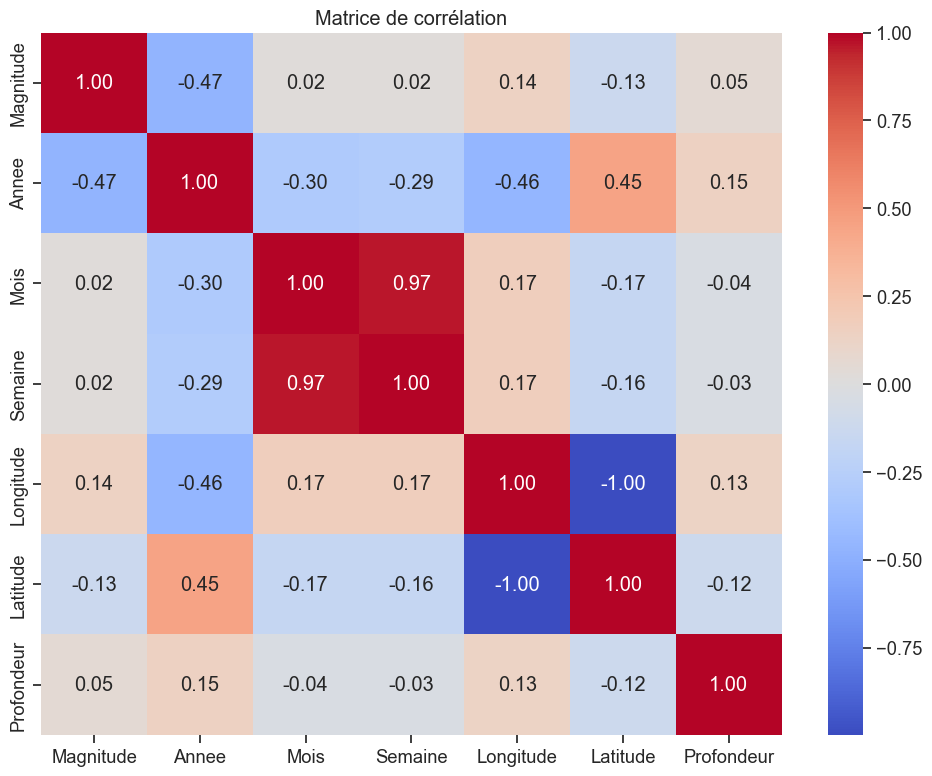


Données divisées: 11340 observations pour l'entraînement, 3781 pour le test

2. RÉGRESSION MULTILINÉAIRE: INTENSITÉ DU SÉISME
--------------------------------------------------

Coefficients du modèle:
     Variable  Coefficient
0       Annee    -0.247065
1        Mois    -0.031055
2     Semaine    -0.000227
3   Longitude     0.072105
4    Latitude     0.290614
5  Profondeur     0.009771

Performance du modèle sur l'ensemble de test:
R² = 0.2831
RMSE = 0.7128


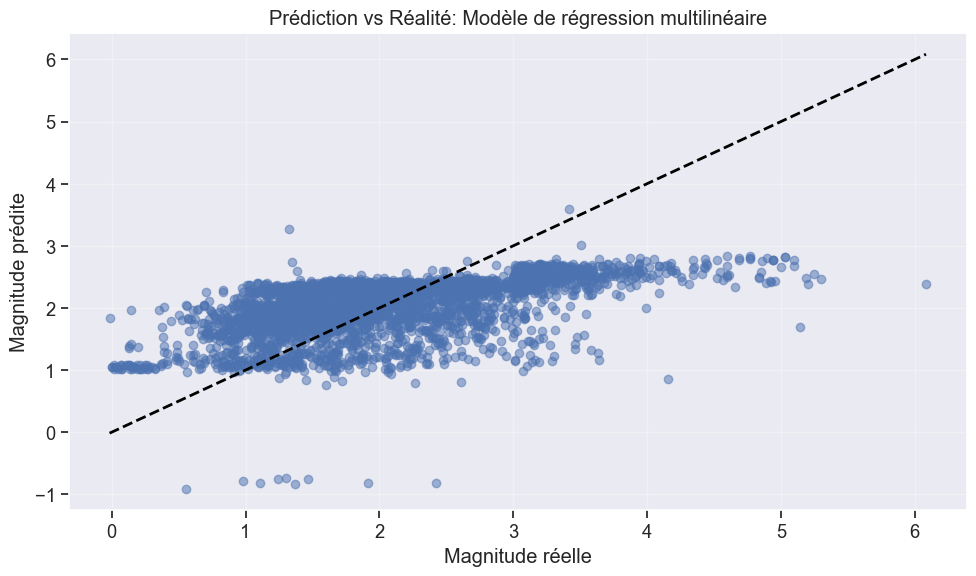


3. ANALYSE DES VARIABLES IMPORTANTES
----------------------------------------

Importance des variables (score combiné):
            Coef_abs  Coef_std    F_stat      P_valeur  Info_mutuelle  \
Annee       0.850150  0.333752  1.000000  0.000000e+00       1.000000   
Latitude    1.000000  1.000000  0.060870  1.057546e-58       0.464260   
Longitude   0.248111  0.930209  0.070078  3.208842e-67       0.819798   
Profondeur  0.033621  0.075208  0.009774  8.205855e-11       0.753190   
Mois        0.106859  0.074776  0.001565  9.282769e-03       0.139917   
Semaine     0.000780  0.000773  0.001415  1.339443e-02       0.156002   

            P_valeur_norm  Importance_combinée  
Annee            1.000000             0.836780  
Latitude         1.000000             0.705026  
Longitude        1.000000             0.613639  
Profondeur       1.000000             0.374359  
Mois             0.306968             0.126017  
Semaine          0.000000             0.031794  


<Figure size 1200x600 with 0 Axes>

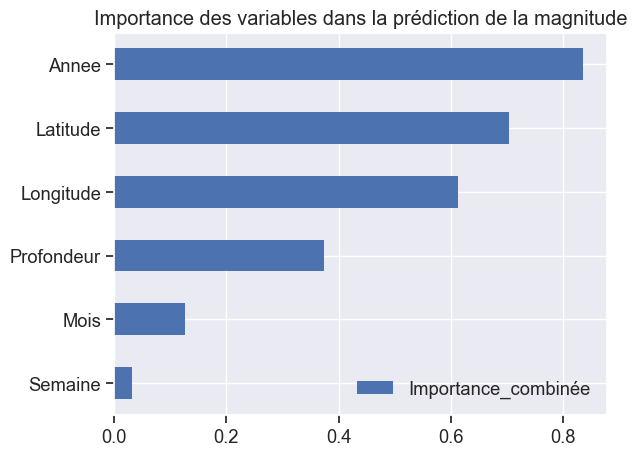


4. SÉLECTION DU MEILLEUR MODÈLE DE RÉGRESSION
--------------------------------------------------
Évaluation de 20 combinaisons de variables...

Top 5 des meilleurs modèles selon le R²:
              Variables Indices  Num_vars   R2_mean    R2_std
7               Semaine    (2,)         1 -0.722334  0.834602
10  Semaine, Profondeur  (2, 5)         2 -0.768971  0.894901
1                 Annee    (0,)         1 -0.927561  0.661055
12    Annee, Profondeur  (0, 5)         2 -0.998161  0.782856
13       Annee, Semaine  (0, 2)         2 -1.063706  0.805126

Meilleur modèle: Semaine (R² = -0.7223)

Performance du meilleur modèle sur l'ensemble de test:
R² = 0.0000 (vs 0.2831 pour le modèle complet)
RMSE = 0.8419 (vs 0.7128 pour le modèle complet)

Coefficients du meilleur modèle:
  Variable  Coefficient
0  Semaine     0.001044

5. ANALYSE EN COMPOSANTES PRINCIPALES (ACP)
----------------------------------------

Variance expliquée par chaque composante:
PC1: 0.4432 (0.4432 cumulatif)
PC2: 0.

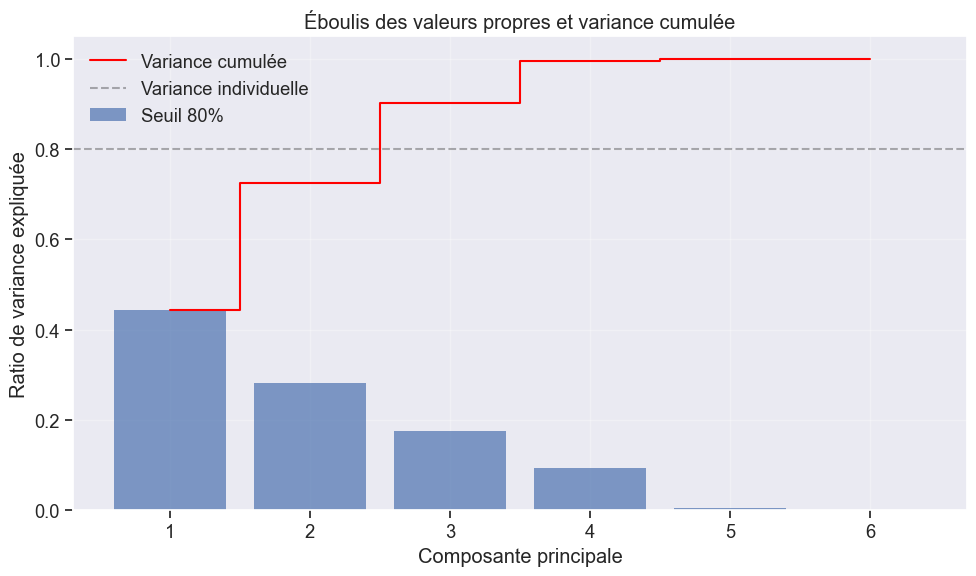


Contribution des variables aux composantes principales:
                 PC1       PC2       PC3
Annee      -0.413505  0.057983  0.395677
Mois        0.412602  0.545854  0.148314
Semaine     0.410416  0.546491  0.156408
Longitude   0.495610 -0.425917  0.023330
Latitude   -0.494226  0.425656 -0.015942
Profondeur  0.021053 -0.193495  0.892289


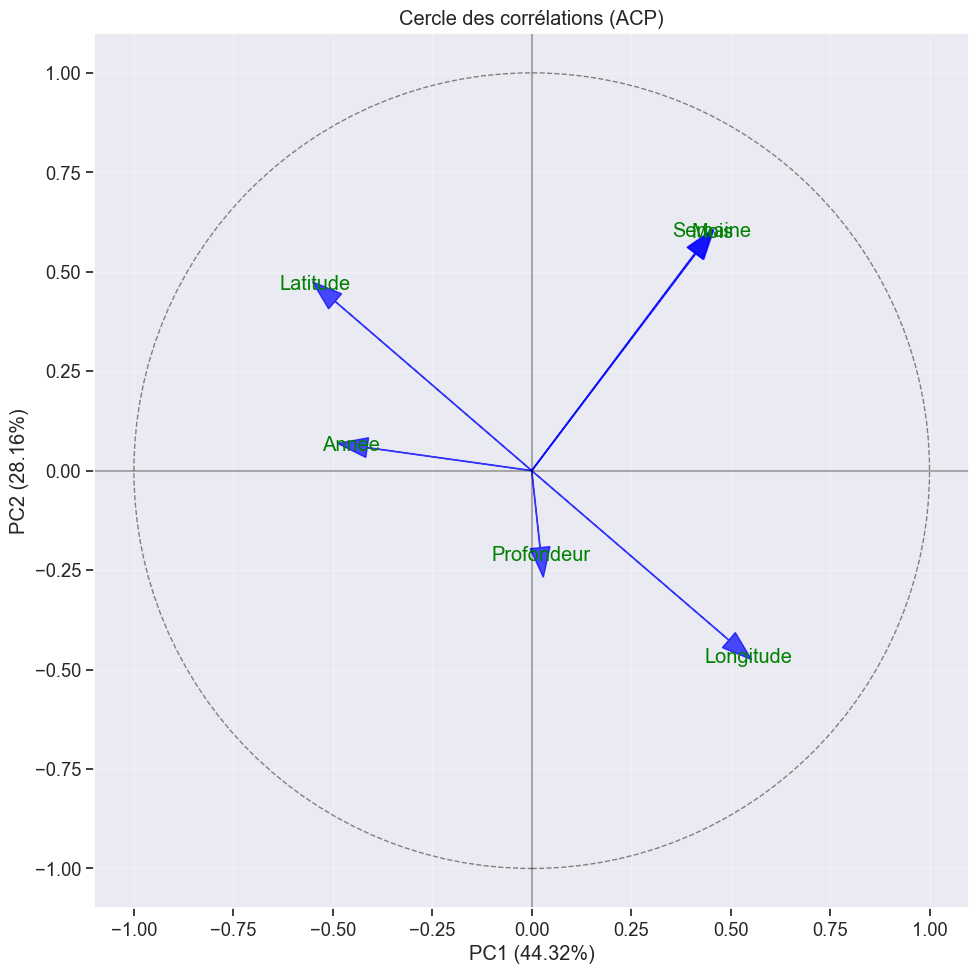

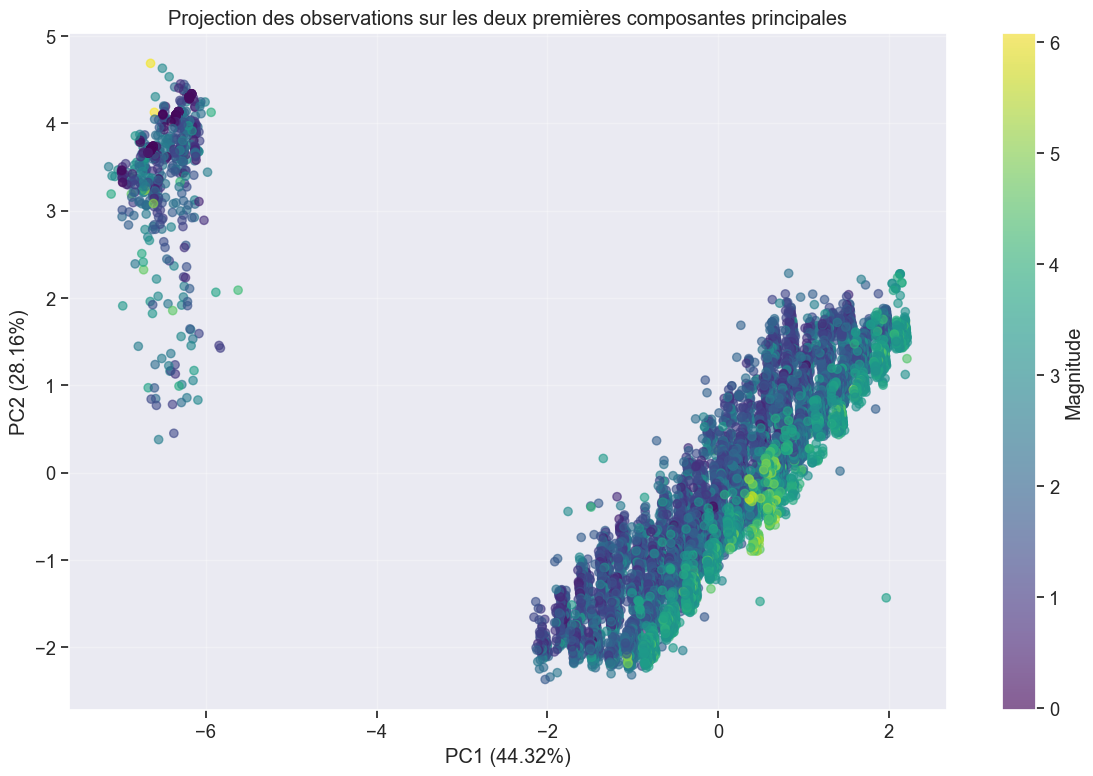


Performance du modèle de régression avec 3 composantes principales:
R² = 0.0753
RMSE = 0.8096

6. CONCLUSION ET SYNTHÈSE
------------------------------

Comparaison des performances des différents modèles:
                   Modèle                                          Variables  \
0        Toutes variables  Annee, Mois, Semaine, Longitude, Latitude, Pro...   
1  Meilleur sous-ensemble                                            Semaine   
2     ACP (3 composantes)                          3 composantes principales   

         R²      RMSE  
0  0.283146  0.712846  
1  0.000014  0.841932  
2  0.075334  0.809604  

Variables les plus importantes pour expliquer l'intensité des séismes:
1. Annee (importance: 0.8368)
2. Latitude (importance: 0.7050)
3. Longitude (importance: 0.6136)
4. Profondeur (importance: 0.3744)
5. Mois (importance: 0.1260)
6. Semaine (importance: 0.0318)


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.decomposition import PCA
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

def analyse_sismique_sklearn(df):
    """
    Analyse simplifiée des données sismiques en utilisant uniquement scikit-learn
    pour une meilleure compatibilité avec divers formats de données
    """
    
    print("="*80)
    print(" ANALYSE DE RÉGRESSION MULTILINÉAIRE ET ACP DES DONNÉES SISMIQUES")
    print("="*80)
    
    # ===== 1. PRÉPARATION DES DONNÉES =====
    
    print("\n1. PRÉPARATION DES DONNÉES\n" + "-"*30)
    
    # Vérifier si les colonnes nécessaires existent
    if 'Magnitude' not in df.columns:
        print("⚠️ La colonne 'Magnitude' est requise mais introuvable. Analyse impossible.")
        return
    
    # Création d'une copie pour éviter de modifier le dataframe original
    df_analyse = df.copy()
    
    # Extraction des variables temporelles si 'Date' est présente
    if 'Date' in df_analyse.columns:
        print("Extraction des variables temporelles à partir de la colonne 'Date'...")
        
        # S'assurer que la colonne Date est au format datetime
        if not pd.api.types.is_datetime64_any_dtype(df_analyse['Date']):
            df_analyse['Date'] = pd.to_datetime(df_analyse['Date'], errors='coerce')
        
        # Extraire les composantes temporelles
        if pd.api.types.is_datetime64_any_dtype(df_analyse['Date']):
            df_analyse['Annee'] = df_analyse['Date'].dt.year
            df_analyse['Mois'] = df_analyse['Date'].dt.month
            try:
                df_analyse['Semaine'] = df_analyse['Date'].dt.isocalendar().week
            except:
                try:
                    df_analyse['Semaine'] = df_analyse['Date'].dt.week
                except:
                    print("⚠️ Impossible d'extraire le numéro de semaine, cette variable sera ignorée.")
            
            print(f"Variables temporelles ajoutées: Annee, Mois, Semaine")
        else:
            print("⚠️ Conversion de date échouée, les variables temporelles ne seront pas extraites.")
    
    # Définir la variable dépendante et les variables explicatives
    y_var = 'Magnitude'
    candidate_vars = ['Annee', 'Mois', 'Semaine', 'Longitude', 'Latitude', 'Profondeur']
    X_vars = [var for var in candidate_vars if var in df_analyse.columns]
    
    if len(X_vars) < 2:
        print(f"⚠️ Trop peu de variables explicatives disponibles: {X_vars}")
        print("Analyse impossible. Vérifiez vos données.")
        return
    
    print(f"Variable à expliquer: {y_var}")
    print(f"Variables explicatives disponibles: {X_vars}")
    
    # Tentative de conversion forcée en type numérique
    for col in [y_var] + X_vars:
        try:
            df_analyse[col] = df_analyse[col].astype(float)
        except:
            try:
                df_analyse[col] = pd.to_numeric(df_analyse[col], errors='coerce')
            except Exception as e:
                print(f"⚠️ Impossible de convertir la colonne {col}: {e}")
    
    # Filtrer les données pour ne garder que les lignes sans valeurs manquantes
    df_clean = df_analyse.dropna(subset=[y_var] + X_vars)
    
    print(f"Données nettoyées: {len(df_clean)} observations sur {len(df_analyse)} ({len(df_clean)/len(df_analyse)*100:.1f}%)")
    
    # Vérification finale des types de données
    dtypes_info = df_clean[X_vars + [y_var]].dtypes
    print("\nTypes de données finaux:")
    print(dtypes_info)
    
    # Matrice de corrélation
    try:
        corr_matrix = df_clean[[y_var] + X_vars].corr()
        print("\nMatrice de corrélation entre variables:")
        print(corr_matrix[y_var].sort_values(ascending=False))
        
        # Visualisation de la matrice de corrélation
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
        plt.title('Matrice de corrélation')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"⚠️ Impossible de calculer la matrice de corrélation: {e}")
    
    # Séparer les features et la variable cible
    X = df_clean[X_vars].values  # Conversion explicite en array numpy
    y = df_clean[y_var].values
    
    # Division en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    print(f"\nDonnées divisées: {X_train.shape[0]} observations pour l'entraînement, {X_test.shape[0]} pour le test")
    
    # ===== 2. MODÈLE DE RÉGRESSION MULTILINÉAIRE INITIAL =====
    
    print("\n2. RÉGRESSION MULTILINÉAIRE: INTENSITÉ DU SÉISME\n" + "-"*50)
    
    # Créer et entraîner le modèle de régression avec scikit-learn
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Afficher les coefficients du modèle
    coef_df = pd.DataFrame({
        'Variable': X_vars,
        'Coefficient': model.coef_
    })
    print("\nCoefficients du modèle:")
    print(coef_df)
    
    # Évaluer le modèle
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print(f"\nPerformance du modèle sur l'ensemble de test:")
    print(f"R² = {r2:.4f}")
    print(f"RMSE = {rmse:.4f}")
    
    # Visualiser les prédictions vs valeurs réelles
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([min(y), max(y)], [min(y), max(y)], 'k--', lw=2)
    plt.xlabel('Magnitude réelle')
    plt.ylabel('Magnitude prédite')
    plt.title('Prédiction vs Réalité: Modèle de régression multilinéaire')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # ===== 3. ANALYSE DES VARIABLES IMPORTANTES =====
    
    print("\n3. ANALYSE DES VARIABLES IMPORTANTES\n" + "-"*40)
    
    # Initialiser le dictionnaire pour stocker les différentes mesures d'importance
    var_importance = pd.DataFrame(index=X_vars)
    
    # Importance basée sur les coefficients du modèle
    var_importance['Coef_abs'] = np.abs(model.coef_)
    
    # Importance basée sur les coefficients standardisés
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    model_scaled = LinearRegression()
    model_scaled.fit(X_scaled, y)
    var_importance['Coef_std'] = np.abs(model_scaled.coef_)
    
    # Basée sur les F-statistics
    f_stat, p_values = f_regression(X, y)
    var_importance['F_stat'] = f_stat
    var_importance['P_valeur'] = p_values
    
    # Information mutuelle (relation non linéaire)
    mi_importance = mutual_info_regression(X, y)
    var_importance['Info_mutuelle'] = mi_importance
    
    # Normaliser les scores d'importance entre 0 et 1
    for col in ['Coef_abs', 'Coef_std', 'F_stat', 'Info_mutuelle']:
        max_val = var_importance[col].max()
        if max_val > 0:
            var_importance[col] = var_importance[col] / max_val
    
    # Pour les p-valeurs, inverser le score (1 - p) et normaliser
    var_importance['P_valeur_norm'] = 1 - var_importance['P_valeur'] / var_importance['P_valeur'].max()
    
    # Score d'importance combiné
    var_importance['Importance_combinée'] = var_importance[['Coef_abs', 'Coef_std', 'F_stat', 'P_valeur_norm', 'Info_mutuelle']].mean(axis=1)
    
    # Afficher les résultats triés
    print("\nImportance des variables (score combiné):")
    print(var_importance.sort_values('Importance_combinée', ascending=False))
    
    # Visualiser l'importance des variables
    plt.figure(figsize=(12, 6))
    var_importance.sort_values('Importance_combinée').plot.barh(y='Importance_combinée')
    plt.title('Importance des variables dans la prédiction de la magnitude')
    plt.tight_layout()
    plt.show()
    
    # ===== 4. SÉLECTION DU MEILLEUR MODÈLE =====
    
    print("\n4. SÉLECTION DU MEILLEUR MODÈLE DE RÉGRESSION\n" + "-"*50)
    
    # Générer toutes les combinaisons possibles de variables (limité à une taille raisonnable)
    max_vars = min(len(X_vars), 4)  # Limiter pour réduire la complexité
    all_combinations = []
    for r in range(1, max_vars + 1):
        all_combinations.extend(combinations(range(len(X_vars)), r))
    
    # Limiter à 20 combinaisons max si trop nombreuses
    if len(all_combinations) > 20:
        # Utiliser les variables les plus importantes en priorité
        top_vars_idx = var_importance.sort_values('Importance_combinée', ascending=False).index
        top_vars_pos = [X_vars.index(var) for var in top_vars_idx]
        
        # Inclure des combinaisons avec les variables les plus importantes
        selected_combinations = []
        
        # Toutes les variables
        selected_combinations.append(tuple(range(len(X_vars))))
        
        # Top 1, 2, 3 variables
        for i in range(1, min(4, len(top_vars_pos))+1):
            selected_combinations.append(tuple(top_vars_pos[:i]))
        
        # Quelques autres combinaisons (aléatoires) pour diversifier
        import random
        random.seed(42)
        remaining = 20 - len(selected_combinations)
        if remaining > 0:
            remaining_combinations = [c for c in all_combinations if c not in selected_combinations]
            additional = random.sample(remaining_combinations, min(remaining, len(remaining_combinations)))
            selected_combinations.extend(additional)
        
        all_combinations = selected_combinations
    
    print(f"Évaluation de {len(all_combinations)} combinaisons de variables...")
    
    # Évaluer chaque combinaison avec validation croisée
    model_results = []
    
    for combo_idx in all_combinations:
        # Convertir indices en noms de variables
        combo = [X_vars[i] for i in combo_idx]
        
        # Extraire les colonnes pour cette combinaison
        X_combo = df_clean[combo].values
        
        # Entrainer un modèle avec validation croisée
        model = LinearRegression()
        try:
            cv_scores = cross_val_score(model, X_combo, y, cv=5, scoring='r2')
            
            # Enregistrer les résultats
            model_results.append({
                'Variables': ", ".join(combo),
                'Indices': combo_idx,
                'Num_vars': len(combo),
                'R2_mean': cv_scores.mean(),
                'R2_std': cv_scores.std()
            })
        except Exception as e:
            print(f"⚠️ Erreur lors de l'évaluation de la combinaison {combo}: {e}")
    
    # Convertir en DataFrame et trier par R²
    models_df = pd.DataFrame(model_results)
    if not models_df.empty:
        models_df = models_df.sort_values('R2_mean', ascending=False)
        
        # Afficher les meilleurs modèles
        print("\nTop 5 des meilleurs modèles selon le R²:")
        print(models_df.head(5))
        
        # Sélectionner le meilleur modèle
        best_model_vars_str = models_df.iloc[0]['Variables']
        best_model_indices = models_df.iloc[0]['Indices']
        best_model_vars = [X_vars[i] for i in best_model_indices]
        
        print(f"\nMeilleur modèle: {best_model_vars_str} (R² = {models_df.iloc[0]['R2_mean']:.4f})")
        
        # Entrainer le meilleur modèle sur l'ensemble d'entraînement complet
        X_best = X_train[:, list(best_model_indices)]
        model_best = LinearRegression().fit(X_best, y_train)
        
        # Évaluer sur l'ensemble de test
        X_test_best = X_test[:, list(best_model_indices)]
        y_pred_best = model_best.predict(X_test_best)
        
        r2_best = r2_score(y_test, y_pred_best)
        rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
        
        print(f"\nPerformance du meilleur modèle sur l'ensemble de test:")
        print(f"R² = {r2_best:.4f} (vs {r2:.4f} pour le modèle complet)")
        print(f"RMSE = {rmse_best:.4f} (vs {rmse:.4f} pour le modèle complet)")
        
        # Afficher les coefficients du meilleur modèle
        coef_best_df = pd.DataFrame({
            'Variable': [X_vars[i] for i in best_model_indices],
            'Coefficient': model_best.coef_
        })
        print("\nCoefficients du meilleur modèle:")
        print(coef_best_df)
    else:
        print("⚠️ Aucun modèle valide n'a pu être évalué.")
        best_model_vars = X_vars
        r2_best = r2
        rmse_best = rmse
    
    # ===== 5. ANALYSE EN COMPOSANTES PRINCIPALES (ACP) =====
    
    print("\n5. ANALYSE EN COMPOSANTES PRINCIPALES (ACP)\n" + "-"*40)
    
    # Standardiser les données pour l'ACP
    scaler = StandardScaler()
    try:
        X_scaled = scaler.fit_transform(X)
        
        # Appliquer l'ACP
        pca = PCA()
        X_pca = pca.fit_transform(X_scaled)
        
        # Afficher les résultats de l'ACP
        explained_variance = pca.explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variance)
        
        print("\nVariance expliquée par chaque composante:")
        for i, (var, cum_var) in enumerate(zip(explained_variance, cumulative_variance)):
            print(f"PC{i+1}: {var:.4f} ({cum_var:.4f} cumulatif)")
        
        # Déterminer le nombre de composantes à conserver (80% de variance expliquée)
        n_components = np.argmax(cumulative_variance >= 0.8) + 1
        if n_components == 0:  # Si aucune composante n'atteint 80%
            n_components = len(X_vars)  # Utiliser toutes les composantes
        
        print(f"\nNombre de composantes pour expliquer 80% de variance: {n_components}")
        
        # Visualisation de l'éboulis (scree plot)
        plt.figure(figsize=(10, 6))
        plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7)
        plt.step(range(1, len(explained_variance) + 1), cumulative_variance, where='mid', color='red')
        plt.axhline(y=0.8, color='k', linestyle='--', alpha=0.3)
        plt.title('Éboulis des valeurs propres et variance cumulée')
        plt.xlabel('Composante principale')
        plt.ylabel('Ratio de variance expliquée')
        plt.legend(['Variance cumulée', 'Variance individuelle', 'Seuil 80%'])
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Charger les composantes principales
        loadings = pca.components_
        
        # Représenter les loadings des deux premières composantes
        loadings_df = pd.DataFrame(loadings.T, index=X_vars, columns=[f'PC{i+1}' for i in range(loadings.shape[0])])
        
        # Afficher les contributions des variables aux composantes principales
        print("\nContribution des variables aux composantes principales:")
        print(loadings_df.iloc[:, :min(3, loadings_df.shape[1])])  # Limiter à 3 composantes max
        
        # Représentation du cercle des corrélations
        if loadings.shape[0] >= 2:  # Vérifier qu'il y a au moins 2 composantes
            plt.figure(figsize=(10, 10))
            
            # Dessiner le cercle
            circle = plt.Circle((0,0), 1, fill=False, color='gray', linestyle='--')
            plt.gca().add_patch(circle)
            
            # Flèches représentant les variables
            for i, (idx, row) in enumerate(loadings_df.iterrows()):
                plt.arrow(0, 0, row['PC1'], row['PC2'], color='b', alpha=0.7, head_width=0.05)
                plt.text(row['PC1']*1.1, row['PC2']*1.1, idx, color='g', ha='center', va='center')
            
            plt.grid(True, alpha=0.3)
            plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
            plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
            plt.xlim(-1.1, 1.1)
            plt.ylim(-1.1, 1.1)
            plt.gca().set_aspect('equal', adjustable='box')
            plt.xlabel(f'PC1 ({explained_variance[0]:.2%})')
            plt.ylabel(f'PC2 ({explained_variance[1]:.2%})')
            plt.title('Cercle des corrélations (ACP)')
            plt.tight_layout()
            plt.show()
        
        # Visualiser les observations dans l'espace des deux premières composantes
        if X_pca.shape[1] >= 2:  # Vérifier qu'il y a au moins 2 composantes
            plt.figure(figsize=(12, 8))
            scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, alpha=0.6, cmap='viridis')
            plt.colorbar(scatter, label=y_var)
            plt.xlabel(f'PC1 ({explained_variance[0]:.2%})')
            plt.ylabel(f'PC2 ({explained_variance[1]:.2%})')
            plt.title('Projection des observations sur les deux premières composantes principales')
            plt.grid(alpha=0.3)
            plt.tight_layout()
            plt.show()
        
        # Tester une régression avec les composantes principales
        if n_components > 0:
            # Sélectionner les composantes principales à conserver
            X_pca_reduced = X_pca[:, :n_components]
            
            # Division en ensembles d'entraînement et de test
            X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(
                X_pca_reduced, y, test_size=0.25, random_state=42)
            
            # Créer et entraîner le modèle
            model_pca = LinearRegression().fit(X_pca_train, y_pca_train)
            y_pca_pred = model_pca.predict(X_pca_test)
            
            r2_pca = r2_score(y_pca_test, y_pca_pred)
            rmse_pca = np.sqrt(mean_squared_error(y_pca_test, y_pca_pred))
            
            print(f"\nPerformance du modèle de régression avec {n_components} composantes principales:")
            print(f"R² = {r2_pca:.4f}")
            print(f"RMSE = {rmse_pca:.4f}")
        else:
            r2_pca = float('nan')
            rmse_pca = float('nan')
    
    except Exception as e:
        print(f"⚠️ Erreur lors de l'ACP: {e}")
        print("L'analyse en composantes principales n'a pas pu être réalisée.")
        explained_variance = []
        loadings_df = pd.DataFrame()
        n_components = 0
        r2_pca = float('nan')
        rmse_pca = float('nan')
    
    # ===== 6. CONCLUSION ET SYNTHÈSE =====
    
    print("\n6. CONCLUSION ET SYNTHÈSE\n" + "-"*30)
    
    print("\nComparaison des performances des différents modèles:")
    results_df = pd.DataFrame({
        'Modèle': ['Toutes variables', 'Meilleur sous-ensemble', f'ACP ({n_components} composantes)'],
        'Variables': [', '.join(X_vars), ', '.join(best_model_vars), f'{n_components} composantes principales'],
        'R²': [r2, r2_best, r2_pca],
        'RMSE': [rmse, rmse_best, rmse_pca]
    })
    print(results_df)
    
    print("\nVariables les plus importantes pour expliquer l'intensité des séismes:")
    for i, (var, importance) in enumerate(var_importance.sort_values('Importance_combinée', ascending=False).iterrows(), 1):
        print(f"{i}. {var} (importance: {importance['Importance_combinée']:.4f})")
    
    return {
        'variables_importantes': var_importance.sort_values('Importance_combinée', ascending=False),
        'meilleur_modele': {
            'variables': best_model_vars,
            'r2': r2_best
        },
        'pca': {
            'variance_expliquee': explained_variance,
            'composantes': loadings_df,
            'n_optimal': n_components
        },
        'resultats_comparatifs': results_df
    }

# Charger les données
df = charger_donnees()

# Utiliser la nouvelle fonction robuste
resultats = analyse_sismique_sklearn(df)
# Pour l'utiliser:
# df = charger_donnees()
# resultats = analyse_sismique_sklearn(df)


=== CLUSTERING SIMPLE AVEC DÉTERMINATION AUTOMATIQUE DU NOMBRE OPTIMAL DE CLUSTERS ===

Chargement des données...
Données chargées: 15121 enregistrements

Aperçu des données:
               Date    Magnitude    Latitude   Longitude   Profondeur  origine
0  18/05/2025 12:37  2,751162941   13,635544  -60,209443  1,384277344        5
1  18/05/2025 08:18  2,334633727   15,194370  -60,480552  17,00683594        5
2  18/05/2025 07:02  1,592047346  -20,956259   55,432863  11,40234375        5
3  16/05/2025 13:50  2,232574105  -12,837000   45,629200        42,52        5
4  16/05/2025 06:37  2,572406563  -12,489623   45,317760    76,203125        5

Conversion des types de données...
  - Colonne 'Magnitude' convertie en numérique
  - Colonne 'Latitude' convertie en numérique
  - Colonne 'Longitude' convertie en numérique
  - Colonne 'Profondeur' convertie en numérique
Colonnes numériques disponibles: ['Magnitude', 'Latitude', 'Longitude', 'Profondeur', 'origine']

Préparation des données pour

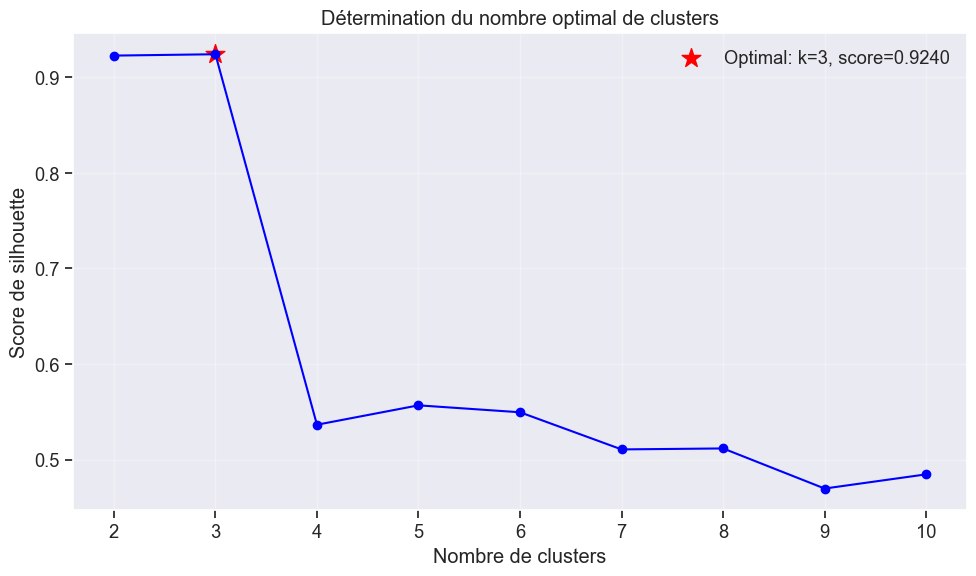


Application du clustering KMeans avec 3 clusters (nombre optimal)...

Statistiques par cluster:

Cluster 0 (14511 observations):
  Magnitude: moyenne = 2.07, min = -0.02, max = 5.90
  Profondeur: moyenne = 34.25, min = -1.98, max = 98.63
  Latitude: moyenne = -12.83, min = -21.26, max = -11.11
  Longitude: moyenne = 45.43, min = 43.07, max = 55.79

Cluster 1 (547 observations):
  Magnitude: moyenne = 1.38, min = 0.00, max = 6.08
  Profondeur: moyenne = 16.00, min = -1.20, max = 69.54
  Latitude: moyenne = 15.29, min = 13.14, max = 19.22
  Longitude: moyenne = -61.09, min = -64.43, max = -57.58

Cluster 2 (63 observations):
  Magnitude: moyenne = 2.35, min = 0.77, max = 4.58
  Profondeur: moyenne = 125.81, min = 72.07, max = 187.05
  Latitude: moyenne = 15.21, min = -12.50, max = 18.14
  Longitude: moyenne = -59.63, min = -63.13, max = 45.76


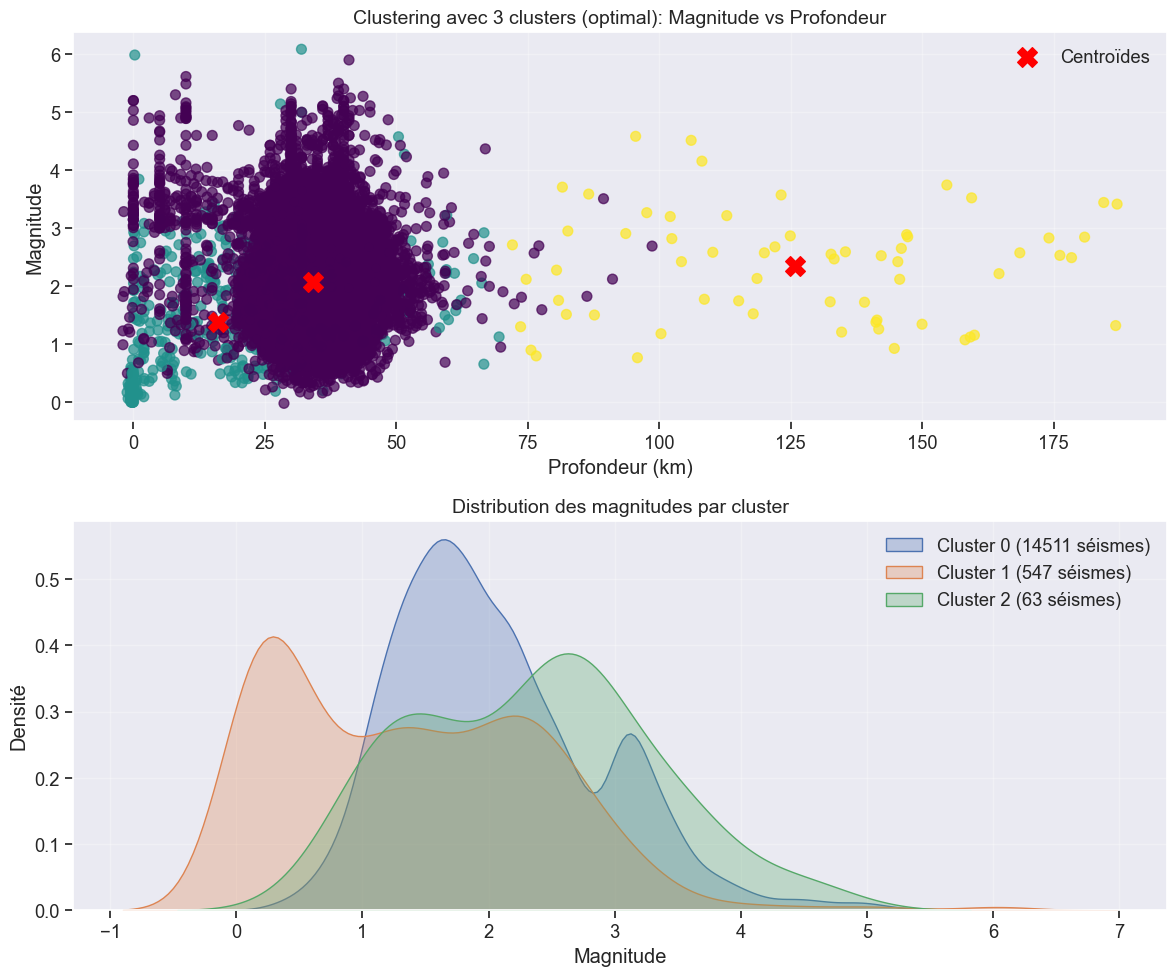

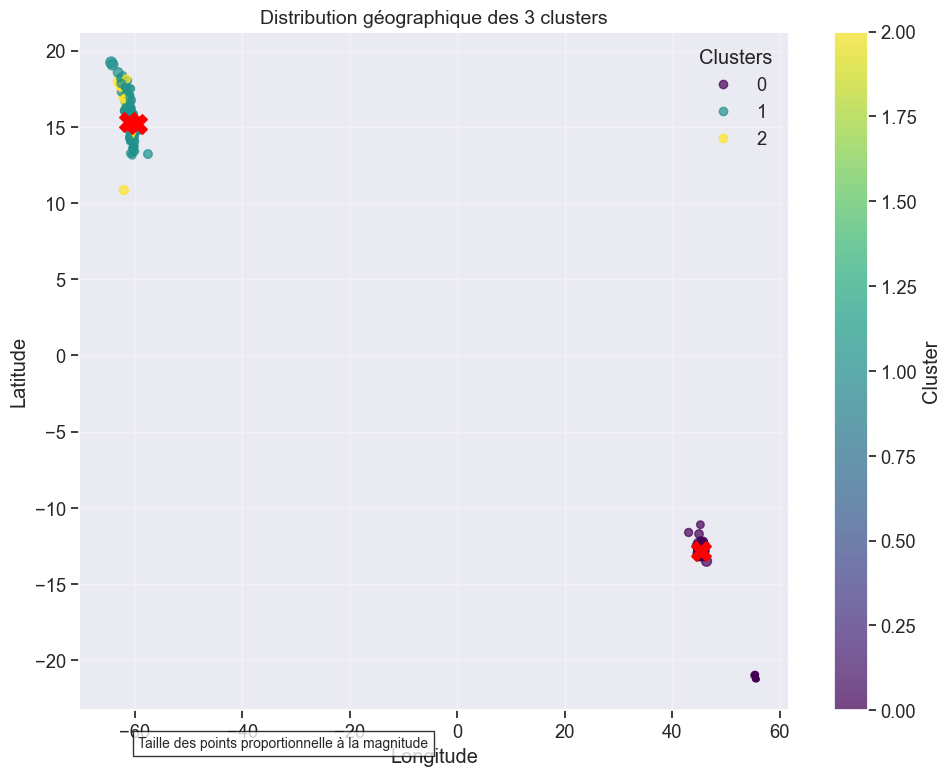


Interprétation des clusters:

Cluster 0 (14511 séismes):
  Magnitude moyenne: 2.07
  Profondeur moyenne: 34.25 km
  → Micro-séismes superficiels

Cluster 1 (547 séismes):
  Magnitude moyenne: 1.38
  Profondeur moyenne: 16.00 km
  → Micro-séismes superficiels

Cluster 2 (63 séismes):
  Magnitude moyenne: 2.35
  Profondeur moyenne: 125.81 km
  → Micro-séismes profonds

Analyse terminée.


In [34]:
##### Clustering ########

# Script de clustering simple pour données sismiques avec détermination automatique 
# du nombre optimal de clusters basée sur le score de silhouette

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

def determiner_nombre_optimal_clusters(X, range_n_clusters=range(2, 11)):
    """
    Détermine le nombre optimal de clusters basé sur le score de silhouette.
    
    Paramètres:
    - X: données pour le clustering
    - range_n_clusters: plage de nombres de clusters à tester
    
    Retourne:
    - optimal_k: nombre optimal de clusters
    """
    print("\n=== Détermination du nombre optimal de clusters ===")
    
    silhouette_scores = []
    
    # Tester différents nombres de clusters
    for n_clusters in range_n_clusters:
        print(f"Évaluation avec {n_clusters} clusters...")
        
        # Appliquer KMeans
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X)
        
        # Calculer le score de silhouette
        try:
            silhouette_avg = silhouette_score(X, cluster_labels)
            silhouette_scores.append(silhouette_avg)
            print(f"  Score de silhouette: {silhouette_avg:.4f}")
        except Exception as e:
            print(f"  Erreur lors du calcul du score pour k={n_clusters}: {e}")
            silhouette_scores.append(-1)  # Score invalide
    
    # Tracer le graphique des scores de silhouette
    plt.figure(figsize=(10, 6))
    plt.plot(list(range_n_clusters), silhouette_scores, 'o-', color='blue')
    plt.xlabel('Nombre de clusters')
    plt.ylabel('Score de silhouette')
    plt.title('Détermination du nombre optimal de clusters')
    plt.grid(alpha=0.3)
    
    # Trouver le nombre optimal de clusters
    valid_scores = [s for s in silhouette_scores if s >= 0]
    if valid_scores:
        best_idx = silhouette_scores.index(max(valid_scores))
        optimal_k = list(range_n_clusters)[best_idx]
        
        # Marquer le meilleur score
        plt.scatter(optimal_k, silhouette_scores[best_idx], s=200, c='red', marker='*',
                   label=f'Optimal: k={optimal_k}, score={silhouette_scores[best_idx]:.4f}')
        plt.legend()
        
        print(f"\nNombre optimal de clusters: {optimal_k} (score de silhouette: {silhouette_scores[best_idx]:.4f})")
    else:
        optimal_k = 3  # Valeur par défaut
        print(f"\nImpossible de déterminer le nombre optimal. Utilisation de k={optimal_k} par défaut.")
    
    plt.tight_layout()
    plt.show()
    
    return optimal_k

def clustering_simple():
    """
    Réalise un clustering simple sur les données sismiques sans prétraitement complexe.
    Détermine automatiquement le nombre optimal de clusters.
    """
    # 1. Chargement des données
    print("Chargement des données...")
    file_path = "NewData-seisme.csv"  # Utiliser directement ce fichier
    
    try:
        # Essayer d'abord avec séparateur point-virgule
        df = pd.read_csv(file_path, sep=';')
    except:
        try:
            # Essayer avec séparateur virgule
            df = pd.read_csv(file_path, sep=',')
        except Exception as e:
            print(f"Erreur lors de la lecture du fichier: {e}")
            return
    
    print(f"Données chargées: {len(df)} enregistrements")
    print("\nAperçu des données:")
    print(df.head())
    
    # 2. Conversion des types de données
    print("\nConversion des types de données...")
    
    # Convertir les colonnes numériques potentiellement en format string
    numeric_columns = []
    for col in df.columns:
        # Vérifier si la colonne contient des nombres mais est en format string
        if df[col].dtype == 'object':
            try:
                # Remplacer la virgule par un point si nécessaire
                df[col] = df[col].str.replace(',', '.', regex=False)
                df[col] = pd.to_numeric(df[col], errors='coerce')
                if not df[col].isna().all():  # Si la conversion a réussi
                    numeric_columns.append(col)
                    print(f"  - Colonne '{col}' convertie en numérique")
            except:
                pass
        elif np.issubdtype(df[col].dtype, np.number):
            numeric_columns.append(col)
    
    print(f"Colonnes numériques disponibles: {numeric_columns}")
    
    # 3. Préparation des données pour le clustering
    print("\nPréparation des données pour le clustering...")
    
    # Sélectionner uniquement les colonnes pertinentes pour le clustering
    clustering_columns = []
    key_columns = ['Magnitude', 'Profondeur', 'Latitude', 'Longitude']
    
    for col in key_columns:
        if col in numeric_columns:
            clustering_columns.append(col)
    
    # Si aucune des colonnes clés n'est disponible, utiliser toutes les colonnes numériques
    if not clustering_columns:
        clustering_columns = numeric_columns
    
    print(f"Colonnes utilisées pour le clustering: {clustering_columns}")
    
    # Vérifier s'il y a assez de colonnes pour le clustering
    if len(clustering_columns) < 2:
        print("ERREUR: Pas assez de variables numériques pour le clustering")
        return
    
    # Créer un DataFrame avec seulement les variables pour le clustering
    X = df[clustering_columns].copy()
    
    # Remplacer les valeurs manquantes par la moyenne de chaque colonne
    for col in X.columns:
        if X[col].isna().any():
            X[col] = X[col].fillna(X[col].mean())
            print(f"  - Valeurs manquantes remplacées dans la colonne '{col}'")
    
    # 4. Détermination du nombre optimal de clusters
    optimal_k = determiner_nombre_optimal_clusters(X, range(2, 11))
    
    # 5. Application de l'algorithme KMeans avec le nombre optimal de clusters
    print(f"\nApplication du clustering KMeans avec {optimal_k} clusters (nombre optimal)...")
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X)
    
    # Ajouter les étiquettes de cluster au DataFrame original
    df['Cluster'] = cluster_labels
    
    # 6. Analyse statistique des clusters
    try:
        # Calculer les statistiques manuellement pour éviter les erreurs d'agrégation
        cluster_stats = {}
        
        for cluster_id in range(optimal_k):
            cluster_data = df[df['Cluster'] == cluster_id]
            
            # Créer un dictionnaire pour stocker les statistiques de ce cluster
            stats = {}
            stats['count'] = len(cluster_data)
            
            # Calculer les statistiques pour chaque colonne numérique
            for col in clustering_columns:
                stats[f'{col}_mean'] = cluster_data[col].mean()
                stats[f'{col}_min'] = cluster_data[col].min()
                stats[f'{col}_max'] = cluster_data[col].max()
            
            # Ajouter les statistiques de ce cluster au dictionnaire global
            cluster_stats[cluster_id] = stats
        
        # Afficher les statistiques
        print("\nStatistiques par cluster:")
        for cluster_id, stats in cluster_stats.items():
            print(f"\nCluster {cluster_id} ({stats['count']} observations):")
            
            for col in clustering_columns:
                print(f"  {col}: moyenne = {stats[f'{col}_mean']:.2f}, "
                      f"min = {stats[f'{col}_min']:.2f}, "
                      f"max = {stats[f'{col}_max']:.2f}")
    
    except Exception as e:
        print(f"Erreur lors du calcul des statistiques: {e}")
    
    # 7. Visualisation des clusters
    try:
        # Vérifier si les colonnes Magnitude et Profondeur existent pour la visualisation
        if 'Magnitude' in clustering_columns and 'Profondeur' in clustering_columns:
            # 7.1 Visualisation Magnitude vs Profondeur
            plt.figure(figsize=(12, 10))
            
            plt.subplot(2, 1, 1)
            scatter = plt.scatter(
                df['Profondeur'], 
                df['Magnitude'],
                c=df['Cluster'],
                cmap='viridis',
                alpha=0.7,
                s=50
            )
            
            # Ajouter les centroïdes
            centers = kmeans.cluster_centers_
            prof_idx = clustering_columns.index('Profondeur')
            mag_idx = clustering_columns.index('Magnitude')
            
            plt.scatter(
                centers[:, prof_idx],
                centers[:, mag_idx],
                c='red',
                marker='X',
                s=200,
                label='Centroïdes'
            )
            
            plt.title(f'Clustering avec {optimal_k} clusters (optimal): Magnitude vs Profondeur', fontsize=14)
            plt.xlabel('Profondeur (km)')
            plt.ylabel('Magnitude')
            plt.grid(alpha=0.3)
            plt.legend(*scatter.legend_elements(), title="Clusters")
            plt.legend()
            
            # 7.2 Distribution des magnitudes par cluster
            plt.subplot(2, 1, 2)
            
            # Pour chaque cluster, tracer la distribution des magnitudes
            for i in range(optimal_k):
                cluster_data = df[df['Cluster'] == i]
                sns.kdeplot(
                    cluster_data['Magnitude'], 
                    label=f'Cluster {i} ({len(cluster_data)} séismes)',
                    fill=True,
                    alpha=0.3
                )
            
            plt.title('Distribution des magnitudes par cluster', fontsize=14)
            plt.xlabel('Magnitude')
            plt.ylabel('Densité')
            plt.grid(alpha=0.3)
            plt.legend()
            
            plt.tight_layout()
            plt.show()
            
            # 7.3 Carte de localisation si lat/lon disponibles
            if 'Latitude' in clustering_columns and 'Longitude' in clustering_columns:
                plt.figure(figsize=(10, 8))
                
                scatter = plt.scatter(
                    df['Longitude'], 
                    df['Latitude'],
                    c=df['Cluster'],
                    cmap='viridis',
                    alpha=0.7,
                    s=df['Magnitude'] * 10 if 'Magnitude' in df.columns else 30
                )
                
                # Ajouter les centroïdes
                lat_idx = clustering_columns.index('Latitude')
                lon_idx = clustering_columns.index('Longitude')
                
                plt.scatter(
                    centers[:, lon_idx],
                    centers[:, lat_idx],
                    c='red',
                    marker='X',
                    s=200,
                    label='Centroïdes'
                )
                
                plt.title(f'Distribution géographique des {optimal_k} clusters', fontsize=14)
                plt.xlabel('Longitude')
                plt.ylabel('Latitude')
                plt.grid(alpha=0.3)
                plt.legend(*scatter.legend_elements(), title="Clusters")
                
                # Correction de la colorbar
                plt.colorbar(scatter, label='Cluster')
                
                if 'Magnitude' in df.columns:
                    plt.figtext(0.15, 0.05, "Taille des points proportionnelle à la magnitude", 
                              fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
                
                plt.tight_layout()
                plt.show()
        else:
            print("Impossible de créer les visualisations: colonnes Magnitude et/ou Profondeur manquantes")
    except Exception as e:
        print(f"Erreur lors de la création des visualisations: {e}")
    
    # 8. Interprétation des clusters
    try:
        if 'Magnitude' in clustering_columns and 'Profondeur' in clustering_columns:
            print("\nInterprétation des clusters:")
            
            for i in range(optimal_k):
                cluster_data = df[df['Cluster'] == i]
                n_points = len(cluster_data)
                mean_mag = cluster_data['Magnitude'].mean()
                mean_depth = cluster_data['Profondeur'].mean()
                
                print(f"\nCluster {i} ({n_points} séismes):")
                print(f"  Magnitude moyenne: {mean_mag:.2f}")
                print(f"  Profondeur moyenne: {mean_depth:.2f} km")
                
                # Interprétation simple basée sur magnitude et profondeur
                if mean_mag < 2.5:
                    if mean_depth < 70:
                        print("  → Micro-séismes superficiels")
                    else:
                        print("  → Micro-séismes profonds")
                elif 2.5 <= mean_mag < 4.0:
                    if mean_depth < 70:
                        print("  → Séismes faibles à légers, superficiels")
                    else:
                        print("  → Séismes faibles à légers, profonds")
                else:  # mean_mag >= 4.0
                    if mean_depth < 70:
                        print("  → Séismes modérés à forts, superficiels")
                    else:
                        print("  → Séismes modérés à forts, profonds")
    except Exception as e:
        print(f"Erreur lors de l'interprétation des clusters: {e}")
    
    return df

# Exécuter le clustering avec détermination automatique du nombre optimal de clusters
print("\n=== CLUSTERING SIMPLE AVEC DÉTERMINATION AUTOMATIQUE DU NOMBRE OPTIMAL DE CLUSTERS ===\n")
result_df = clustering_simple()

print("\nAnalyse terminée.")